# BINF-F401 - Comparison of the morphological description of tissues and thyroid glands, to their transcriptome.

Group 4, 

Lionel Lenoir
<br>
Edwige Loems
<br>
David Perez

## Information about the samples and datasets 

**Samples (collected post-mortem):**
<br>
GTEx
<br>
*54 organs from 948 donors, most with :*
* High-throughput genotypes
* Genome-wide gene expression (RNA-seq)
* Histology images (20X scans)
* Donor level clinical annotations


**clinical-data.tsv**
<br>
*Clinical data matrix includes :*
* AGE
* SEX 
* HEIGHT 
* WEIGHT 
* BMI 
* Cohort : organ donor or post-morthem
* Ischemic time : time elapsed between the presumed donor death and tissue collection
* Hardy Scale : 0 to 4 summarizing the circumstances of death
* SUBJID : GTEx ID of the subject
* **SMPLID : GTEx ID of the organ**
* SMPTHNTS : sample’s pathology notes taken by GTEx pathologists who examined the histological slices
* IMGURL : link to the interactively zoomable high resolution scan of the histological slice


**RNA-read-counts.tsv**
<br>
**Gives the expression of genes across the samples.**
<br>
*Expression data :*
* one row per transcripts (56200 in total)
* First column : Transcript ENSEMBL IDs
* Second column : Gene symbols
* Other columns : each columns stands for a sample
* Expression was recorded as raw, unormalized, read counts, i.e. a read count of 11 for gene G means that 11 reads align on G
* Raw read counts are suitable inputs for differential gene expression software such as DESeq2 or edgeR
* Column names of the expression matrix are indexed with **SMPLID**


**morphological-counts.tsv**
<br>
Count matrix of the morphologies indentified by AI. 
<br>
**Gives the expression of morphological clusters**
<br>
Suggest to use DeSeq2 or edgeR
<br>
<br>
*Construction of the matrix :*
1. Step 1: tile the high-resolution image
    * 20X magnification
    * Each tiles is 224x224 px 2 or 110x110 micron 2
    * There are 5,000-10,000 tiles/image
    * 7,000,000 tiles in the 893 thyroid images
2. Step 2: compute tiles’ latent representations
    * Neural Network : now a tile is a point in a 384 dimensional space
3. Step 3: cluster tiles in latent space
    * 64 morphological cluster are defined 
    * The clustering is done on the 7,000,000 tiles at once, so morphological clusters are representative of the 893 thyroids in GTEx
    * Atlas of the morphological cluster = file morphological-atlas.pdf
        * Order based on a (meta-) clustering of the morphological cluster counts.
4. Step 4: cluster tiles in latent space
    * Morphological summary = number of tiles computed in each cluster



*Structure of the matrix :*
1. Colums stands for morphological clusters (indexed from 0 to 63)
2. **Line stand for samples (indexed by SMPLID)**
3. Example
    * matrix entry (GTEX-111CU-0226, Mophological-cluster-23) = 286
    * Means thyroid GTEX-111CU-0226 has 286 tiles in Mophological-cluster-23
    * Since tiles have a defined physical surface, 110x110 micron 2 (0.11x0.11 mm 2 ) it also mean that Mophological-cluster-23 spans 286x0.11 2 =3.5 mm 2 in histological image of thyroid GTEX-111CU-0226

In [1]:
#Library imports 
library(readr)
library(fgsea)
library(gpGeneSets)
library(BinfTools)
library(dplyr)
library(agricolae)
suppressMessages(library(data.table))
suppressMessages(library(pathwayPCA)) #check if i still use it 
suppressMessages(library(tigerstats))
suppressMessages(library(ggplot2))
suppressMessages(library(gridExtra))
suppressMessages(library("DESeq2"))
suppressMessages(library("vsn"))
suppressMessages(library("pheatmap"))
suppressMessages(library("RColorBrewer"))
suppressMessages(library(RColorBrewer))
suppressMessages(library(repr))
suppressMessages(library(gplots))
set.seed(42)

Loading required package: rmarkdown

Loading required package: knitr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
#clinical data 

cd <- suppressMessages(read_tsv("clinical-data.tsv"))
spec(cd)
summary(cd)

cols(
  SMPLID = col_character(),
  SEX = col_double(),
  AGE = col_double(),
  HGHT = col_double(),
  WGHT = col_double(),
  BMI = col_double(),
  SMPTHNTS = col_character(),
  COHORT = col_character(),
  TRISCHD = col_double(),
  DTHHRDY = col_double(),
  SUBJID = col_character(),
  IMGURL = col_character()
)

    SMPLID               SEX            AGE             HGHT      
 Length:136         Min.   :1.00   Min.   :21.00   Min.   :58.00  
 Class :character   1st Qu.:1.00   1st Qu.:30.00   1st Qu.:66.00  
 Mode  :character   Median :1.00   Median :38.00   Median :68.00  
                    Mean   :1.36   Mean   :37.53   Mean   :68.18  
                    3rd Qu.:2.00   3rd Qu.:45.25   3rd Qu.:71.00  
                    Max.   :2.00   Max.   :49.00   Max.   :76.00  
      WGHT            BMI          SMPTHNTS            COHORT         
 Min.   : 92.0   Min.   :18.58   Length:136         Length:136        
 1st Qu.:159.8   1st Qu.:24.27   Class :character   Class :character  
 Median :184.8   Median :27.75   Mode  :character   Mode  :character  
 Mean   :182.9   Mean   :27.55                                        
 3rd Qu.:205.2   3rd Qu.:31.07                                        
 Max.   :264.0   Max.   :34.86                                        
    TRISCHD          DTHHRDY      

In [3]:
#morphological counts
mc <- suppressMessages(read_tsv("morphological-counts.tsv"))

In [4]:
#rna read counts
rna <- suppressMessages(read_tsv("RNA-read-counts.tsv"))
rna

Name               Description       GTEX-11EM3-0126 GTEX-11EQ9-0626
1     ENSG00000223972.5  DDX11L1             0               1            
2     ENSG00000227232.5  WASH7P            122             174            
3     ENSG00000278267.1  MIR6859-1           0               0            
4     ENSG00000243485.5  MIR1302-2HG         3               0            
5     ENSG00000237613.2  FAM138A             1               0            
6     ENSG00000268020.3  OR4G4P              1               1            
7     ENSG00000240361.1  OR4G11P             1               5            
8     ENSG00000186092.4  OR4F5               0               1            
9     ENSG00000238009.6  RP11-34P13.7        3               1            
10    ENSG00000233750.3  CICP27              4               2            
11    ENSG00000268903.1  RP11-34P13.15     174              73            
12    ENSG00000269981.1  RP11-34P13.16     114              69            
13    ENSG00000239906.1  RP11-34P13.14       0               1            
14    ENSG00000241860.6  RP11-34P13.13      35              18            
15    ENSG00000222623.1  RNU6-1100P          0               0            
16    ENSG00000241599.1  RP11-34P13.9        0               0            
17    ENSG00000279928.2  ABC7-43046700E7.1   1              10            
18    ENSG00000279457.4  RP11-34P13.18     241             388            
19    ENSG00000273874.1  MIR6859-2           0               0            
20    ENSG00000228463.9  AP006222.2          6              19            
21    ENSG00000236679.2  RPL23AP24           1               1            
22    ENSG00000236743.1  RP5-857K21.15       0               0            
23    ENSG00000236601.2  RP4-669L17.2        0               0            
24    ENSG00000237094.11 RP4-669L17.10      15              19            
25    ENSG00000269732.1  WBP1LP7             0               0            
26    ENSG00000278566.1  OR4F29              0               0            
27    ENSG00000233653.3  CICP7               2               2            
28    ENSG00000250575.1  RP4-669L17.8        0               4            
29    ENSG00000278757.1  U6                  0               0            
30    ENSG00000230021.8  RP5-857K21.4        6               8            
⋮     ⋮                  ⋮                 ⋮               ⋮              
56171 ENSG00000210107.1  MT-TQ                   0               0        
56172 ENSG00000210112.1  MT-TM                   2               1        
56173 ENSG00000198763.3  MT-ND2             401331          644517        
56174 ENSG00000210117.1  MT-TW                   0               0        
56175 ENSG00000210127.1  MT-TA                   3               3        
56176 ENSG00000210135.1  MT-TN                   5               7        
56177 ENSG00000210140.1  MT-TC                  18               2        
56178 ENSG00000210144.1  MT-TY                  30             673        
56179 ENSG00000198804.2  MT-CO1            1746814         1998165        
56180 ENSG00000210151.2  MT-TS1                229             147        
56181 ENSG00000210154.1  MT-TD                   1               1        
56182 ENSG00000198712.1  MT-CO2             563143         1064812        
56183 ENSG00000210156.1  MT-TK                   0               0        
56184 ENSG00000228253.1  MT-ATP8             96445          140219        
56185 ENSG00000198899.2  MT-ATP6            550091          740166        
56186 ENSG00000198938.2  MT-CO3             591693          995376        
56187 ENSG00000210164.1  MT-TG                   1               2        
56188 ENSG00000198840.2  MT-ND3             111825          169782        
56189 ENSG00000210174.1  MT-TR                   0               2        
56190 ENSG00000212907.2  MT-ND4L            117364          189216        
56191 ENSG00000198886.2  MT-ND4            1150962         1829837        
56192 ENSG00000210176.1  MT-TH 

## 1.1 : Distribution des variables cliniques

### 1) Sex

In [5]:
# Pour comparer les distributions avec celles du dataset de base : 
# https://ftp.ncbi.nlm.nih.gov/dbgap/studies/phs000424/phs000424.v8.p2/pheno_variable_summaries/phs000424.v8.pht002742.v8.GTEx_Subject_Phenotypes.data_dict.xml

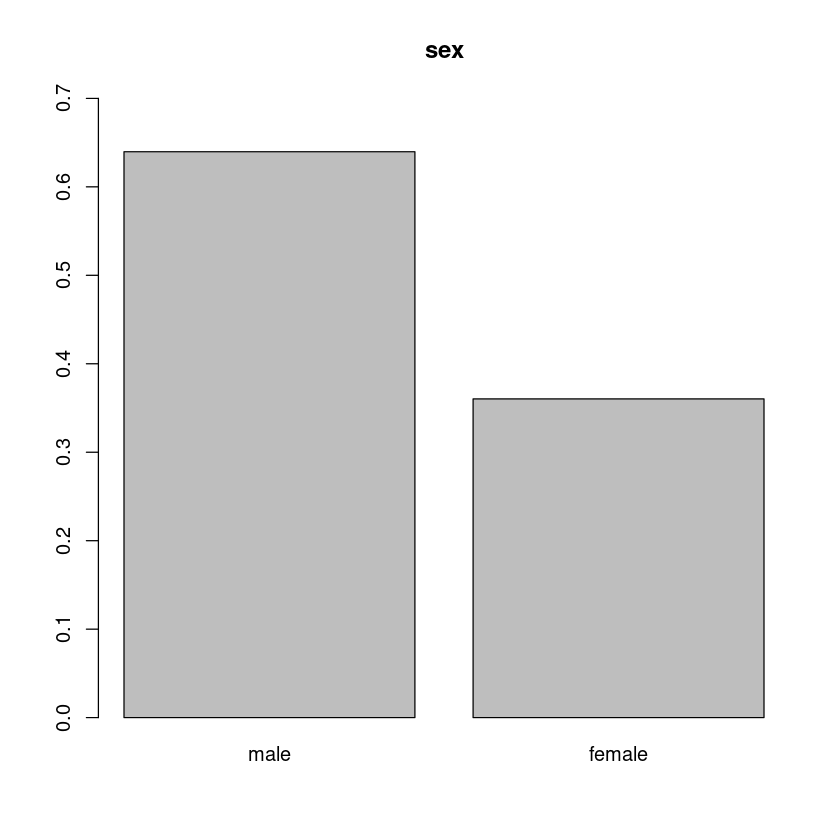

In [6]:
barplot(prop.table(table(data.frame(cd$SEX))), main="sex", names.arg=c("male","female"), ylim=c(0.0,0.7))

### 2) Age

 min Q1 median    Q3 max     mean       sd   n missing
  21 30     38 45.25  49 37.52941 8.611741 136       0


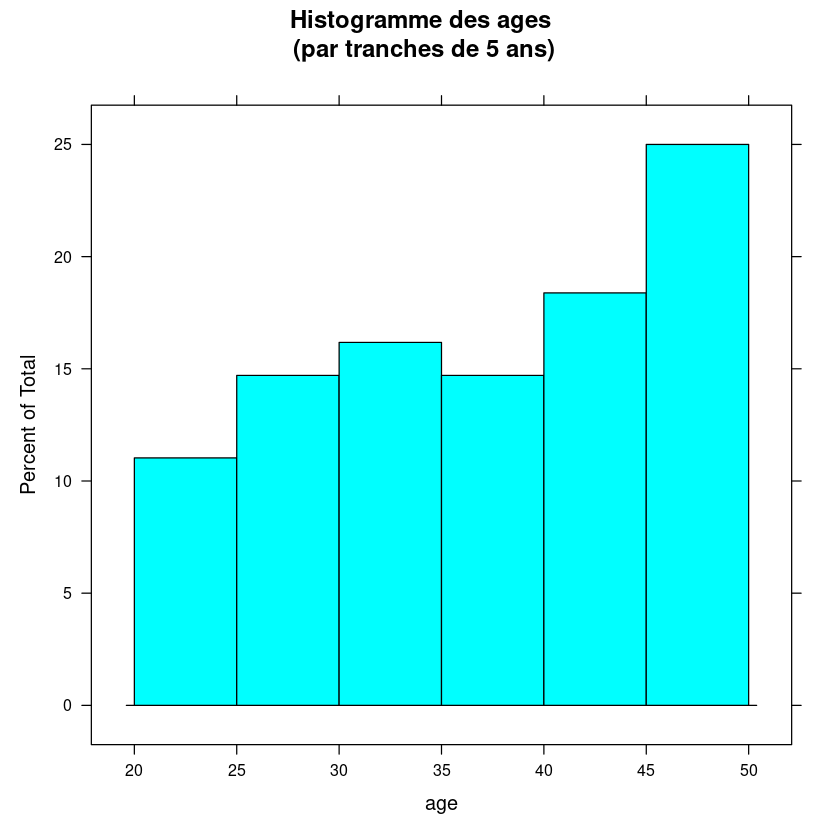

In [7]:
histogram(data.frame(cd$AGE)[,1],main="Histogramme des ages\n (par tranches de 5 ans)", xlab="age",breaks=5)
print(favstats(data.frame(cd$AGE)[,1]))

#Ca va que jusqu'à 50 ans

### 3) Tailles

 min Q1 median Q3 max     mean      sd   n missing
  58 66     68 71  76 68.18478 3.89909 136       0


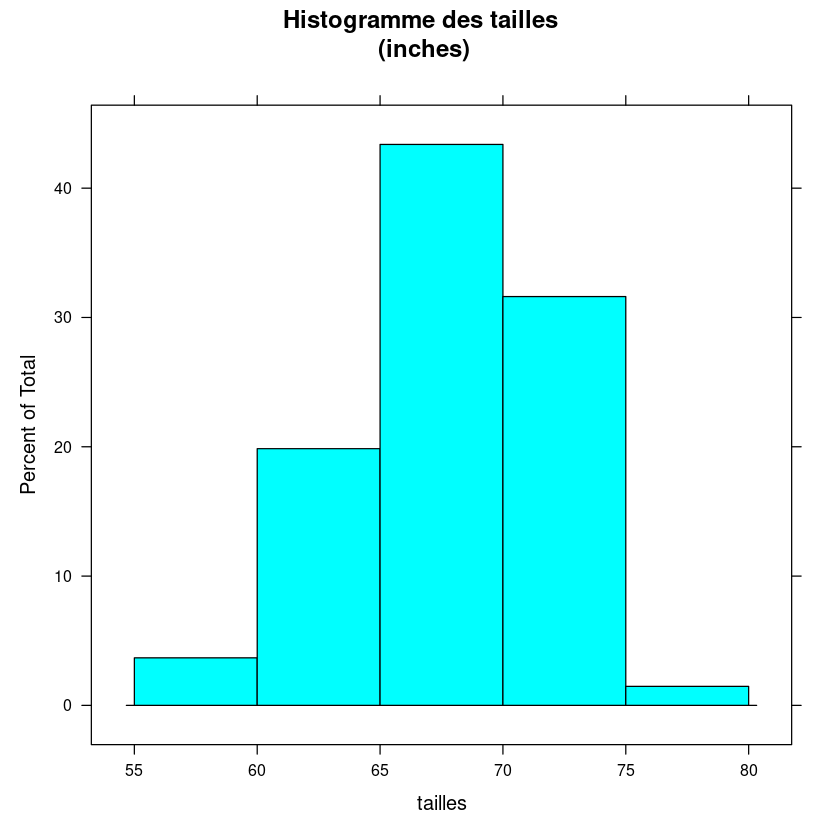

In [8]:
histogram(data.frame(cd$HGHT)[,1],main="Histogramme des tailles\n (inches)", xlab="tailles",breaks=6)
print(favstats(data.frame(cd$HGHT)[,1]))

### 4) Poids

 min     Q1 median     Q3 max     mean       sd   n missing
  92 159.75  184.8 205.25 264 182.9454 33.58838 136       0


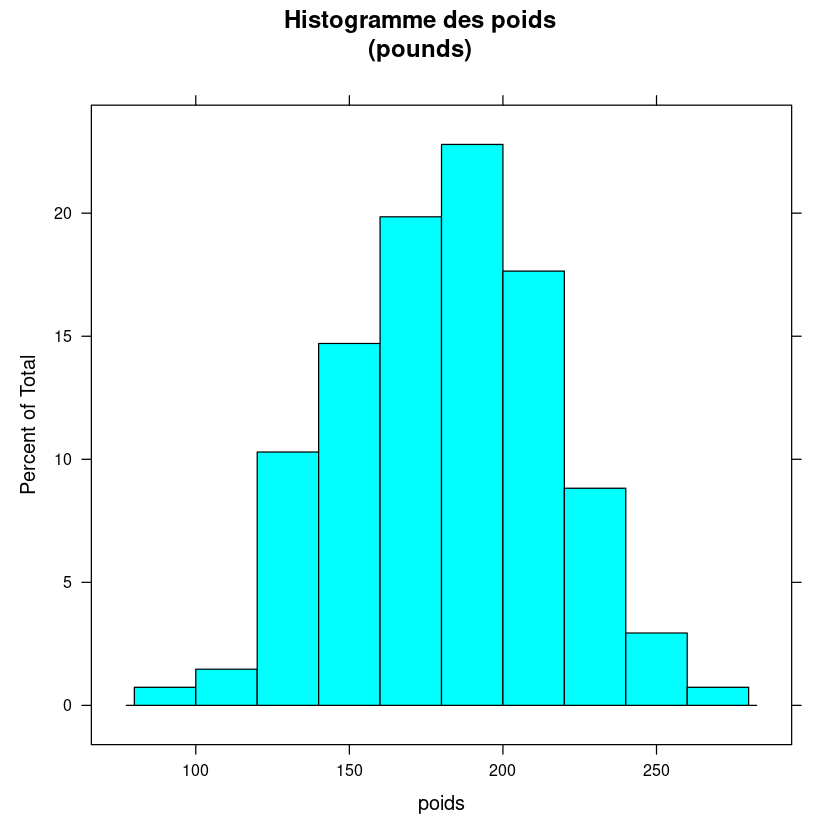

In [9]:
histogram(data.frame(cd$WGHT)[,1],main="Histogramme des poids\n (pounds) ", xlab="poids", breaks=7)
print(favstats(data.frame(cd$WGHT)[,1]))

### 5) Indice de masse corporelle

   min      Q1 median      Q3   max     mean       sd   n missing
 18.58 24.2675  27.75 31.0725 34.86 27.55471 3.925531 136       0


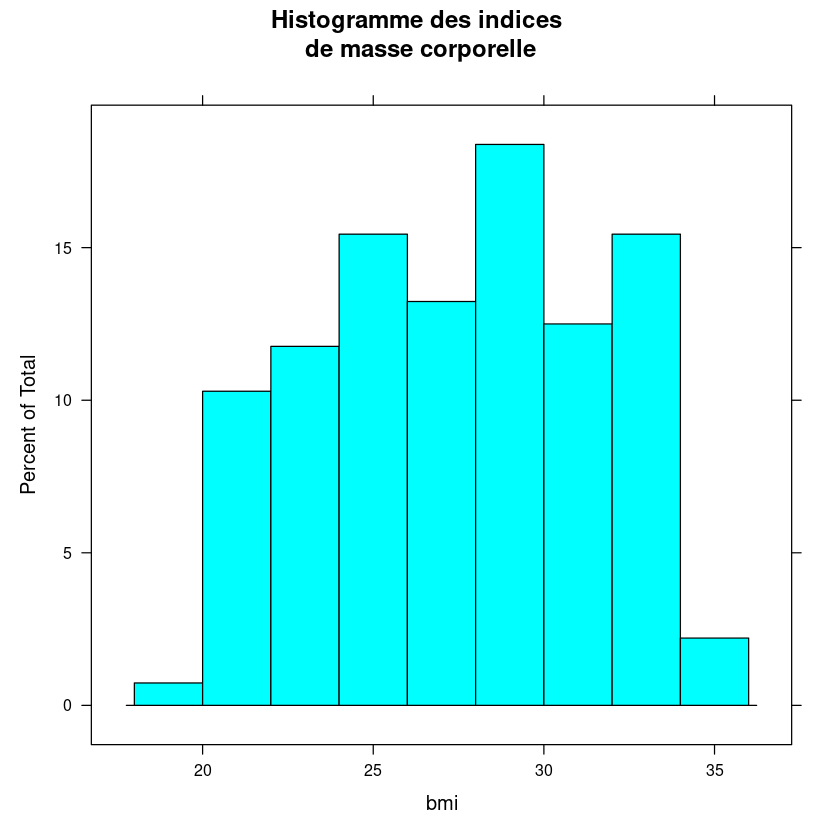

In [10]:
histogram(data.frame(cd$BMI)[,1],main="Histogramme des indices \n de masse corporelle ", xlab="bmi", breaks=6)
print(favstats(data.frame(cd$BMI)[,1]))

### 6) Cohorte

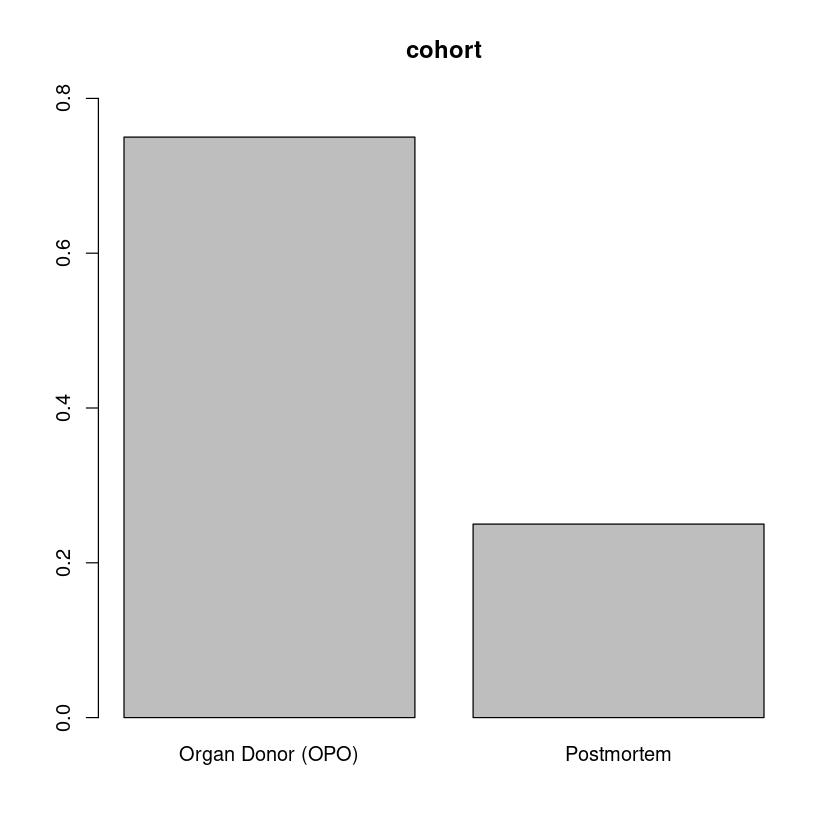

In [11]:
barplot(prop.table(table(data.frame(cd$COHORT))), main="cohort", ylim=c(0.0,0.8))
#Corrélation age - cohorte ?

### 7) Temps ischémique

 min   Q1 median     Q3  max     mean      sd   n missing
  15 61.5    209 474.25 1641 382.5588 411.018 136       0


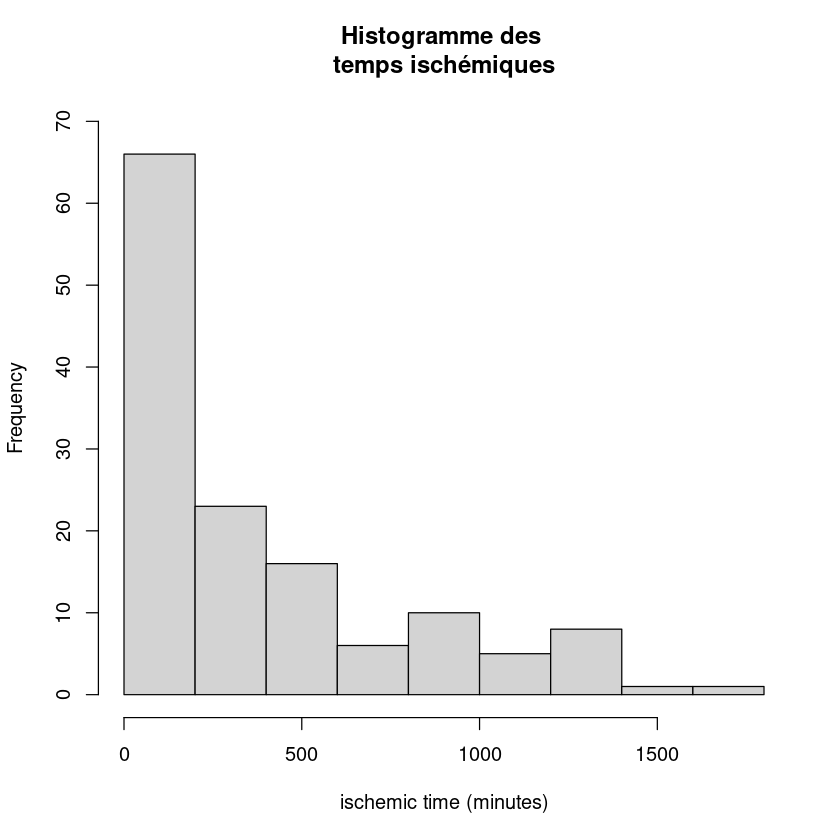

In [12]:
hist(data.frame(cd$TRISCHD)[,1],main="Histogramme des \n temps ischémiques ", xlab="ischemic time (minutes)", ylim=c(0,70))
print(favstats(data.frame(cd$TRISCHD)[,1]))

### 8) Echelle de Hardy

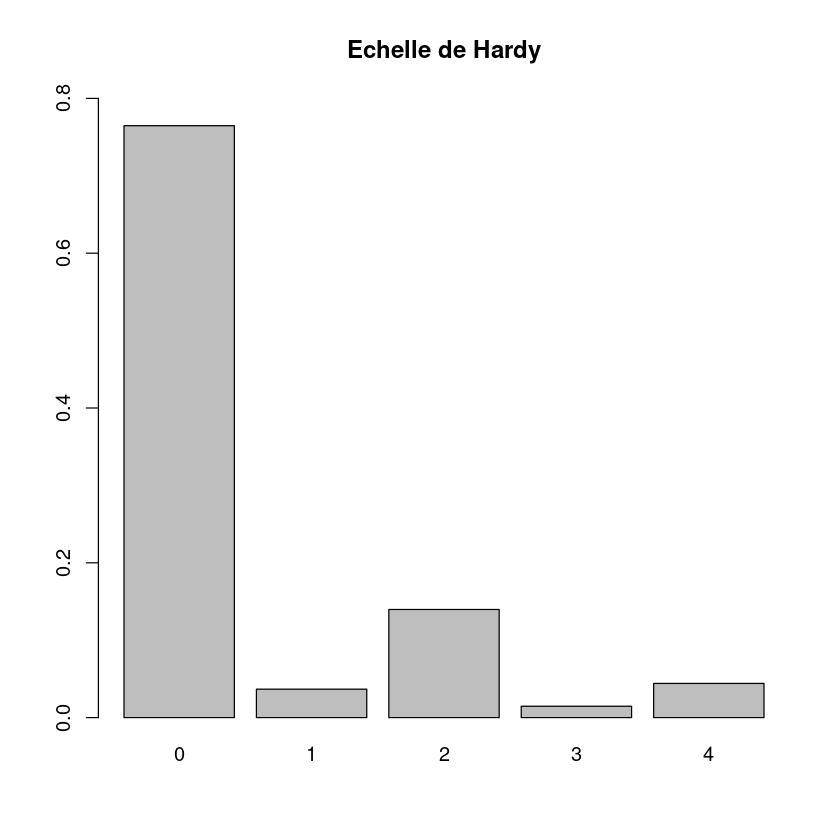

In [13]:
barplot(prop.table(table(data.frame(cd$DTHHRDY))), main="Echelle de Hardy", ylim=c(0.0,0.8))

## 1.2 : Corrélations entre variables

### Liaisons entre les variables "démographiques"
#### Sexe = variable catégorielle --> comparaison visuelle avec boxplot 

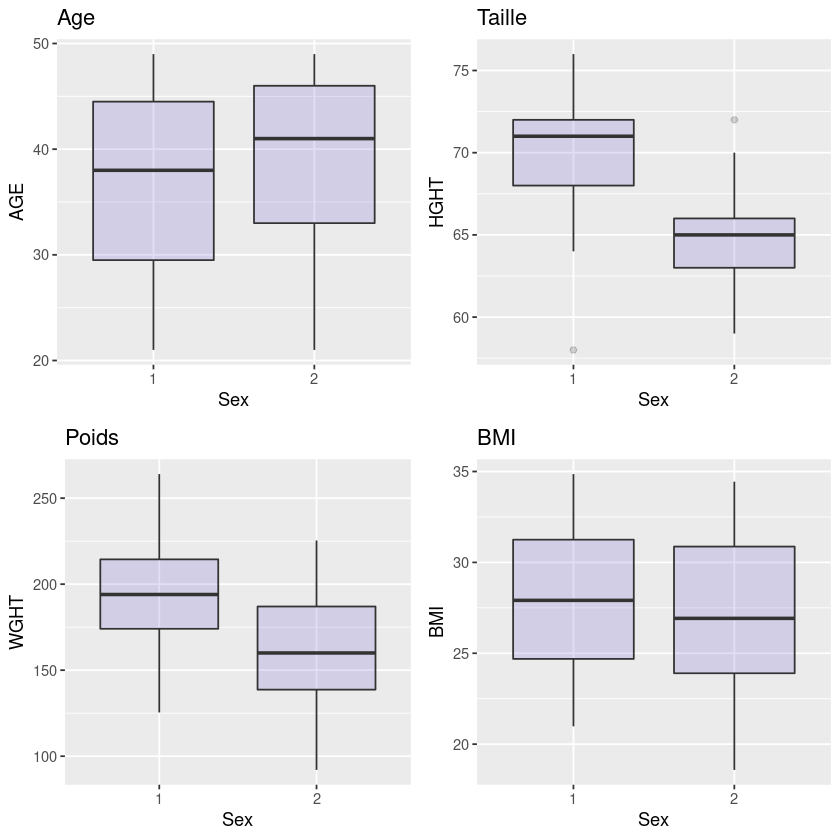

In [14]:
# Boxplots avec les différentes variables en fct de sex
p1 <- ggplot(cd,aes(x=as.factor(SEX), y=AGE)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + ggtitle("Age") + 
    xlab("Sex")
p2 <- ggplot(cd,aes(x=as.factor(SEX), y=HGHT)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + 
    xlab("Sex") + ggtitle("Taille")

p3 <- ggplot(cd,aes(x=as.factor(SEX), y=WGHT)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + 
    xlab("Sex") + ggtitle("Poids")
p4 <- ggplot(cd,aes(x=as.factor(SEX), y=BMI)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + 
    xlab("Sex") + ggtitle("BMI")

grid.arrange(p1,p2,p3,p4, ncol=2)

#### Vérification avec tests de Mann-Whitney

In [15]:
# 2 nouveaux dataframes : hommes et femmes
hommes <- filter(cd, SEX == 1)
femmes <- filter(cd, SEX == 2)

#unpaired two-samples Wilcoxon test =  Wilcoxon rank sum test = Mann-Whitney test
# Calcul des tests de Mann-Whitney pour les différentes variables :

w_age <- wilcox.test(hommes$AGE, femmes$AGE)$p.value
w_hght <- wilcox.test(hommes$HGHT, femmes$HGHT)$p.value
w_wght <- wilcox.test(hommes$WGHT, femmes$WGHT)$p.value
w_bmi <- wilcox.test(hommes$BMI, femmes$BMI)$p.value

print(paste('p-value for age : ', toString(w_age)))
print(paste('p-value for hght : ', toString(w_hght)))
print(paste('p-value for wght : ', toString(w_wght)))
print(paste('p-value for bmi : ', toString(w_bmi)))


## On constate que les variables du poids et de la taille ne sont clairement pas indépendante du sexe, mais on ne peut pas 
## tirer cette conclusion pour l'age et l'indice de masse corporelle, ce qui correspond à ce qu'on observait sur les boxplots

[1] "p-value for age :  0.131321452047474"
[1] "p-value for hght :  3.51914176038072e-16"
[1] "p-value for wght :  1.48960430486491e-07"
[1] "p-value for bmi :  0.377965307143104"


#### Comparaison des variables numériques (age, taille, poids, bmi)

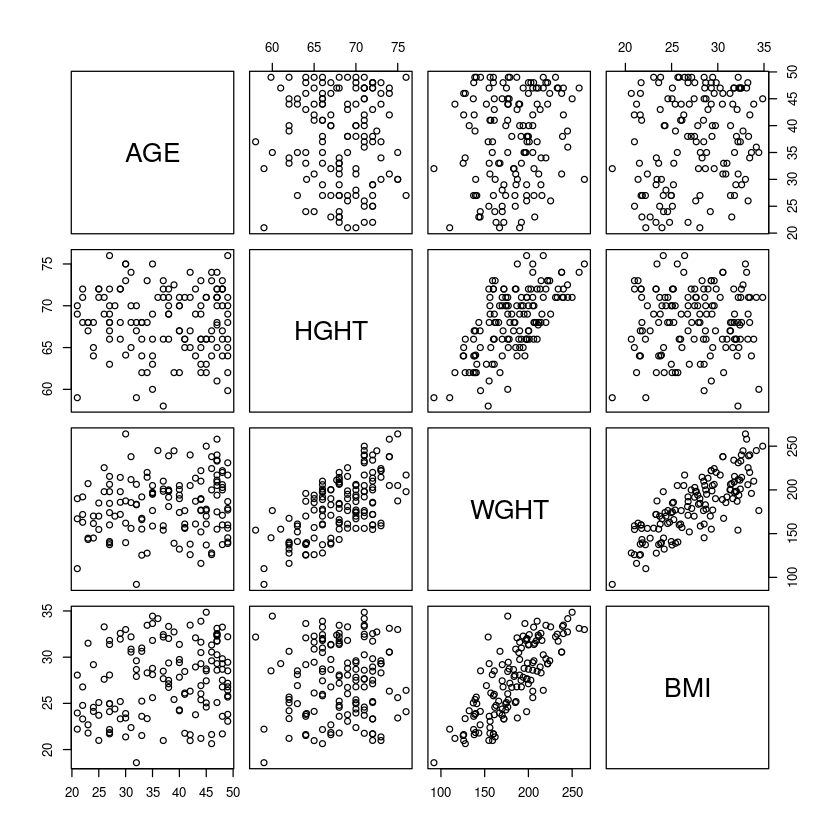

In [16]:
pairs(cd[3:6])
## On observe des corrélations entre la taille et le poids, et entre le poids et le bmi

In [17]:
corr = cor(cd[3:6])
corr

AGE         HGHT        WGHT      BMI       
AGE   1.00000000 -0.03838808 0.1527637 0.21438471
HGHT -0.03838808  1.00000000 0.6391171 0.04597517
WGHT  0.15276366  0.63911706 1.0000000 0.79163615
BMI   0.21438471  0.04597517 0.7916362 1.00000000

### Liaisons des variables techniques avec les variables démographiques
#### Cohorte : 

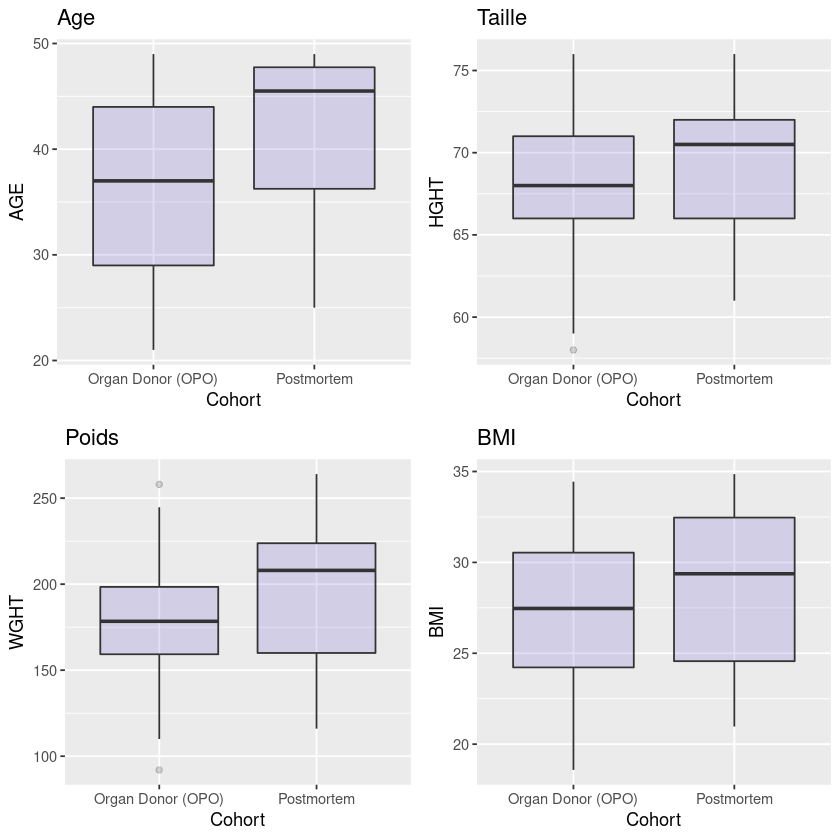

In [18]:
# Boxplots avec les différentes variables en fct de cohort
p1 <- ggplot(cd,aes(x=as.factor(COHORT), y=AGE)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + ggtitle("Age") + 
    xlab("Cohort")
p2 <- ggplot(cd,aes(x=as.factor(COHORT), y=HGHT)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + 
    xlab("Cohort") + ggtitle("Taille")

p3 <- ggplot(cd,aes(x=as.factor(COHORT), y=WGHT)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + 
    xlab("Cohort") + ggtitle("Poids")
p4 <- ggplot(cd,aes(x=as.factor(COHORT), y=BMI)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + 
    xlab("Cohort") + ggtitle("BMI")

grid.arrange(p1,p2,p3,p4, ncol=2)

In [19]:
# 2 nouveaux dataframes : organ donors et postmortems
od <- filter(cd, COHORT == 'Organ Donor (OPO)')
pm <- filter(cd, COHORT == 'Postmortem')

#unpaired two-samples Wilcoxon test =  Wilcoxon rank sum test = Mann-Whitney test
# Calcul des tests de Mann-Whitney pour les différentes variables :

w_age <- wilcox.test(od$AGE, pm$AGE)$p.value
w_hght <- wilcox.test(od$HGHT, pm$HGHT)$p.value
w_wght <- wilcox.test(od$WGHT, pm$WGHT)$p.value
w_bmi <- wilcox.test(od$BMI, pm$BMI)$p.value

print(paste('p-value for age : ', toString(w_age)))
print(paste('p-value for hght : ', toString(w_hght)))
print(paste('p-value for wght : ', toString(w_wght)))
print(paste('p-value for bmi : ', toString(w_bmi)))

## On voit ici que comme suggéré par les boxplots, les 2 cohortes représentent 2 populations qui sont 
## significativement différentes relativement aux paramètres de l'age et du poids

[1] "p-value for age :  0.000715351356559735"
[1] "p-value for hght :  0.0793189642162195"
[1] "p-value for wght :  0.0113078041343223"
[1] "p-value for bmi :  0.105604145672584"


In [20]:
table(cd$COHORT,cd$SEX)
prop.table(table(cd$COHORT,cd$SEX))

                   
                     1  2
  Organ Donor (OPO) 66 36
  Postmortem        21 13

                   
                             1          2
  Organ Donor (OPO) 0.48529412 0.26470588
  Postmortem        0.15441176 0.09558824

In [21]:
fisher.test(cd$COHORT,cd$SEX)
#p-value > 0.05 --> on ne peut pas rejeter l'hypothèse d'indépendance des variables


	Fisher's Exact Test for Count Data

data:  cd$COHORT and cd$SEX
p-value = 0.8373
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4633356 2.7041048
sample estimates:
odds ratio 
  1.133851 


#### Echelle de Hardy

In [22]:
cd['DTHHRDY'] <- factor(cd[['DTHHRDY']])
levels(cd$DTHHRDY)[levels(cd$DTHHRDY)=="2"] <-"1"
levels(cd$DTHHRDY)[levels(cd$DTHHRDY)=="3"] <-"0"
levels(cd$DTHHRDY)[levels(cd$DTHHRDY)=="4"] <-"0"

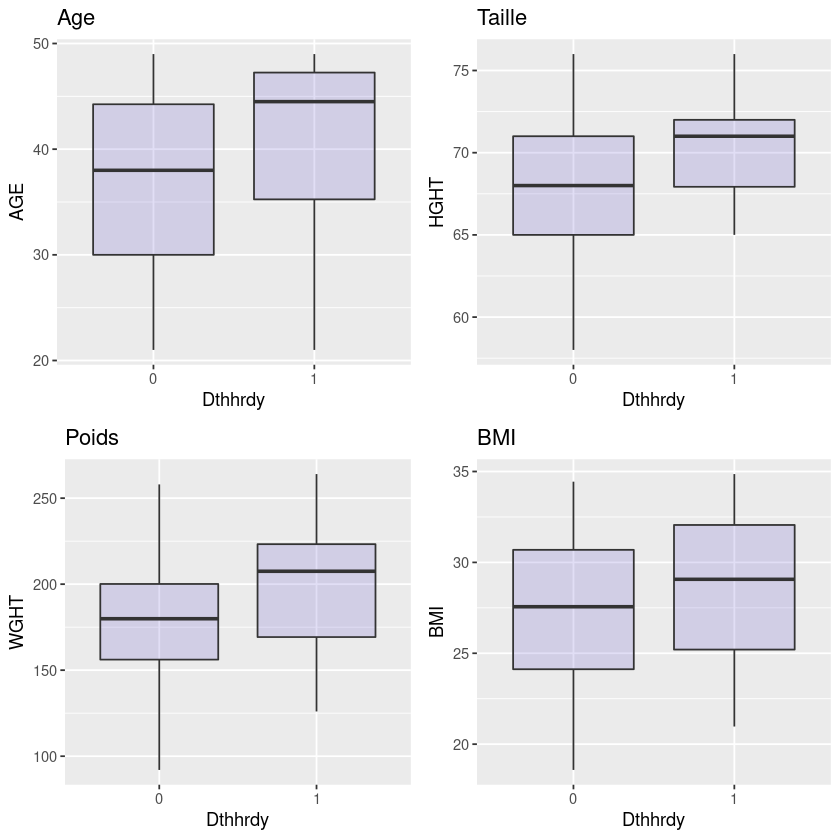

In [23]:
# Boxplots avec les différentes variables en fct de sex
p1 <- ggplot(cd,aes(x=as.factor(DTHHRDY), y=AGE)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + ggtitle("Age") + 
    xlab("Dthhrdy")
p2 <- ggplot(cd,aes(x=as.factor(DTHHRDY), y=HGHT)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + 
    xlab("Dthhrdy") + ggtitle("Taille")

p3 <- ggplot(cd,aes(x=as.factor(DTHHRDY), y=WGHT)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + 
    xlab("Dthhrdy") + ggtitle("Poids")
p4 <- ggplot(cd,aes(x=as.factor(DTHHRDY), y=BMI)) + 
    geom_boxplot(fill="slateblue", alpha=0.2) + 
    xlab("Dthhrdy") + ggtitle("BMI")

grid.arrange(p1,p2,p3,p4, ncol=2)

In [26]:
# 2 nouveaux dataframes : hardy 0 et 1
hd0 <- filter(cd, DTHHRDY == 0)
hd1 <- filter(cd, DTHHRDY == 1)

#unpaired two-samples Wilcoxon test =  Wilcoxon rank sum test = Mann-Whitney test
# Calcul des tests de Mann-Whitney pour les différentes variables :

w_age <- wilcox.test(hd0$AGE, hd1$AGE)$p.value
w_hght <- wilcox.test(hd0$HGHT, hd1$HGHT)$p.value
w_wght <- wilcox.test(hd0$WGHT, hd1$WGHT)$p.value
w_bmi <- wilcox.test(hd0$BMI, hd1$BMI)$p.value

print(paste('p-value for age : ', toString(w_age)))
print(paste('p-value for hght : ', toString(w_hght)))
print(paste('p-value for wght : ', toString(w_wght)))
print(paste('p-value for bmi : ', toString(w_bmi)))

[1] "p-value for age :  0.0281955890446734"
[1] "p-value for hght :  0.00422709674948223"
[1] "p-value for wght :  0.00692956857751305"
[1] "p-value for bmi :  0.195035914673178"


#### Temps ischémique

In [27]:
print(cor(cd$TRISCHD, cd$WGHT))
print(cor(cd$TRISCHD, cd$HGHT))
print(cor(cd$TRISCHD, cd$BMI))
print(cor(cd$TRISCHD, cd$AGE))

[1] 0.1618026
[1] 0.1561814
[1] 0.07390289
[1] 0.1382645


# Question 2 

In [28]:
new_cohort <- replace(cd$COHORT, cd$COHORT=='Organ Donor (OPO)', 'Organ_Donor')
cd$COHORT <- new_cohort

In [29]:
#normalisation pour les variables numériques et changement de type pour les variable catégorielles 
numerical_variables <- list('AGE', 'HGHT', 'WGHT', 'BMI', 'TRISCHD') 
categorical_variables <- list('SEX', 'COHORT', 'DTHHRDY')
for (variable in numerical_variables){
    cd[variable] <- scale(cd[variable])
}
for (variable in categorical_variables){
    cd[variable] <- factor(cd[[variable]])
}

## Analyse de l'expression différentielle

### Création du dataframe assoc_table

In [30]:
#assoc_table va être une matrice dont les lignes correspondent aux variables cliniques et les colonnes aux clusters
#les éléments de la matrice décrivent l'association entre les variables et les clusters
#on extrait les noms des variables cliniques et des clusters pour les définir comme noms des lignes et colonnes d'assoc_table
row <- colnames(cd)[2:10]
row <- row[-6]

col <- colnames(mc[,2:65])
assoc_table <- data.frame(matrix(ncol = 64, nrow = 8))
colnames(assoc_table) <- col
rownames(assoc_table) <- row
#Tous les éléments d'assoc_table sont FALSE et vont être changés en True au fur et à mesure que les associations sont déterminées
assoc_table[,] <- 0
assoc_table

Mophological.cluster.0 Mophological.cluster.1 Mophological.cluster.2
SEX     0                      0                      0                     
AGE     0                      0                      0                     
HGHT    0                      0                      0                     
WGHT    0                      0                      0                     
BMI     0                      0                      0                     
COHORT  0                      0                      0                     
TRISCHD 0                      0                      0                     
DTHHRDY 0                      0                      0                     
        Mophological.cluster.3 Mophological.cluster.4 Mophological.cluster.5
SEX     0                      0                      0                     
AGE     0                      0                      0                     
HGHT    0                      0                      0                     
WGHT    0                      0                      0                     
BMI     0                      0                      0                     
COHORT  0                      0                      0                     
TRISCHD 0                      0                      0                     
DTHHRDY 0                      0                      0                     
        Mophological.cluster.6 Mophological.cluster.7 Mophological.cluster.8
SEX     0                      0                      0                     
AGE     0                      0                      0                     
HGHT    0                      0                      0                     
WGHT    0                      0                      0                     
BMI     0                      0                      0                     
COHORT  0                      0                      0                     
TRISCHD 0                      0                      0                     
DTHHRDY 0                      0                      0                     
        Mophological.cluster.9 ⋯ Mophological.cluster.54
SEX     0                      ⋯ 0                      
AGE     0                      ⋯ 0                      
HGHT    0                      ⋯ 0                      
WGHT    0                      ⋯ 0                      
BMI     0                      ⋯ 0                      
COHORT  0                      ⋯ 0                      
TRISCHD 0                      ⋯ 0                      
DTHHRDY 0                      ⋯ 0                      
        Mophological.cluster.55 Mophological.cluster.56 Mophological.cluster.57
SEX     0                       0                       0                      
AGE     0                       0                       0                      
HGHT    0                       0                       0                      
WGHT    0                       0                       0                      
BMI     0                       0                       0                      
COHORT  0                       0                       0                      
TRISCHD 0                       0                       0                      
DTHHRDY 0                       0                       0                      
        Mophological.cluster.58 Mophological.cluster.59 Mophological.cluster.60
SEX     0                       0                       0                      
AGE     0                       0                       0                      
HGHT    0                       0                       0                      
WGHT    0                       0                       0                      
BMI     0                       0                       0                      
COHORT  0                       0                       0                      
TRISCHD 0                       0                       0                      
DTHHRDY 0                       0                       

### Fonction pour remplir une colonne d'assoc_table

In [31]:
fill_assoc_table <- function(resSig, cond){
    names = rownames(resSig)
    lfc = resSig$log2FoldChange
    for(i in 1:length(names)){
        name = names[i]
        #print(name)
        assoc_table[cond,][name] <<- lfc[i]
        }        
    }



### Sex

In [32]:
#création de l'objet deseq dataset
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ SEX)
# calcul des expressions différentielles
dds <- DESeq(dds, quiet=TRUE)
res <- results(dds)
#sélection des clusters pour lesquels les p values et les pvalues ajustées sont inférieures à 0.05
res.05 <- results(dds, alpha = 0.05)
resSig <- subset(res, padj < 0.05)
resSig
fill_assoc_table(resSig, "SEX")

converting counts to integer mode



log2 fold change (MLE): SEX 2 vs 1 
Wald test p-value: SEX 2 vs 1 
DataFrame with 7 rows and 6 columns
                         baseMean log2FoldChange     lfcSE      stat
                        <numeric>      <numeric> <numeric> <numeric>
Mophological.cluster.18   79.0266       1.053218  0.268311   3.92536
Mophological.cluster.28  154.2311       0.611144  0.215170   2.84029
Mophological.cluster.29   71.3152       0.672496  0.225778   2.97857
Mophological.cluster.36  116.7020       2.803487  0.460505   6.08786
Mophological.cluster.38   92.7315       1.073725  0.294151   3.65026
Mophological.cluster.42  108.5923       1.816409  0.393394   4.61728
Mophological.cluster.57  114.7111       0.944129  0.282605   3.34081
                             pvalue        padj
                          <numeric>   <numeric>
Mophological.cluster.18 8.65987e-05 1.81857e-03
Mophological.cluster.28 4.50729e-03 4.05656e-02
Mophological.cluster.29 2.89601e-03 3.04081e-02
Mophological.cluster.36 1.14432e-09 

### Hardy

In [33]:
#Il a ete choisi de rassembler les categories de l'echelle de Hardy en 2 categories : 1 correspond aux morts rapides (1 et 2) et 0 aux morts plus lentes (0,3 et 4)
levels(cd$DTHHRDY)[levels(cd$DTHHRDY)=="2"] <-"1"
levels(cd$DTHHRDY)[levels(cd$DTHHRDY)=="3"] <-"0"
levels(cd$DTHHRDY)[levels(cd$DTHHRDY)=="4"] <-"0"

In [34]:
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ DTHHRDY)
dds <- DESeq(dds, quiet=TRUE)
res <- results(dds)
res.05 <- results(dds, alpha = 0.05)
#table(res.05$padj < 0.05)
resSig <- subset(res, padj < 0.05)
#resSig[ order(resSig$log2FoldChange), ]
fill_assoc_table(resSig, "DTHHRDY")
#print(assoc_table['DTHHRDY',])

converting counts to integer mode



### Cohort

In [35]:
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ COHORT)
dds <- DESeq(dds, quiet=TRUE)
res <- results(dds)
res.05 <- results(dds, alpha = 0.05)
#table(res.05$padj < 0.05)
resSig <- subset(res, padj < 0.05)
#resSig[ order(resSig$log2FoldChange), ]
fill_assoc_table(resSig, "COHORT")
#print(assoc_table['COHORT',])

converting counts to integer mode



### Numerical variables

In [36]:
#fonction pour remplir la ligne du tableau 'assoc_table' associée avec une variable clinique numérique, dont le nom est donné dans l'argument "condition"
num_dif_exp <- function(condition, assoc_table){
    cond <- as.formula(paste("~", condition))
    print(cond)
    dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = cond)
    dds <- DESeq(dds, quiet=TRUE)
    res <- results(dds)
    res.05 <- results(dds, alpha = 0.05)
    resSig <- subset(res, padj < 0.05)
    #print(rownames(resSig))
    fill_assoc_table(resSig, condition)
}

In [37]:
for(variable in numerical_variables){
    num_dif_exp(variable, assoc_table)}

~AGE
<environment: 0x55b1cf913d18>


converting counts to integer mode



~HGHT
<environment: 0x55b1cfc9b538>


converting counts to integer mode



~WGHT
<environment: 0x55b1c4767f58>


converting counts to integer mode



~BMI
<environment: 0x55b1d5875be0>


converting counts to integer mode



~TRISCHD
<environment: 0x55b1c4798ac8>


converting counts to integer mode



### Trouver les clusters jamais différentiellement exprimés

In [38]:
cluster_sums = colSums(assoc_table)

In [39]:
zeros_clusters = cluster_sums[cluster_sums == 0]
zeros_clusters

Mophological.cluster.8 Mophological.cluster.11 Mophological.cluster.13 
                      0                       0                       0 
Mophological.cluster.22 Mophological.cluster.24 Mophological.cluster.30 
                      0                       0                       0 
Mophological.cluster.31 Mophological.cluster.37 Mophological.cluster.53 
                      0                       0                       0 
Mophological.cluster.55 
                      0

In [40]:
reduced_assoc_table <- assoc_table
for (cluster in colnames(assoc_table)){
    if (sum(assoc_table[cluster]) == 0){
        reduced_assoc_table[cluster] = NULL
    }
}
colnames(reduced_assoc_table)

[1] "Mophological.cluster.0"  "Mophological.cluster.1" 
 [3] "Mophological.cluster.2"  "Mophological.cluster.3" 
 [5] "Mophological.cluster.4"  "Mophological.cluster.5" 
 [7] "Mophological.cluster.6"  "Mophological.cluster.7" 
 [9] "Mophological.cluster.9"  "Mophological.cluster.10"
[11] "Mophological.cluster.12" "Mophological.cluster.14"
[13] "Mophological.cluster.15" "Mophological.cluster.16"
[15] "Mophological.cluster.17" "Mophological.cluster.18"
[17] "Mophological.cluster.19" "Mophological.cluster.20"
[19] "Mophological.cluster.21" "Mophological.cluster.23"
[21] "Mophological.cluster.25" "Mophological.cluster.26"
[23] "Mophological.cluster.27" "Mophological.cluster.28"
[25] "Mophological.cluster.29" "Mophological.cluster.32"
[27] "Mophological.cluster.33" "Mophological.cluster.34"
[29] "Mophological.cluster.35" "Mophological.cluster.36"
[31] "Mophological.cluster.38" "Mophological.cluster.39"
[33] "Mophological.cluster.40" "Mophological.cluster.41"
[35] "Mophological.cluster.42" "Mophological.cluster.43"
[37] "Mophological.cluster.44" "Mophological.cluster.45"
[39] "Mophological.cluster.46" "Mophological.cluster.47"
[41] "Mophological.cluster.48" "Mophological.cluster.49"
[43] "Mophological.cluster.50" "Mophological.cluster.51"
[45] "Mophological.cluster.52" "Mophological.cluster.54"
[47] "Mophological.cluster.56" "Mophological.cluster.57"
[49] "Mophological.cluster.58" "Mophological.cluster.59"
[51] "Mophological.cluster.60" "Mophological.cluster.61"
[53] "Mophological.cluster.62" "Mophological.cluster.63"

### Representation d'assoc_table sous forme de heatmap

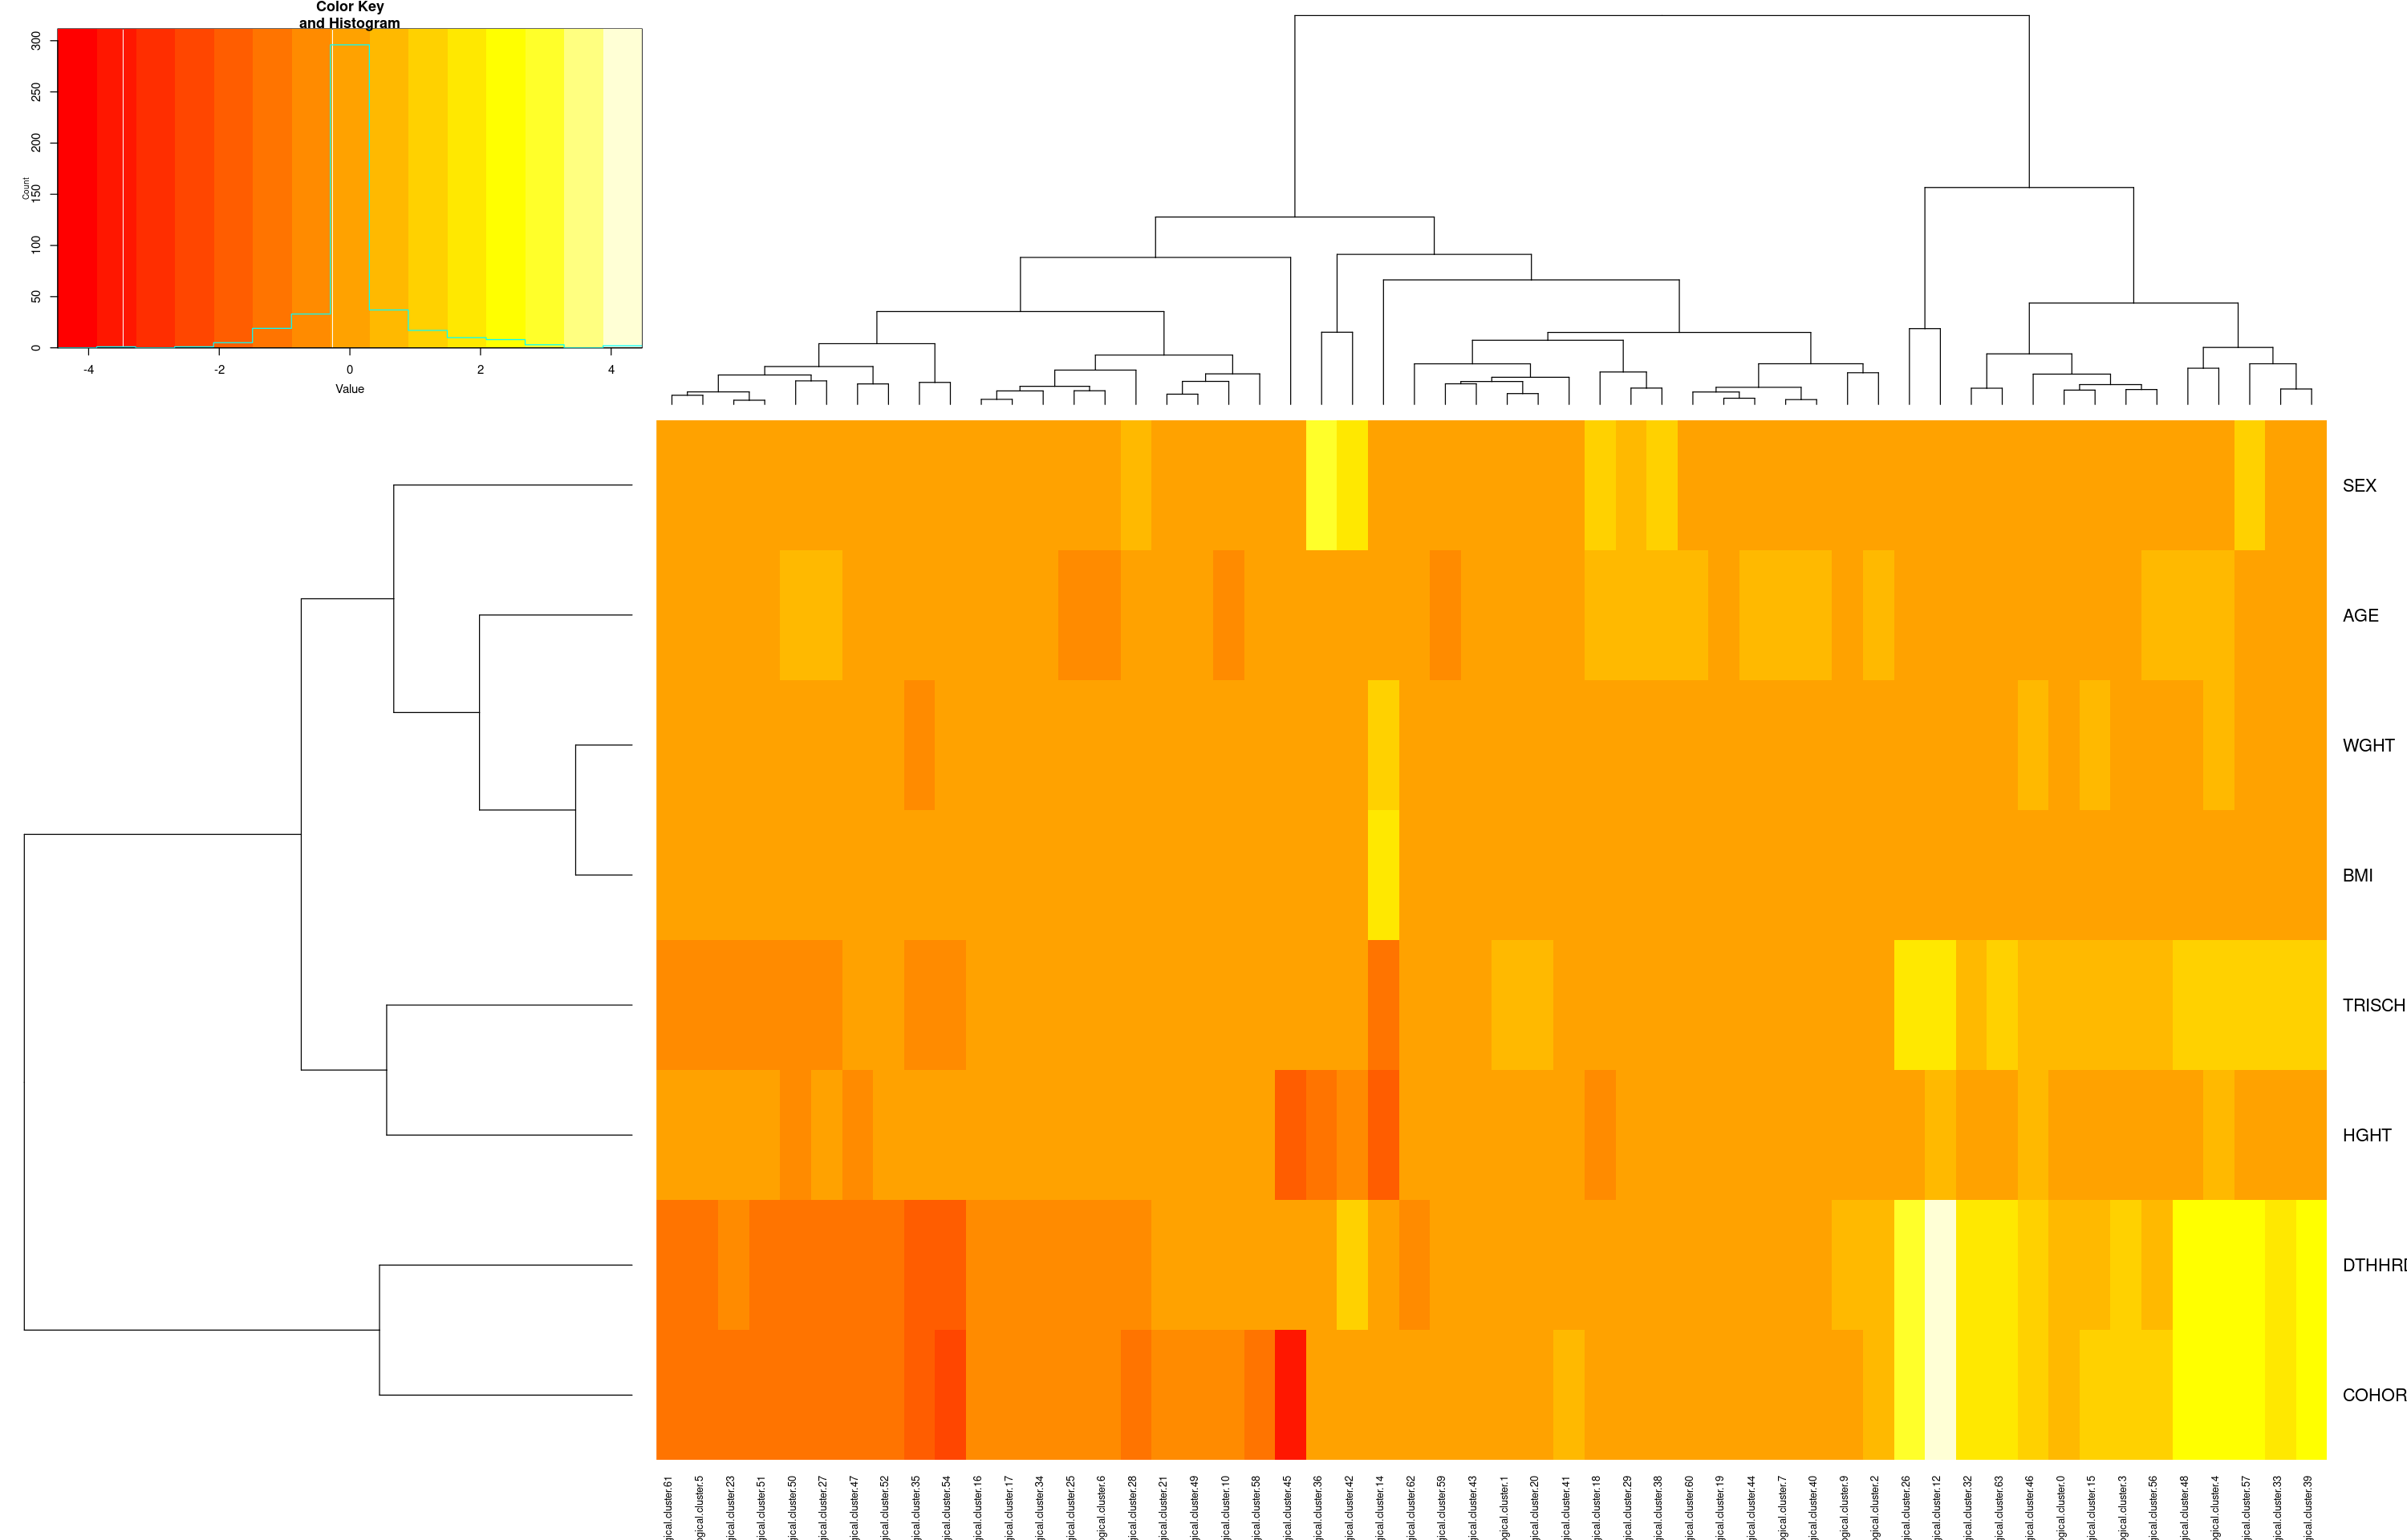

In [41]:
options(repr.plot.width=25, repr.plot.height=16)
heatmap.2(data.matrix(reduced_assoc_table), scale='none', trace='none')

### Clusters les plus sur et sous exprimés pour chaque variable

In [42]:
for (name in rownames(assoc_table)){
    line = assoc_table[name,]
    a = line[which(line==max(line))]
    b = line[which(line==min(line))]
    print(a)
    print(b)
    print('-------------------------')
}

    Mophological.cluster.36
SEX                2.803487
    Mophological.cluster.0 Mophological.cluster.1 Mophological.cluster.2
SEX                      0                      0                      0
    Mophological.cluster.3 Mophological.cluster.4 Mophological.cluster.5
SEX                      0                      0                      0
    Mophological.cluster.6 Mophological.cluster.7 Mophological.cluster.8
SEX                      0                      0                      0
    Mophological.cluster.9 Mophological.cluster.10 Mophological.cluster.11
SEX                      0                       0                       0
    Mophological.cluster.12 Mophological.cluster.13 Mophological.cluster.14
SEX                       0                       0                       0
    Mophological.cluster.15 Mophological.cluster.16 Mophological.cluster.17
SEX                       0                       0                       0
    Mophological.cluster.19 Mophological.cluster.20 

### Barplots des variables et clusters

In [43]:
binary <- function(x){
    return(x!=0)
}
binary_table <- reduced_assoc_table
for (cluster in colnames(reduced_assoc_table)){
    binary_table[cluster] = lapply(binary_table[cluster], binary)
}
binary_table

Mophological.cluster.0 Mophological.cluster.1 Mophological.cluster.2
SEX     FALSE                  FALSE                  FALSE                 
AGE     FALSE                   TRUE                   TRUE                 
HGHT    FALSE                  FALSE                  FALSE                 
WGHT    FALSE                  FALSE                  FALSE                 
BMI     FALSE                  FALSE                  FALSE                 
COHORT   TRUE                  FALSE                   TRUE                 
TRISCHD  TRUE                   TRUE                  FALSE                 
DTHHRDY  TRUE                  FALSE                   TRUE                 
        Mophological.cluster.3 Mophological.cluster.4 Mophological.cluster.5
SEX     FALSE                  FALSE                  FALSE                 
AGE     FALSE                   TRUE                  FALSE                 
HGHT    FALSE                   TRUE                  FALSE                 
WGHT    FALSE                   TRUE                  FALSE                 
BMI     FALSE                  FALSE                  FALSE                 
COHORT   TRUE                   TRUE                   TRUE                 
TRISCHD  TRUE                   TRUE                   TRUE                 
DTHHRDY  TRUE                   TRUE                   TRUE                 
        Mophological.cluster.6 Mophological.cluster.7 Mophological.cluster.9
SEX     FALSE                  FALSE                  FALSE                 
AGE      TRUE                   TRUE                  FALSE                 
HGHT    FALSE                  FALSE                  FALSE                 
WGHT    FALSE                  FALSE                  FALSE                 
BMI     FALSE                  FALSE                  FALSE                 
COHORT   TRUE                  FALSE                  FALSE                 
TRISCHD FALSE                  FALSE                  FALSE                 
DTHHRDY  TRUE                  FALSE                   TRUE                 
        Mophological.cluster.10 ⋯ Mophological.cluster.52
SEX     FALSE                   ⋯ FALSE                  
AGE      TRUE                   ⋯ FALSE                  
HGHT    FALSE                   ⋯ FALSE                  
WGHT    FALSE                   ⋯ FALSE                  
BMI     FALSE                   ⋯ FALSE                  
COHORT   TRUE                   ⋯  TRUE                  
TRISCHD FALSE                   ⋯ FALSE                  
DTHHRDY FALSE                   ⋯  TRUE                  
        Mophological.cluster.54 Mophological.cluster.56 Mophological.cluster.57
SEX     FALSE                   FALSE                    TRUE                  
AGE     FALSE                    TRUE                   FALSE                  
HGHT    FALSE                   FALSE                   FALSE                  
WGHT    FALSE                   FALSE                   FALSE                  
BMI     FALSE                   FALSE                   FALSE                  
COHORT   TRUE                    TRUE                    TRUE                  
TRISCHD  TRUE                    TRUE                    TRUE                  
DTHHRDY  TRUE                    TRUE                    TRUE                  
        Mophological.cluster.58 Mophological.cluster.59 Mophological.cluster.60
SEX     FALSE                   FALSE                   FALSE                  
AGE     FALSE                    TRUE                    TRUE                  
HGHT    FALSE                   FALSE                   FALSE                  
WGHT    FALSE                   FALSE                   FALSE                  
BMI     FALSE                   FALSE                   FALSE                  
COHORT   TRUE                   FALSE                   FALSE                  
TRISCHD FALSE                   FALSE                    TRUE                  
DTHHRDY FALSE                   FALSE          

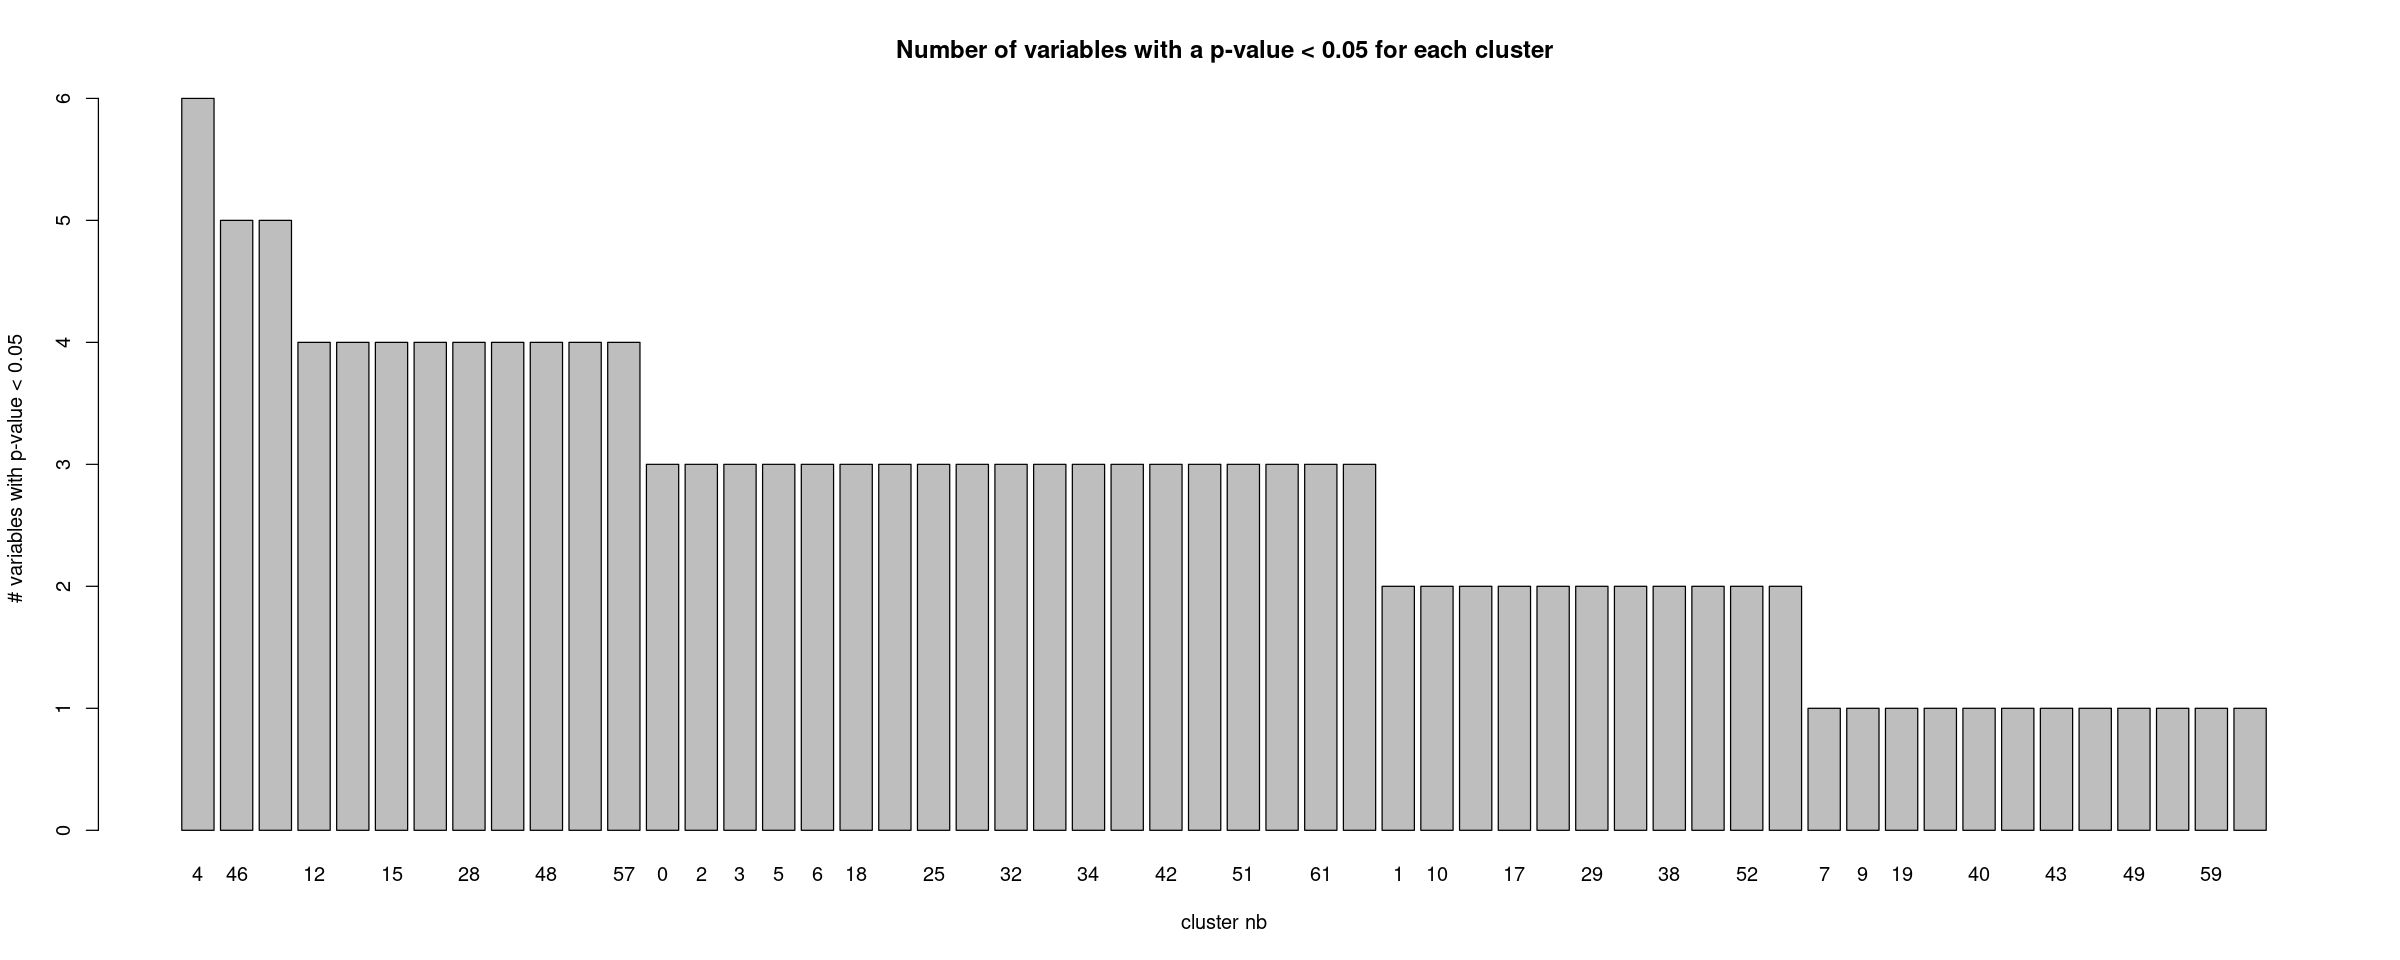

In [44]:
cluster_var = colSums(binary_table)
x <- names(cluster_var)
names(cluster_var) <- substr(x, 22, nchar(x))
options(repr.plot.width=20, repr.plot.height=8)
barplot(sort(cluster_var, decreasing=TRUE), xlab='cluster nb', ylab='# variables with p-value < 0.05', main='Number of variables with a p-value < 0.05 for each cluster')


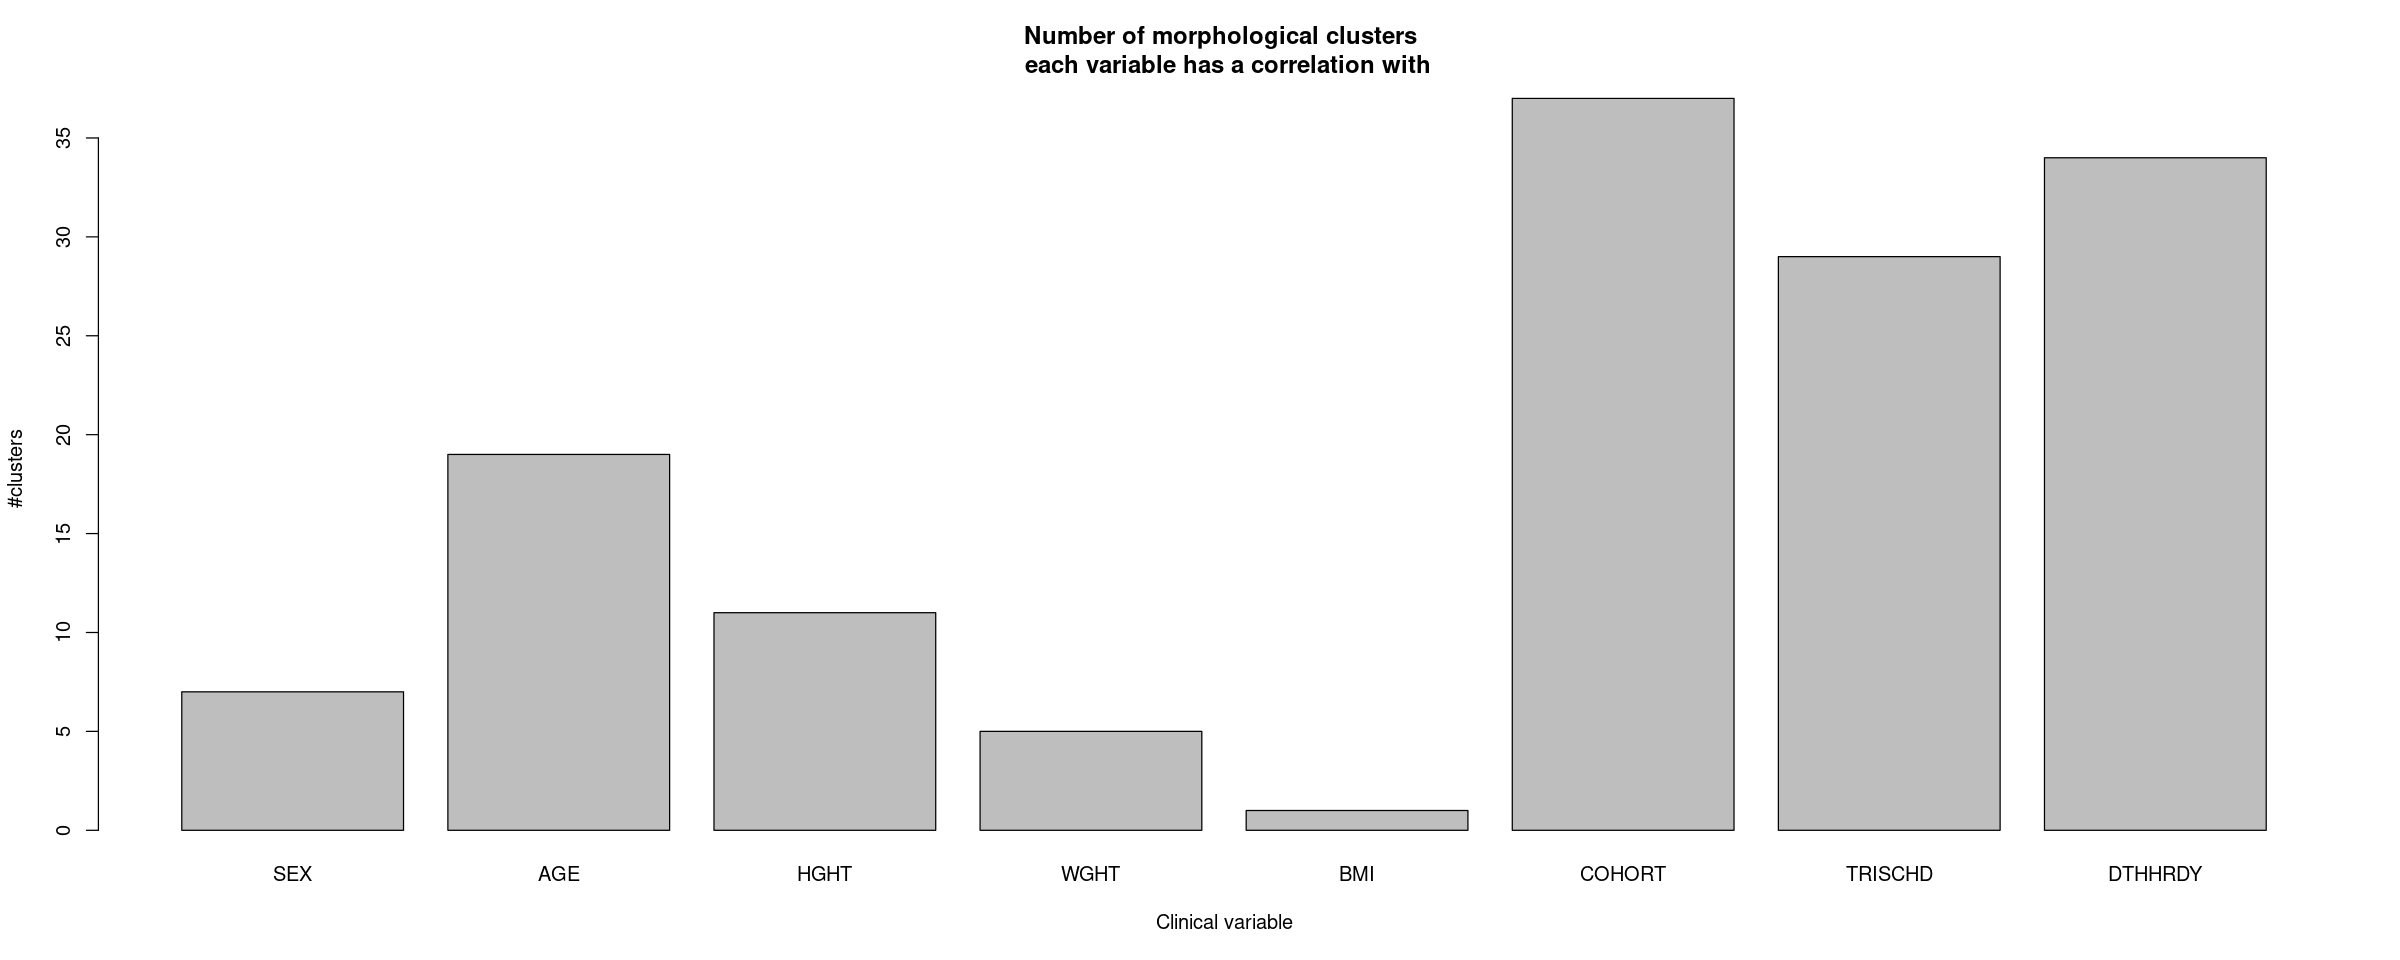

In [45]:
variable_var <- rowSums(binary_table)
barplot(variable_var, main='Number of morphological clusters \n each variable has a correlation with', xlab='Clinical variable', ylab='#clusters')

In [46]:
variable_var

SEX     AGE    HGHT    WGHT     BMI  COHORT TRISCHD DTHHRDY 
      7      19      11       5       1      37      29      34

### Controle pour les variables confondantes

In [47]:
#assoc_table va être une matrice dont les lignes correspondent aux variables cliniques et les colonnes aux clusters
#les éléments de la matrice décrivent l'association entre les variables et les clusters
#on extrait les noms des variables cliniques et des clusters pour les définir comme noms des lignes et colonnes d'assoc_table
row <- colnames(cd)[2:7]
row <- row[-6]

col <- colnames(mc[,2:65])
assoc_table <- data.frame(matrix(ncol = 64, nrow = 5))
colnames(assoc_table) <- col
rownames(assoc_table) <- row
#Tous les éléments d'assoc_table sont FALSE et vont être changés en True au fur et à mesure que les associations sont déterminées
assoc_table[,] <- 0

In [48]:
#creating the dataset object
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ SEX)
# computation of differential expressions
dds <- DESeq(dds, quiet=TRUE)
res <- results(dds)
#selection of clusters with adjusted p-values < 0.05
resSig <- subset(res, padj < 0.05)
resSig
fill_assoc_table(resSig, "SEX")

converting counts to integer mode



log2 fold change (MLE): SEX 2 vs 1 
Wald test p-value: SEX 2 vs 1 
DataFrame with 7 rows and 6 columns
                         baseMean log2FoldChange     lfcSE      stat
                        <numeric>      <numeric> <numeric> <numeric>
Mophological.cluster.18   79.0266       1.053218  0.268311   3.92536
Mophological.cluster.28  154.2311       0.611144  0.215170   2.84029
Mophological.cluster.29   71.3152       0.672496  0.225778   2.97857
Mophological.cluster.36  116.7020       2.803487  0.460505   6.08786
Mophological.cluster.38   92.7315       1.073725  0.294151   3.65026
Mophological.cluster.42  108.5923       1.816409  0.393394   4.61728
Mophological.cluster.57  114.7111       0.944129  0.282605   3.34081
                             pvalue        padj
                          <numeric>   <numeric>
Mophological.cluster.18 8.65987e-05 1.81857e-03
Mophological.cluster.28 4.50729e-03 4.05656e-02
Mophological.cluster.29 2.89601e-03 3.04081e-02
Mophological.cluster.36 1.14432e-09 

#### Age

In [49]:
#creating the dataset object
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ AGE + COHORT + DTHHRDY)
# computation of differential expressions
dds <- DESeq(dds, quiet=TRUE)
res <- results(dds)
#selection of clusters with adjusted p-values < 0.05
resSig <- subset(res, padj < 0.05)
resSig
fill_assoc_table(resSig, "AGE")

converting counts to integer mode



log2 fold change (MLE): DTHHRDY 1 vs 0 
Wald test p-value: DTHHRDY 1 vs 0 
DataFrame with 2 rows and 6 columns
                         baseMean log2FoldChange     lfcSE      stat
                        <numeric>      <numeric> <numeric> <numeric>
Mophological.cluster.12   103.787        3.04038  0.769065   3.95334
Mophological.cluster.42   156.590        2.71942  0.800105   3.39883
                             pvalue       padj
                          <numeric>  <numeric>
Mophological.cluster.12 7.70682e-05 0.00493237
Mophological.cluster.42 6.76747e-04 0.02165591

In [50]:
#creating the dataset object
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ WGHT + COHORT + DTHHRDY)
# computation of differential expressions
dds <- DESeq(dds, quiet=TRUE)
res <- results(dds)
#selection of clusters with adjusted p-values < 0.05
resSig <- subset(res, padj < 0.05)
resSig
fill_assoc_table(resSig, "WGHT")

converting counts to integer mode



log2 fold change (MLE): DTHHRDY 1 vs 0 
Wald test p-value: DTHHRDY 1 vs 0 
DataFrame with 3 rows and 6 columns
                         baseMean log2FoldChange     lfcSE      stat
                        <numeric>      <numeric> <numeric> <numeric>
Mophological.cluster.12  103.7865        3.00003  0.793957   3.77858
Mophological.cluster.26   83.3441        2.04034  0.633833   3.21904
Mophological.cluster.42  156.5901        2.74649  0.813590   3.37577
                             pvalue      padj
                          <numeric> <numeric>
Mophological.cluster.12 0.000157727 0.0102523
Mophological.cluster.26 0.001286199 0.0278676
Mophological.cluster.42 0.000736097 0.0239231

In [51]:
#creating the dataset object
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ HGHT + DTHHRDY)
# computation of differential expressions
dds <- DESeq(dds, quiet=TRUE)
res <- results(dds)
#selection of clusters with adjusted p-values < 0.05
resSig <- subset(res, padj < 0.05)
resSig
fill_assoc_table(resSig, "HGHT")

converting counts to integer mode



log2 fold change (MLE): DTHHRDY 1 vs 0 
Wald test p-value: DTHHRDY 1 vs 0 
DataFrame with 32 rows and 6 columns
                         baseMean log2FoldChange     lfcSE      stat
                        <numeric>      <numeric> <numeric> <numeric>
Mophological.cluster.0    105.492       0.838611  0.246643   3.40010
Mophological.cluster.2    117.178       0.729846  0.313570   2.32754
Mophological.cluster.3    125.283       1.109737  0.285266   3.89019
Mophological.cluster.4    119.062       2.070450  0.413470   5.00750
Mophological.cluster.5    185.332      -0.991431  0.277713  -3.56999
...                           ...            ...       ...       ...
Mophological.cluster.56   70.4774       0.708172  0.310494   2.28079
Mophological.cluster.57  114.7111       2.401254  0.319626   7.51270
Mophological.cluster.61  139.2785      -1.000215  0.352753  -2.83545
Mophological.cluster.62  152.6477      -0.833560  0.330066  -2.52544
Mophological.cluster.63  136.0940       1.661125  0.368211  

In [52]:
#creating the dataset object
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ BMI)
# computation of differential expressions
dds <- DESeq(dds, quiet=TRUE)
res <- results(dds)
#selection of clusters with adjusted p-values < 0.05
resSig <- subset(res, padj < 0.05)
resSig
fill_assoc_table(resSig, "BMI")

converting counts to integer mode



log2 fold change (MLE): BMI 
Wald test p-value: BMI 
DataFrame with 1 row and 6 columns
                         baseMean log2FoldChange     lfcSE      stat
                        <numeric>      <numeric> <numeric> <numeric>
Mophological.cluster.14   22.8728        1.74804  0.231951   7.53623
                             pvalue        padj
                          <numeric>   <numeric>
Mophological.cluster.14 4.83747e-14 3.14436e-12

In [53]:
#creating the dataset object
dds = DESeqDataSetFromMatrix(t(data.matrix(mc)),colData=cd, design = ~ BMI)
# computation of differential expressions
dds <- DESeq(dds, quiet=TRUE)
res <- results(dds)
#selection of clusters with adjusted p-values < 0.05
resSig <- subset(res, padj < 0.05)
resSig
fill_assoc_table(resSig, "BMI")

converting counts to integer mode



log2 fold change (MLE): BMI 
Wald test p-value: BMI 
DataFrame with 1 row and 6 columns
                         baseMean log2FoldChange     lfcSE      stat
                        <numeric>      <numeric> <numeric> <numeric>
Mophological.cluster.14   22.8728        1.74804  0.231951   7.53623
                             pvalue        padj
                          <numeric>   <numeric>
Mophological.cluster.14 4.83747e-14 3.14436e-12

In [54]:
zeros_clusters = cluster_sums[cluster_sums == 0]
zeros_clusters

Mophological.cluster.8 Mophological.cluster.11 Mophological.cluster.13 
                      0                       0                       0 
Mophological.cluster.22 Mophological.cluster.24 Mophological.cluster.30 
                      0                       0                       0 
Mophological.cluster.31 Mophological.cluster.37 Mophological.cluster.53 
                      0                       0                       0 
Mophological.cluster.55 
                      0

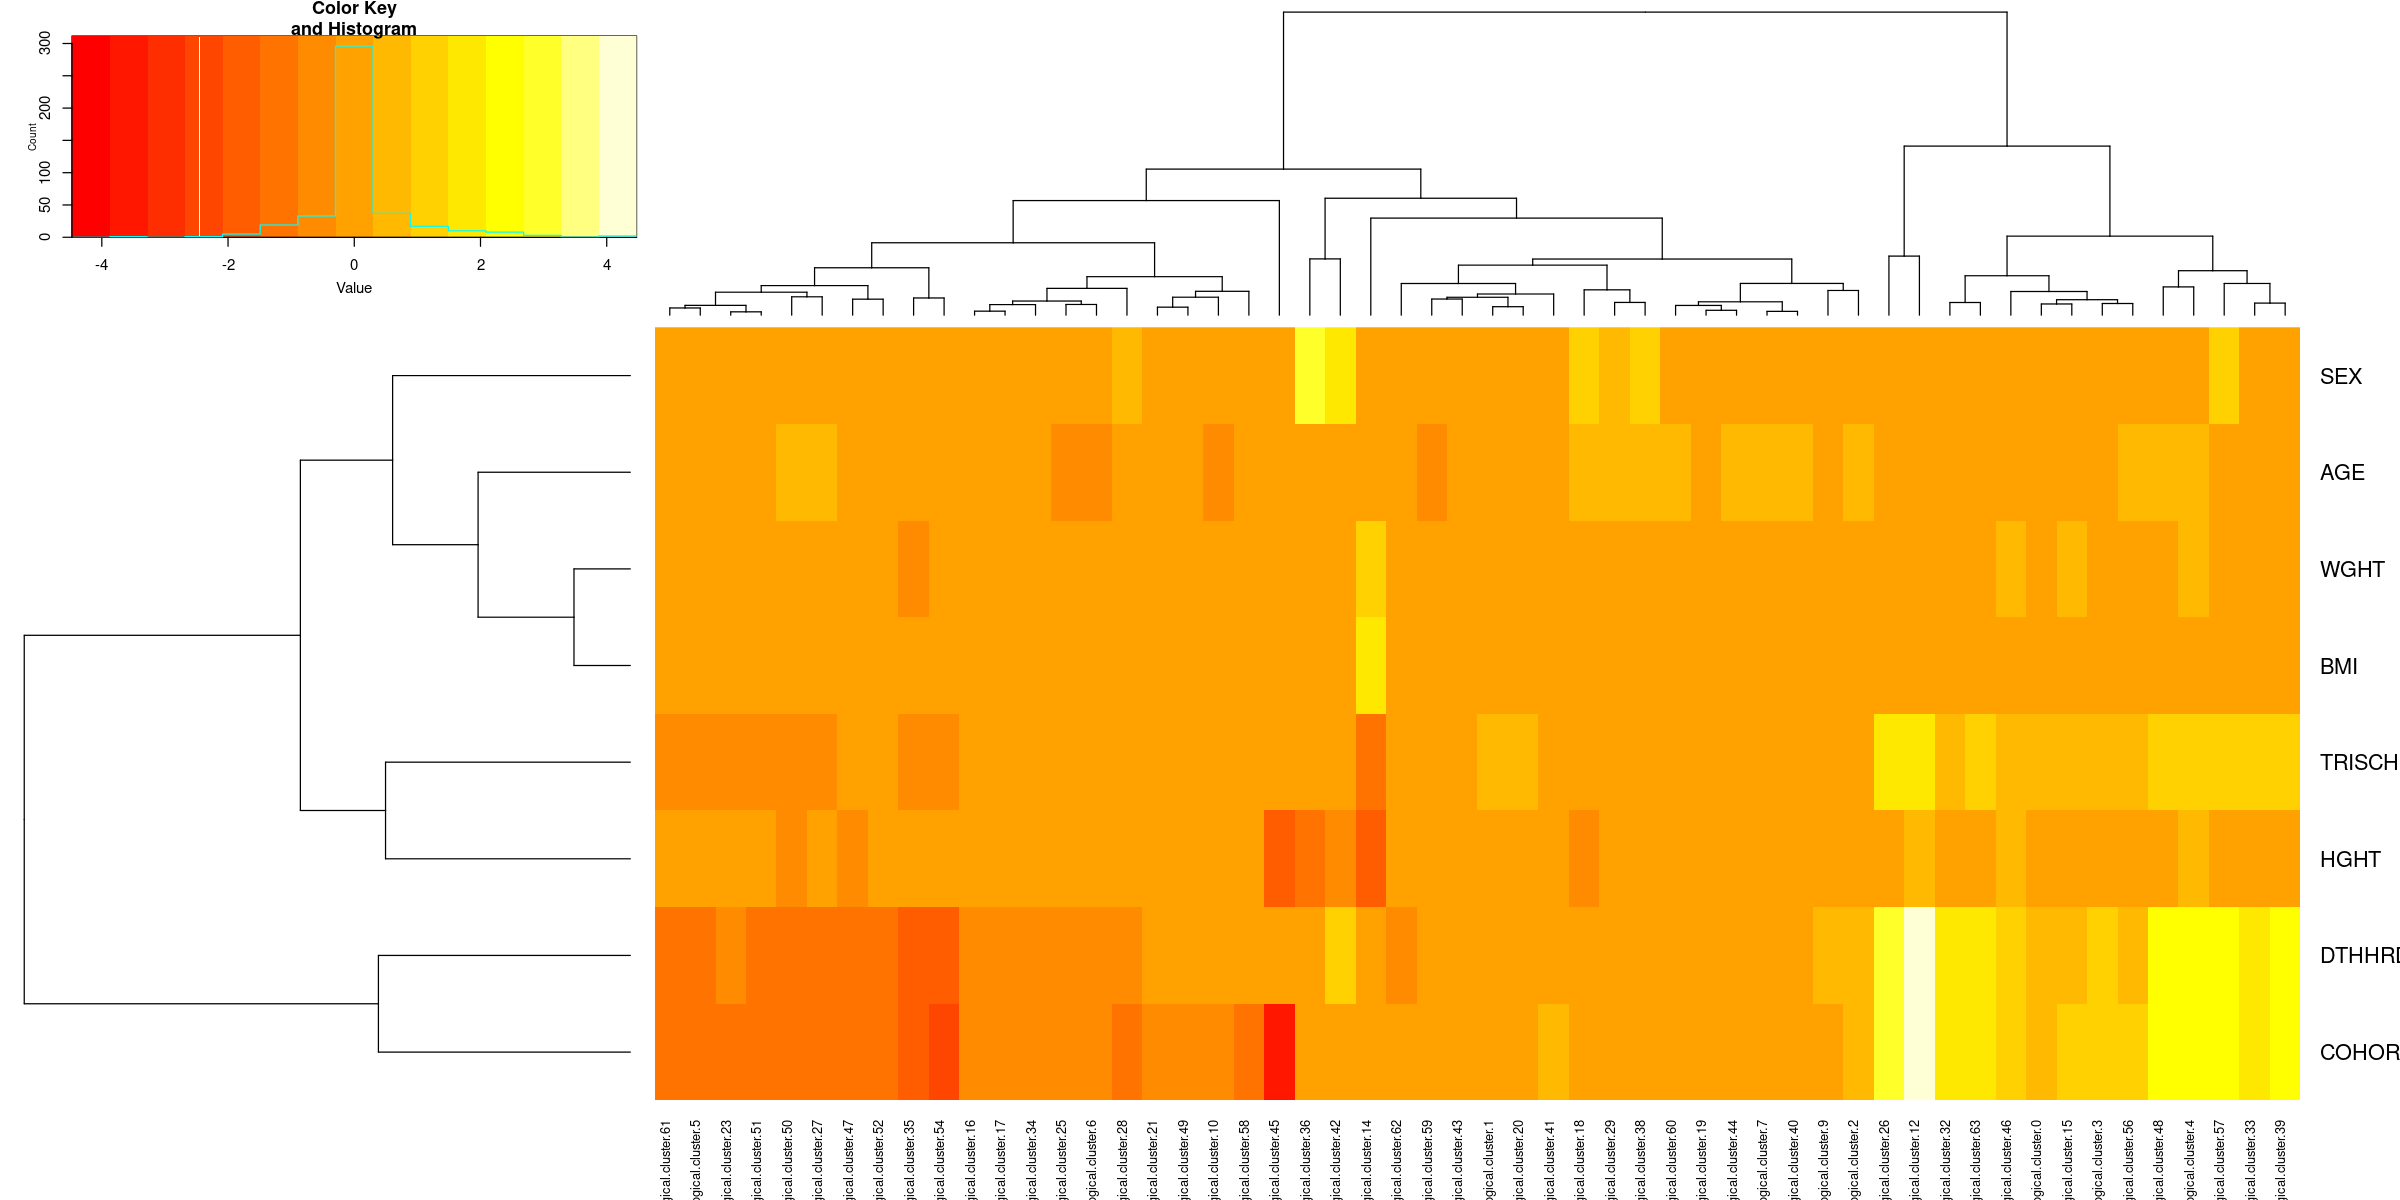

In [55]:
options(repr.plot.width=20, repr.plot.height=10)
#jpeg(file="heatmap1.jpeg")
heatmap.2(data.matrix(reduced_assoc_table), scale='none', trace='none')
#dev.off()

In [56]:
binary_table <- reduced_assoc_table
for (cluster in colnames(reduced_assoc_table)){
    binary_table[cluster] = lapply(binary_table[cluster], binary)
}

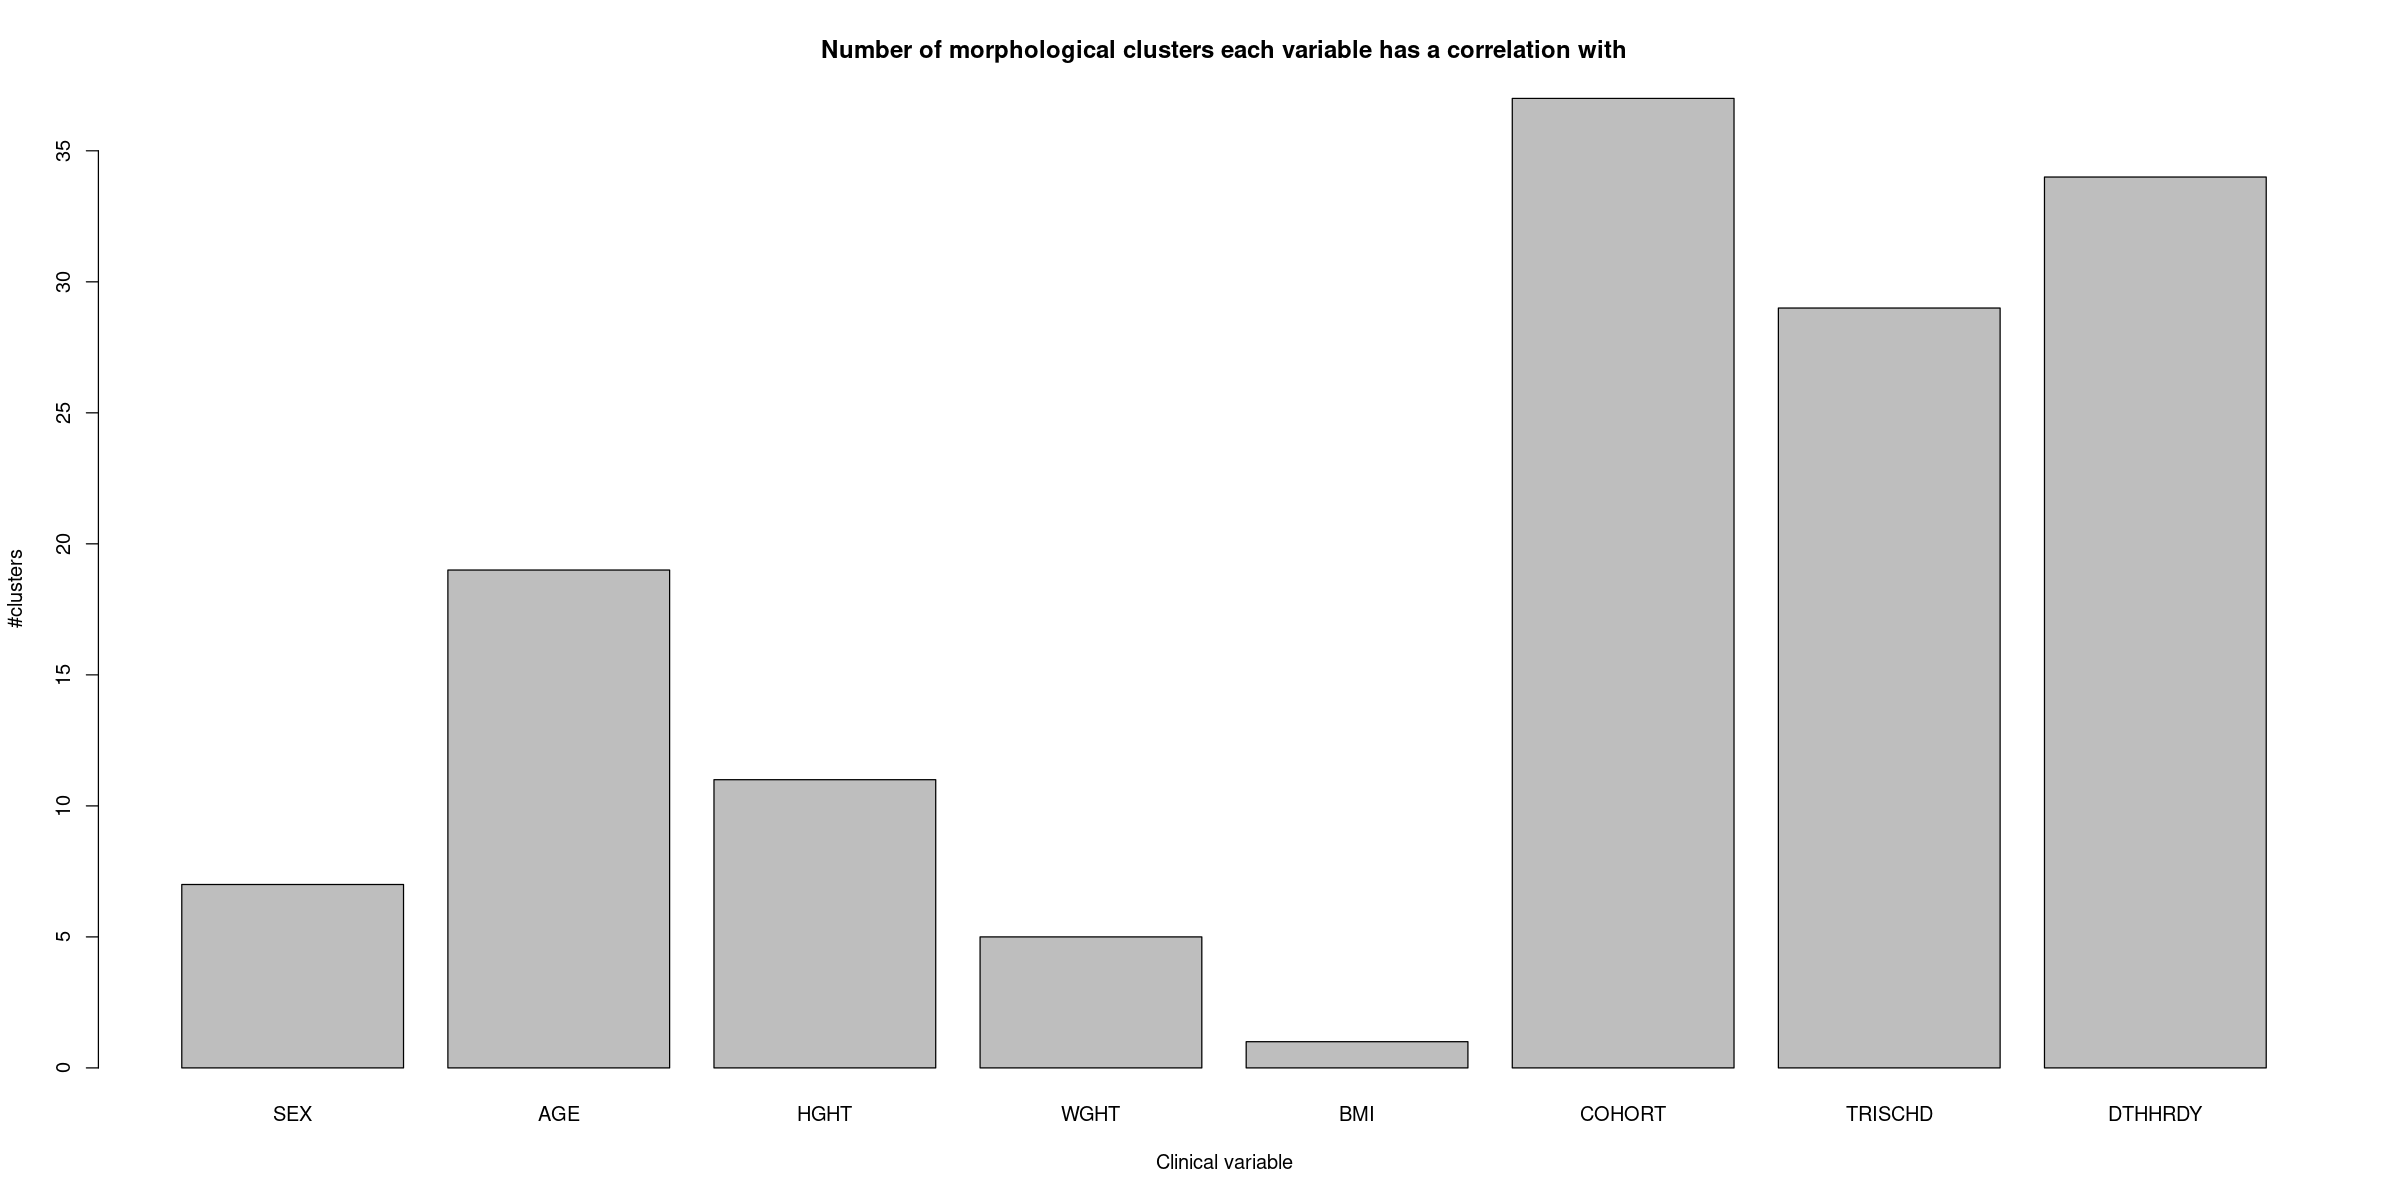

In [57]:
variable_var <- rowSums(binary_table)
barplot(variable_var, main='Number of morphological clusters each variable has a correlation with', xlab='Clinical variable', ylab='#clusters')

In [58]:
variable_var

SEX     AGE    HGHT    WGHT     BMI  COHORT TRISCHD DTHHRDY 
      7      19      11       5       1      37      29      34

# Question 3.1 - Significant down-regulated and up-regulated genes associated with each morphological cluster

In [59]:
#normalization (we use frequency instead of count)
for (i in 1:136){
    mc[i,2:65] <- mc[i,2:65]/sum(mc[i,2:65])
} 

In [125]:
mc$Mophological.cluster.58

[1] 2.532287e-04 8.671523e-04 9.861111e-03 1.523810e-03 5.684181e-03
  [6] 3.400121e-03 1.309929e-02 9.612541e-03 7.944074e-05 3.814367e-04
 [11] 5.670498e-03 2.485913e-03 1.085727e-02 1.032702e-03 4.882379e-03
 [16] 3.678499e-03 0.000000e+00 2.164502e-03 4.601423e-02 8.173273e-05
 [21] 1.125221e-03 1.031661e-02 1.394877e-03 0.000000e+00 1.489203e-04
 [26] 8.168028e-04 2.056555e-04 3.594771e-03 3.699377e-03 0.000000e+00
 [31] 6.178942e-04 6.765053e-02 3.601170e-03 5.453752e-04 2.536140e-04
 [36] 4.312880e-03 3.396595e-02 5.417118e-03 4.186728e-04 2.027071e-03
 [41] 3.171080e-04 6.535948e-03 1.966367e-02 5.316578e-03 4.170790e-03
 [46] 5.088195e-04 1.916627e-03 0.000000e+00 2.033554e-03 4.915817e-03
 [51] 7.597027e-03 2.183406e-03 2.742230e-03 1.774308e-04 4.730658e-03
 [56] 4.065487e-03 6.315789e-03 1.309853e-03 2.319072e-03 9.858692e-04
 [61] 3.471620e-04 0.000000e+00 8.766803e-04 2.429452e-03 7.188703e-03
 [66] 1.315789e-02 3.914178e-03 6.590017e-03 0.000000e+00 1.445319e-03
 [71] 6.879347e-03 1.446809e-02 7.963474e-03 4.250450e-03 8.712181e-04
 [76] 5.267316e-04 9.678980e-04 2.026342e-04 6.963250e-03 4.255319e-03
 [81] 1.845018e-03 2.245677e-04 7.107133e-03 9.844135e-04 1.971969e-02
 [86] 5.328893e-03 1.090173e-03 1.205206e-02 9.327185e-03 5.950905e-03
 [91] 2.457002e-03 0.000000e+00 4.708731e-03 5.360624e-03 2.582073e-03
 [96] 3.418303e-03 6.325265e-03 2.478929e-04 6.699045e-04 1.080692e-03
[101] 1.969733e-02 5.398238e-03 7.863883e-03 1.178550e-03 3.497319e-03
[106] 5.838675e-03 6.965046e-03 4.794644e-03 6.197432e-04 1.630561e-03
[111] 2.046245e-04 6.337136e-04 3.886849e-03 3.432796e-03 7.272727e-03
[116] 1.272628e-02 2.237136e-03 6.928807e-04 8.242664e-03 1.422125e-02
[121] 8.250032e-02 4.477077e-04 8.136792e-03 2.433090e-03 1.413932e-02
[126] 1.885607e-04 9.253139e-04 1.980555e-03 1.620865e-03 4.875000e-03
[131] 1.293693e-02 0.000000e+00 1.794654e-03 1.217434e-03 8.081897e-04
[136] 1.356300e-03

In [60]:
#filtering the data (only take the genes in the top quartile of expression)
rna <- suppressMessages(read_tsv("RNA-read-counts.tsv"))
means <- rowMeans(rna[,3:138])
#med <- median(means)
qt <- quantile(means)[4]
cond <- means > qt
rna$cond <- cond
rna <- rna[rna$cond == TRUE,]
rna

Name               Description   GTEX-11EM3-0126 GTEX-11EQ9-0626
1     ENSG00000227232.5  WASH7P          122             174          
2     ENSG00000279457.4  RP11-34P13.18   241             388          
3     ENSG00000225972.1  MTND1P23        142             120          
4     ENSG00000225630.1  MTND2P28      12884           22597          
5     ENSG00000237973.1  MTCO1P12       3138            3534          
6     ENSG00000229344.1  MTCO2P12        470             537          
7     ENSG00000248527.1  MTATP6P1      52329           78285          
8     ENSG00000198744.5  MTCO3P12        436             782          
9     ENSG00000228327.3  RP11-206L10.2   718             682          
10    ENSG00000228794.8  LINC01128      1382            2099          
11    ENSG00000225880.5  LINC00115       126             224          
12    ENSG00000187634.11 SAMD11          476             905          
13    ENSG00000188976.10 NOC2L          3609            4555          
14    ENSG00000187961.13 KLHL17          670            1510          
15    ENSG00000272512.1  RP11-54O7.17    297             107          
16    ENSG00000188290.10 HES4            441             387          
17    ENSG00000187608.8  ISG15           458             662          
18    ENSG00000188157.14 AGRN          14883           18905          
19    ENSG00000131591.17 C1orf159       1201            1698          
20    ENSG00000272141.1  RP11-465B22.8   265             511          
21    ENSG00000186827.10 TNFRSF4         104              95          
22    ENSG00000078808.16 SDF4          11103           10551          
23    ENSG00000176022.4  B3GALT6        1223            1432          
24    ENSG00000160087.20 UBE2J2         2720            3557          
25    ENSG00000162572.20 SCNN1D          570             754          
26    ENSG00000131584.18 ACAP3          3970            7824          
27    ENSG00000169972.11 PUSL1           389             619          
28    ENSG00000127054.20 INTS11         7127           10364          
29    ENSG00000240731.1  RP5-890O3.9     234             350          
30    ENSG00000224051.6  CPTP           1399            1912          
⋮     ⋮                  ⋮             ⋮               ⋮              
14021 ENSG00000067646.11 ZFY                 0            1699        
14022 ENSG00000092377.13 TBL1Y               0             293        
14023 ENSG00000273906.1  RP11-115H13.1       0             575        
14024 ENSG00000099725.14 PRKY                5            1736        
14025 ENSG00000233864.7  TTTY15              2             361        
14026 ENSG00000114374.12 USP9Y              12            4948        
14027 ENSG00000067048.16 DDX3Y              41            7361        
14028 ENSG00000183878.15 UTY                 6            2140        
14029 ENSG00000165246.13 NLGN4Y              2             217        
14030 ENSG00000176728.7  TTTY14              0             502        
14031 ENSG00000131002.11 TXLNGY              7            4868        
14032 ENSG00000260197.1  RP11-424G14.1       0             607        
14033 ENSG00000012817.15 KDM5D              16           10617        
14034 ENSG00000198692.9  EIF1AY              2            1232        
14035 ENSG00000211459.2  MT-RNR1         35074           30998        
14036 ENSG00000210082.2  MT-RNR2        331376          348709        
14037 ENSG00000198888.2  MT-ND1         462445          604525        
14038 ENSG00000198763.3  MT-ND2         401331          644517        
14039 ENSG00000198804.2  MT-CO1        1746814         1998165        
14040 ENSG00000210151.2  MT-TS1            229             147        
14041 ENSG00000198712.1  MT-CO2         563143         1064812        
14042 ENSG00000228253.1  MT-ATP8         96445          140219        
14043 ENSG00000198899.2  MT-ATP6        550091          740166        
14044 ENSG00000198938.2  MT-CO3         591693          995376        
14045 ENSG00000198840.2  MT-ND

In [61]:
#change the structure of the dataset to have the gene names as the row names
dataset = data.frame(rna[, 3:138])
row.names(dataset) <- t(rna[1:14050,1])
head(dataset)

GTEX.11EM3.0126 GTEX.11EQ9.0626 GTEX.11LCK.0526
ENSG00000227232.5   122             174             85           
ENSG00000279457.4   241             388             84           
ENSG00000225972.1   142             120             76           
ENSG00000225630.1 12884           22597           9366           
ENSG00000237973.1  3138            3534           1719           
ENSG00000229344.1   470             537            255           
                  GTEX.11NSD.0126 GTEX.11O72.2326 GTEX.11P7K.0226
ENSG00000227232.5  115              197             263          
ENSG00000279457.4  370              368             156          
ENSG00000225972.1  125               45           21804          
ENSG00000225630.1 9301            19615            7169          
ENSG00000237973.1 3210              405            7076          
ENSG00000229344.1  934              159             361          
                  GTEX.11P81.0126 GTEX.11P82.0226 GTEX.11TT1.1126
ENSG00000227232.5  119              125             103          
ENSG00000279457.4  303              141             411          
ENSG00000225972.1   41               70              72          
ENSG00000225630.1 9587            18815           13056          
ENSG00000237973.1  570             3186            3285          
ENSG00000229344.1  107              230             221          
                  GTEX.11VI4.0226 ⋯ GTEX.1QP9N.0126 GTEX.1QPFJ.0626
ENSG00000227232.5  135            ⋯  111              183          
ENSG00000279457.4  297            ⋯  590              291          
ENSG00000225972.1   28            ⋯   38               29          
ENSG00000225630.1 7859            ⋯ 6884            14655          
ENSG00000237973.1 1711            ⋯ 1918             1384          
ENSG00000229344.1  116            ⋯  134               86          
                  GTEX.1QW4Y.0226 GTEX.1R9JW.0226 GTEX.1R9PM.0226
ENSG00000227232.5   124             74             191           
ENSG00000279457.4   422            336             288           
ENSG00000225972.1    29             25              20           
ENSG00000225630.1 10444           6079            7345           
ENSG00000237973.1  1431           1034            2473           
ENSG00000229344.1    95            119              66           
                  GTEX.1RAZA.0826 GTEX.1RAZQ.0926 GTEX.1RAZR.1126
ENSG00000227232.5   251             246             91           
ENSG00000279457.4   366             267            235           
ENSG00000225972.1    44              59             28           
ENSG00000225630.1 16137           12594           7127           
ENSG00000237973.1  2497            1311            835           
ENSG00000229344.1   179             131             33           
                  GTEX.1S5ZU.0726 GTEX.1S83E.0726
ENSG00000227232.5  169              162          
ENSG00000279457.4  240              454          
ENSG00000225972.1   38               42          
ENSG00000225630.1 7727            10520          
ENSG00000237973.1  390             1730          
ENSG00000229344.1   98              177

In [62]:
#test of differential expression computation with cluster 4
dds = DESeqDataSetFromMatrix(dataset,colData=mc, design = ~ Mophological.cluster.4)
dds <- DESeq(dds)
dds <- DESeq(dds, quiet=TRUE)
print(resultsNames(dds))
res <- results(dds)
res.05 <- results(dds, alpha = 0.05)
resSig <- subset(res, padj < 0.05)
print(rownames(resSig))

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"              "Mophological.cluster.4"
   [1] "ENSG00000237973.1"  "ENSG00000228327.3"  "ENSG00000225880.5" 
   [4] "ENSG00000162572.20" "ENSG00000169972.11" "ENSG00000149527.17"
   [7] "ENSG00000238164.6"  "ENSG00000157873.17" "ENSG00000130764.9" 
  [10] "ENSG00000069424.14" "ENSG00000116237.15" "ENSG00000215788.9" 
  [13] "ENSG00000162426.14" "ENSG00000162441.11" "ENSG00000173614.13"
  [16] "ENSG00000162444.11" "ENSG00000175206.10" "ENSG00000028137.18"
  [19] "ENSG00000184908.17" "ENSG00000142632.16" "ENSG00000117118.9" 
  [22] "ENSG00000179023.8"  "ENSG00000162543.5"  "ENSG00000090432.6" 
  [25] "ENSG00000169641.13" "ENSG00000188529.14" "ENSG00000020633.18"
  [28] "ENSG00000169442.8"  "ENSG00000204160.11" "ENSG00000142784.15"
  [31] "ENSG00000117751.17" "ENSG00000130775.15" "ENSG00000130772.13"
  [34] "ENSG00000197989.13" "ENSG00000198492.15" "ENSG00000116350.16"
  [37] "ENSG00000182866.16" "ENSG00000121903.14" "ENSG00000092850.11"
  [40] "ENSG00000116871.15" "ENSG000

In [65]:
#cluster_table : results matrix
row <- rownames(dataset)
col <- colnames(mc[,2:65])
#row length of dataset
cluster_table_rowlg <- length(rownames(dataset))


cluster_table <- data.frame(matrix(ncol = 64, nrow = cluster_table_rowlg))
colnames(cluster_table) <- col
rownames(cluster_table) <- row

In [66]:
#fill 'cluster_table'

num_dif_exp_cluster_table <- function(condition){
    cond <- as.formula(paste("~", condition))
    print(cond)
    dds = DESeqDataSetFromMatrix(dataset,colData=mc, design = cond)
    dds <- DESeq(dds, quiet=TRUE)
    print(resultsNames(dds))
    res <- results(dds)
    lfc = res$log2FoldChange
    cluster_table[condition] <<- lfc
    res.05 <- results(dds, alpha = 0.05)
    resSig <- subset(res, padj < 0.05)
    print(rownames(resSig))
}

In [67]:
#fill cluster_table

for (i in col){
    num_dif_exp_cluster_table(i)
}

~Mophological.cluster.0
<environment: 0x55b1c6016168>


converting counts to integer mode



[1] "Intercept"              "Mophological.cluster.0"
   [1] "ENSG00000227232.5"  "ENSG00000279457.4"  "ENSG00000237973.1" 
   [4] "ENSG00000225880.5"  "ENSG00000187608.8"  "ENSG00000176022.4" 
   [7] "ENSG00000160087.20" "ENSG00000162572.20" "ENSG00000127054.20"
  [10] "ENSG00000221978.11" "ENSG00000224870.6"  "ENSG00000242485.5" 
  [13] "ENSG00000197530.12" "ENSG00000116151.13" "ENSG00000269896.2" 
  [16] "ENSG00000157916.19" "ENSG00000177133.10" "ENSG00000227372.11"
  [19] "ENSG00000130764.9"  "ENSG00000069424.14" "ENSG00000116251.9" 
  [22] "ENSG00000158286.12" "ENSG00000162408.10" "ENSG00000204859.12"
  [25] "ENSG00000116273.5"  "ENSG00000041988.15" "ENSG00000007923.15"
  [28] "ENSG00000171735.18" "ENSG00000116285.12" "ENSG00000074800.13"
  [31] "ENSG00000049239.12" "ENSG00000178585.14" "ENSG00000142657.20"
  [34] "ENSG00000116649.9"  "ENSG00000120942.13" "ENSG00000116661.9" 
  [37] "ENSG00000132879.13" "ENSG00000132906.17" "ENSG00000162461.7" 
  [40] "ENSG00000237276.8"  "ENSG000

converting counts to integer mode



[1] "Intercept"              "Mophological.cluster.1"
   [1] "ENSG00000227232.5"  "ENSG00000229344.1"  "ENSG00000188290.10"
   [4] "ENSG00000176022.4"  "ENSG00000162572.20" "ENSG00000127054.20"
   [7] "ENSG00000224870.6"  "ENSG00000197530.12" "ENSG00000157916.19"
  [10] "ENSG00000069424.14" "ENSG00000049245.12" "ENSG00000074800.13"
  [13] "ENSG00000228526.6"  "ENSG00000142657.20" "ENSG00000271895.2" 
  [16] "ENSG00000132879.13" "ENSG00000132906.17" "ENSG00000162461.7" 
  [19] "ENSG00000117118.9"  "ENSG00000090432.6"  "ENSG00000244038.9" 
  [22] "ENSG00000173372.16" "ENSG00000159189.11" "ENSG00000173369.15"
  [25] "ENSG00000011009.10" "ENSG00000117305.14" "ENSG00000117602.11"
  [28] "ENSG00000020633.18" "ENSG00000158014.14" "ENSG00000117682.16"
  [31] "ENSG00000117676.13" "ENSG00000090020.10" "ENSG00000142765.17"
  [34] "ENSG00000142748.12" "ENSG00000130772.13" "ENSG00000159023.19"
  [37] "ENSG00000253304.1"  "ENSG00000162511.7"  "ENSG00000060688.12"
  [40] "ENSG00000168528.11" "ENSG000

converting counts to integer mode



[1] "Intercept"              "Mophological.cluster.2"
 [1] "ENSG00000162444.11" "ENSG00000050628.20" "ENSG00000196188.10"
 [4] "ENSG00000170074.19" "ENSG00000198563.13" "ENSG00000230910.2" 
 [7] "ENSG00000165392.9"  "ENSG00000170323.8"  "ENSG00000147872.9" 
[10] "ENSG00000170525.19" "ENSG00000214290.8"  "ENSG00000184613.10"
[13] "ENSG00000135447.16" "ENSG00000121741.16" "ENSG00000181827.14"
[16] "ENSG00000135740.16" "ENSG00000079435.9"  "ENSG00000154736.5" 
[19] "ENSG00000183036.10" "ENSG00000189060.5" 
~Mophological.cluster.3
<environment: 0x55b1cf51d678>


converting counts to integer mode



[1] "Intercept"              "Mophological.cluster.3"
   [1] "ENSG00000237973.1"  "ENSG00000198744.5"  "ENSG00000187608.8" 
   [4] "ENSG00000176022.4"  "ENSG00000160087.20" "ENSG00000175756.13"
   [7] "ENSG00000224870.6"  "ENSG00000242485.5"  "ENSG00000197530.12"
  [10] "ENSG00000157916.19" "ENSG00000130764.9"  "ENSG00000069424.14"
  [13] "ENSG00000162408.10" "ENSG00000116273.5"  "ENSG00000007923.15"
  [16] "ENSG00000049245.12" "ENSG00000116285.12" "ENSG00000074800.13"
  [19] "ENSG00000228526.6"  "ENSG00000009724.16" "ENSG00000120942.13"
  [22] "ENSG00000058453.16" "ENSG00000117118.9"  "ENSG00000179023.8" 
  [25] "ENSG00000040487.12" "ENSG00000090432.6"  "ENSG00000117242.7" 
  [28] "ENSG00000117245.12" "ENSG00000173372.16" "ENSG00000159189.11"
  [31] "ENSG00000173369.15" "ENSG00000189266.11" "ENSG00000020633.18"
  [34] "ENSG00000158014.14" "ENSG00000130695.14" "ENSG00000169442.8" 
  [37] "ENSG00000117682.16" "ENSG00000142751.14" "ENSG00000198746.12"
  [40] "ENSG00000117751.17" "ENSG000

converting counts to integer mode



[1] "Intercept"              "Mophological.cluster.4"
   [1] "ENSG00000237973.1"  "ENSG00000228327.3"  "ENSG00000225880.5" 
   [4] "ENSG00000162572.20" "ENSG00000169972.11" "ENSG00000149527.17"
   [7] "ENSG00000238164.6"  "ENSG00000157873.17" "ENSG00000130764.9" 
  [10] "ENSG00000069424.14" "ENSG00000116237.15" "ENSG00000215788.9" 
  [13] "ENSG00000162426.14" "ENSG00000162441.11" "ENSG00000173614.13"
  [16] "ENSG00000162444.11" "ENSG00000175206.10" "ENSG00000028137.18"
  [19] "ENSG00000184908.17" "ENSG00000142632.16" "ENSG00000117118.9" 
  [22] "ENSG00000179023.8"  "ENSG00000162543.5"  "ENSG00000090432.6" 
  [25] "ENSG00000169641.13" "ENSG00000188529.14" "ENSG00000020633.18"
  [28] "ENSG00000169442.8"  "ENSG00000204160.11" "ENSG00000142784.15"
  [31] "ENSG00000117751.17" "ENSG00000130775.15" "ENSG00000130772.13"
  [34] "ENSG00000197989.13" "ENSG00000198492.15" "ENSG00000116350.16"
  [37] "ENSG00000182866.16" "ENSG00000121903.14" "ENSG00000092850.11"
  [40] "ENSG00000116871.15" "ENSG000

converting counts to integer mode



[1] "Intercept"              "Mophological.cluster.5"
   [1] "ENSG00000227232.5"  "ENSG00000279457.4"  "ENSG00000237973.1" 
   [4] "ENSG00000198744.5"  "ENSG00000225880.5"  "ENSG00000187608.8" 
   [7] "ENSG00000078808.16" "ENSG00000176022.4"  "ENSG00000160087.20"
  [10] "ENSG00000162572.20" "ENSG00000169972.11" "ENSG00000127054.20"
  [13] "ENSG00000175756.13" "ENSG00000221978.11" "ENSG00000224870.6" 
  [16] "ENSG00000242485.5"  "ENSG00000160072.19" "ENSG00000160075.11"
  [19] "ENSG00000197530.12" "ENSG00000248333.8"  "ENSG00000116151.13"
  [22] "ENSG00000269896.2"  "ENSG00000157916.19" "ENSG00000238164.6" 
  [25] "ENSG00000157873.17" "ENSG00000162591.15" "ENSG00000158109.14"
  [28] "ENSG00000227372.11" "ENSG00000130764.9"  "ENSG00000158286.12"
  [31] "ENSG00000215788.9"  "ENSG00000171680.21" "ENSG00000204859.12"
  [34] "ENSG00000116273.5"  "ENSG00000007923.15" "ENSG00000049245.12"
  [37] "ENSG00000116288.12" "ENSG00000116285.12" "ENSG00000074800.13"
  [40] "ENSG00000180758.11" "ENSG000

converting counts to integer mode



[1] "Intercept"              "Mophological.cluster.6"
   [1] "ENSG00000269896.2"  "ENSG00000149527.17" "ENSG00000238164.6" 
   [4] "ENSG00000157873.17" "ENSG00000130764.9"  "ENSG00000069424.14"
   [7] "ENSG00000215788.9"  "ENSG00000171608.15" "ENSG00000175206.10"
  [10] "ENSG00000189337.16" "ENSG00000090432.6"  "ENSG00000004487.15"
  [13] "ENSG00000020633.18" "ENSG00000157978.11" "ENSG00000169442.8" 
  [16] "ENSG00000142765.17" "ENSG00000130775.15" "ENSG00000198492.15"
  [19] "ENSG00000162511.7"  "ENSG00000162517.12" "ENSG00000182866.16"
  [22] "ENSG00000160062.14" "ENSG00000119535.17" "ENSG00000084070.11"
  [25] "ENSG00000066322.14" "ENSG00000173846.12" "ENSG00000162415.6" 
  [28] "ENSG00000117450.13" "ENSG00000132128.16" "ENSG00000185104.19"
  [31] "ENSG00000081870.11" "ENSG00000116212.14" "ENSG00000162407.8" 
  [34] "ENSG00000079739.15" "ENSG00000184588.17" "ENSG00000137959.15"
  [37] "ENSG00000097096.8"  "ENSG00000117228.9"  "ENSG00000162645.12"
  [40] "ENSG00000154451.14" "ENSG000

converting counts to integer mode



[1] "Intercept"              "Mophological.cluster.7"
[1] "ENSG00000170074.19" "ENSG00000011347.9"  "ENSG00000179715.12"
~Mophological.cluster.8
<environment: 0x55b1d231dbc8>


converting counts to integer mode



[1] "Intercept"              "Mophological.cluster.8"
  [1] "ENSG00000162511.7"  "ENSG00000174348.13" "ENSG00000177954.11"
  [4] "ENSG00000027869.11" "ENSG00000266094.7"  "ENSG00000163219.11"
  [7] "ENSG00000163013.11" "ENSG00000138378.17" "ENSG00000116106.11"
 [10] "ENSG00000067066.16" "ENSG00000168918.13" "ENSG00000188042.7" 
 [13] "ENSG00000144712.11" "ENSG00000153551.13" "ENSG00000012223.12"
 [16] "ENSG00000080200.9"  "ENSG00000170854.17" "ENSG00000173226.16"
 [19] "ENSG00000196455.7"  "ENSG00000213186.7"  "ENSG00000173890.16"
 [22] "ENSG00000163584.17" "ENSG00000125089.16" "ENSG00000091490.10"
 [25] "ENSG00000138795.9"  "ENSG00000196159.11" "ENSG00000268471.6" 
 [28] "ENSG00000164104.11" "ENSG00000083857.13" "ENSG00000177721.4" 
 [31] "ENSG00000224032.6"  "ENSG00000019582.14" "ENSG00000198055.10"
 [34] "ENSG00000239264.8"  "ENSG00000111913.17" "ENSG00000124508.16"
 [37] "ENSG00000026950.16" "ENSG00000204642.13" "ENSG00000206341.7" 
 [40] "ENSG00000206503.12" "ENSG00000204592.8"  "

converting counts to integer mode



[1] "Intercept"              "Mophological.cluster.9"
[1] "ENSG00000156976.16"
~Mophological.cluster.10
<environment: 0x55b1c04ae208>


converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.10"
  [1] "ENSG00000244038.9"  "ENSG00000121769.7"  "ENSG00000269113.3" 
  [4] "ENSG00000118729.11" "ENSG00000116824.4"  "ENSG00000203814.6" 
  [7] "ENSG00000143416.20" "ENSG00000173110.7"  "ENSG00000188404.8" 
 [10] "ENSG00000135842.16" "ENSG00000081237.18" "ENSG00000163431.12"
 [13] "ENSG00000077157.21" "ENSG00000203685.9"  "ENSG00000077522.12"
 [16] "ENSG00000143870.12" "ENSG00000049323.15" "ENSG00000213553.4" 
 [19] "ENSG00000042445.13" "ENSG00000153563.15" "ENSG00000115541.10"
 [22] "ENSG00000079308.16" "ENSG00000175084.11" "ENSG00000072195.14"
 [25] "ENSG00000132329.10" "ENSG00000188389.10" "ENSG00000071282.11"
 [28] "ENSG00000173705.8"  "ENSG00000157036.12" "ENSG00000168032.8" 
 [31] "ENSG00000196653.11" "ENSG00000012223.12" "ENSG00000162267.12"
 [34] "ENSG00000272573.5"  "ENSG00000163931.15" "ENSG00000163378.13"
 [37] "ENSG00000121440.14" "ENSG00000121577.13" "ENSG00000173175.14"
 [40] "ENSG00000065534.18" "ENSG00000229619.3" 

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.11"
  [1] "ENSG00000069424.14" "ENSG00000020633.18" "ENSG00000130775.15"
  [4] "ENSG00000162511.7"  "ENSG00000084070.11" "ENSG00000097096.8" 
  [7] "ENSG00000143119.12" "ENSG00000183508.4"  "ENSG00000118292.8" 
 [10] "ENSG00000169291.9"  "ENSG00000158714.10" "ENSG00000066294.14"
 [13] "ENSG00000186517.13" "ENSG00000244682.7"  "ENSG00000225217.1" 
 [16] "ENSG00000072694.20" "ENSG00000198821.10" "ENSG00000198771.10"
 [19] "ENSG00000116191.17" "ENSG00000116701.14" "ENSG00000081237.18"
 [22] "ENSG00000116852.14" "ENSG00000143851.15" "ENSG00000266094.7" 
 [25] "ENSG00000162757.4"  "ENSG00000082512.14" "ENSG00000204923.3" 
 [28] "ENSG00000163013.11" "ENSG00000115523.16" "ENSG00000153563.15"
 [31] "ENSG00000232931.5"  "ENSG00000115085.13" "ENSG00000144218.18"
 [34] "ENSG00000115165.9"  "ENSG00000115232.13" "ENSG00000138378.17"
 [37] "ENSG00000065413.18" "ENSG00000064012.21" "ENSG00000067066.16"
 [40] "ENSG00000168918.13" "ENSG00000188042.7" 

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.12"
   [1] "ENSG00000225972.1"  "ENSG00000237973.1"  "ENSG00000187634.11"
   [4] "ENSG00000188290.10" "ENSG00000187608.8"  "ENSG00000176022.4" 
   [7] "ENSG00000162572.20" "ENSG00000182873.5"  "ENSG00000157916.19"
  [10] "ENSG00000238164.6"  "ENSG00000130764.9"  "ENSG00000116251.9" 
  [13] "ENSG00000215788.9"  "ENSG00000162408.10" "ENSG00000116273.5" 
  [16] "ENSG00000007923.15" "ENSG00000074800.13" "ENSG00000180758.11"
  [19] "ENSG00000171603.16" "ENSG00000009724.16" "ENSG00000198793.12"
  [22] "ENSG00000116663.10" "ENSG00000116670.14" "ENSG00000116138.12"
  [25] "ENSG00000237276.8"  "ENSG00000179023.8"  "ENSG00000188257.10"
  [28] "ENSG00000162543.5"  "ENSG00000090432.6"  "ENSG00000090686.15"
  [31] "ENSG00000004487.15" "ENSG00000204219.9"  "ENSG00000142676.12"
  [34] "ENSG00000011007.12" "ENSG00000189266.11" "ENSG00000236155.6" 
  [37] "ENSG00000130695.14" "ENSG00000117682.16" "ENSG00000198830.10"
  [40] "ENSG00000117713.18" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.13"
  [1] "ENSG00000069424.14" "ENSG00000159189.11" "ENSG00000020633.18"
  [4] "ENSG00000162511.7"  "ENSG00000084070.11" "ENSG00000174151.14"
  [7] "ENSG00000177301.14" "ENSG00000259834.1"  "ENSG00000143119.12"
 [10] "ENSG00000134255.13" "ENSG00000162777.16" "ENSG00000183508.4" 
 [13] "ENSG00000186517.13" "ENSG00000244682.7"  "ENSG00000225217.1" 
 [16] "ENSG00000072694.20" "ENSG00000198821.10" "ENSG00000116191.17"
 [19] "ENSG00000116701.14" "ENSG00000081237.18" "ENSG00000116852.14"
 [22] "ENSG00000240219.1"  "ENSG00000162757.4"  "ENSG00000082512.14"
 [25] "ENSG00000116903.7"  "ENSG00000163219.11" "ENSG00000163013.11"
 [28] "ENSG00000153563.15" "ENSG00000144021.2"  "ENSG00000144218.18"
 [31] "ENSG00000115232.13" "ENSG00000065413.18" "ENSG00000064012.21"
 [34] "ENSG00000116106.11" "ENSG00000135905.18" "ENSG00000168918.13"
 [37] "ENSG00000188042.7"  "ENSG00000134115.12" "ENSG00000144554.10"
 [40] "ENSG00000154814.13" "ENSG00000090097.21"

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.14"
 [1] "ENSG00000186510.11" "ENSG00000018625.14" "ENSG00000230630.4" 
 [4] "ENSG00000173705.8"  "ENSG00000061455.10" "ENSG00000198523.5" 
 [7] "ENSG00000146555.18" "ENSG00000009950.15" "ENSG00000005249.12"
[10] "ENSG00000120049.18" "ENSG00000197614.10" "ENSG00000135447.16"
[13] "ENSG00000133083.14" "ENSG00000165300.7"  "ENSG00000258498.8" 
[16] "ENSG00000138615.5"  "ENSG00000140807.6"  "ENSG00000166473.17"
[19] "ENSG00000197291.8"  "ENSG00000154856.12" "ENSG00000167676.4" 
[22] "ENSG00000079435.9"  "ENSG00000064205.10" "ENSG00000133424.20"
[25] "ENSG00000056998.19" "ENSG00000165197.4"  "ENSG00000173698.17"
[28] "ENSG00000067992.12" "ENSG00000260822.1" 
~Mophological.cluster.15
<environment: 0x55b1b8fcc8d8>


converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.15"
   [1] "ENSG00000227232.5"  "ENSG00000131591.17" "ENSG00000176022.4" 
   [4] "ENSG00000160087.20" "ENSG00000107404.19" "ENSG00000221978.11"
   [7] "ENSG00000224870.6"  "ENSG00000116151.13" "ENSG00000130764.9" 
  [10] "ENSG00000069424.14" "ENSG00000162408.10" "ENSG00000116273.5" 
  [13] "ENSG00000007923.15" "ENSG00000049245.12" "ENSG00000116285.12"
  [16] "ENSG00000180758.11" "ENSG00000228526.6"  "ENSG00000171608.15"
  [19] "ENSG00000120942.13" "ENSG00000132906.17" "ENSG00000237276.8" 
  [22] "ENSG00000186715.10" "ENSG00000058453.16" "ENSG00000179051.13"
  [25] "ENSG00000090432.6"  "ENSG00000117245.12" "ENSG00000184677.16"
  [28] "ENSG00000173372.16" "ENSG00000159189.11" "ENSG00000189266.11"
  [31] "ENSG00000169504.14" "ENSG00000158014.14" "ENSG00000117682.16"
  [34] "ENSG00000117676.13" "ENSG00000117713.18" "ENSG00000142751.14"
  [37] "ENSG00000198746.12" "ENSG00000142765.17" "ENSG00000117751.17"
  [40] "ENSG00000169403.11" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.16"
   [1] "ENSG00000176022.4"  "ENSG00000197530.12" "ENSG00000116151.13"
   [4] "ENSG00000069424.14" "ENSG00000162408.10" "ENSG00000116285.12"
   [7] "ENSG00000009724.16" "ENSG00000116661.9"  "ENSG00000189337.16"
  [10] "ENSG00000132906.17" "ENSG00000184908.17" "ENSG00000237276.8" 
  [13] "ENSG00000055070.16" "ENSG00000186301.8"  "ENSG00000090432.6" 
  [16] "ENSG00000184677.16" "ENSG00000173372.16" "ENSG00000159189.11"
  [19] "ENSG00000173369.15" "ENSG00000020633.18" "ENSG00000204178.9" 
  [22] "ENSG00000117682.16" "ENSG00000142751.14" "ENSG00000198746.12"
  [25] "ENSG00000142748.12" "ENSG00000169403.11" "ENSG00000130772.13"
  [28] "ENSG00000180098.9"  "ENSG00000198492.15" "ENSG00000162511.7" 
  [31] "ENSG00000084636.17" "ENSG00000182866.16" "ENSG00000162521.18"
  [34] "ENSG00000160097.16" "ENSG00000142920.16" "ENSG00000171812.12"
  [37] "ENSG00000163877.10" "ENSG00000084070.11" "ENSG00000164002.11"
  [40] "ENSG00000186409.14" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.17"
   [1] "ENSG00000225880.5"  "ENSG00000176022.4"  "ENSG00000127054.20"
   [4] "ENSG00000175756.13" "ENSG00000242485.5"  "ENSG00000160075.11"
   [7] "ENSG00000197530.12" "ENSG00000227372.11" "ENSG00000130764.9" 
  [10] "ENSG00000162408.10" "ENSG00000116273.5"  "ENSG00000116288.12"
  [13] "ENSG00000116285.12" "ENSG00000142657.20" "ENSG00000116731.22"
  [16] "ENSG00000215908.10" "ENSG00000058453.16" "ENSG00000117118.9" 
  [19] "ENSG00000173436.13" "ENSG00000090432.6"  "ENSG00000173372.16"
  [22] "ENSG00000159189.11" "ENSG00000173369.15" "ENSG00000117305.14"
  [25] "ENSG00000204178.9"  "ENSG00000182749.5"  "ENSG00000175087.9" 
  [28] "ENSG00000117682.16" "ENSG00000142751.14" "ENSG00000130772.13"
  [31] "ENSG00000198492.15" "ENSG00000060688.12" "ENSG00000160058.18"
  [34] "ENSG00000176261.15" "ENSG00000162521.18" "ENSG00000126067.11"
  [37] "ENSG00000171812.12" "ENSG00000116871.15" "ENSG00000181817.5" 
  [40] "ENSG00000163877.10" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.18"
  [1] "ENSG00000069424.14" "ENSG00000228526.6"  "ENSG00000171608.15"
  [4] "ENSG00000028137.18" "ENSG00000157191.19" "ENSG00000173372.16"
  [7] "ENSG00000159189.11" "ENSG00000173369.15" "ENSG00000020633.18"
 [10] "ENSG00000142765.17" "ENSG00000130775.15" "ENSG00000169403.11"
 [13] "ENSG00000162511.7"  "ENSG00000182866.16" "ENSG00000160062.14"
 [16] "ENSG00000084070.11" "ENSG00000157077.14" "ENSG00000142875.19"
 [19] "ENSG00000162645.12" "ENSG00000162654.8"  "ENSG00000154451.14"
 [22] "ENSG00000122483.17" "ENSG00000162639.15" "ENSG00000177301.14"
 [25] "ENSG00000259834.1"  "ENSG00000143119.12" "ENSG00000134255.13"
 [28] "ENSG00000162777.16" "ENSG00000143110.11" "ENSG00000116824.4" 
 [31] "ENSG00000183508.4"  "ENSG00000271383.6"  "ENSG00000163131.10"
 [34] "ENSG00000027869.11" "ENSG00000163563.7"  "ENSG00000158714.10"
 [37] "ENSG00000066294.14" "ENSG00000117091.9"  "ENSG00000186517.13"
 [40] "ENSG00000158869.10" "ENSG00000143226.13"

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.19"
 [1] "ENSG00000228327.3"  "ENSG00000116661.9"  "ENSG00000011021.21"
 [4] "ENSG00000116209.11" "ENSG00000162402.13" "ENSG00000117155.16"
 [7] "ENSG00000203761.5"  "ENSG00000234171.2"  "ENSG00000279873.2" 
[10] "ENSG00000239474.6"  "ENSG00000163596.16" "ENSG00000114933.15"
[13] "ENSG00000169814.12" "ENSG00000172888.11" "ENSG00000090989.17"
[16] "ENSG00000170522.9"  "ENSG00000145908.12" "ENSG00000050393.11"
[19] "ENSG00000124733.3"  "ENSG00000135541.20" "ENSG00000136247.14"
[22] "ENSG00000009950.15" "ENSG00000197343.10" "ENSG00000165392.9" 
[25] "ENSG00000107036.11" "ENSG00000166228.8"  "ENSG00000095564.13"
[28] "ENSG00000119927.13" "ENSG00000134909.18" "ENSG00000171792.10"
[31] "ENSG00000123268.8"  "ENSG00000196465.10" "ENSG00000130787.13"
[34] "ENSG00000134882.15" "ENSG00000165792.17" "ENSG00000182107.6" 
[37] "ENSG00000119707.13" "ENSG00000181827.14" "ENSG00000260565.6" 
[40] "ENSG00000226232.8"  "ENSG00000197912.14" "ENSG00000278

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.20"
 [1] "ENSG00000162654.8"  "ENSG00000158887.15" "ENSG00000198821.10"
 [4] "ENSG00000009790.14" "ENSG00000082512.14" "ENSG00000115085.13"
 [7] "ENSG00000144218.18" "ENSG00000115165.9"  "ENSG00000114270.17"
[10] "ENSG00000074966.10" "ENSG00000125347.13" "ENSG00000081853.14"
[13] "ENSG00000019582.14" "ENSG00000113263.12" "ENSG00000026950.16"
[16] "ENSG00000111801.15" "ENSG00000204642.13" "ENSG00000234745.10"
[19] "ENSG00000206337.10" "ENSG00000196735.11" "ENSG00000204261.8" 
[22] "ENSG00000204252.13" "ENSG00000231389.7"  "ENSG00000223865.10"
[25] "ENSG00000198286.9"  "ENSG00000211772.11" "ENSG00000042980.12"
[28] "ENSG00000130948.9"  "ENSG00000254838.5"  "ENSG00000166793.10"
[31] "ENSG00000168071.21" "ENSG00000160593.18" "ENSG00000069493.14"
[34] "ENSG00000213809.8"  "ENSG00000179715.12" "ENSG00000123329.17"
[37] "ENSG00000184445.11" "ENSG00000100918.12" "ENSG00000015133.18"
[40] "ENSG00000137841.11" "ENSG00000247982.6"  "ENSG00000280

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.21"
   [1] "ENSG00000279457.4"  "ENSG00000237973.1"  "ENSG00000198744.5" 
   [4] "ENSG00000228327.3"  "ENSG00000187961.13" "ENSG00000272512.1" 
   [7] "ENSG00000131591.17" "ENSG00000078808.16" "ENSG00000176022.4" 
  [10] "ENSG00000162572.20" "ENSG00000131584.18" "ENSG00000175756.13"
  [13] "ENSG00000221978.11" "ENSG00000242485.5"  "ENSG00000235098.8" 
  [16] "ENSG00000160075.11" "ENSG00000197530.12" "ENSG00000248333.8" 
  [19] "ENSG00000008128.22" "ENSG00000162585.16" "ENSG00000157916.19"
  [22] "ENSG00000238164.6"  "ENSG00000157873.17" "ENSG00000162591.15"
  [25] "ENSG00000158109.14" "ENSG00000227372.11" "ENSG00000130764.9" 
  [28] "ENSG00000169598.15" "ENSG00000069424.14" "ENSG00000116237.15"
  [31] "ENSG00000215788.9"  "ENSG00000171680.21" "ENSG00000116273.5" 
  [34] "ENSG00000116288.12" "ENSG00000074800.13" "ENSG00000180758.11"
  [37] "ENSG00000171608.15" "ENSG00000162441.11" "ENSG00000173614.13"
  [40] "ENSG00000142657.20" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.22"
character(0)
~Mophological.cluster.23
<environment: 0x55b1e08f5540>


converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.23"
   [1] "ENSG00000279457.4"  "ENSG00000237973.1"  "ENSG00000225880.5" 
   [4] "ENSG00000187608.8"  "ENSG00000176022.4"  "ENSG00000160087.20"
   [7] "ENSG00000162572.20" "ENSG00000169972.11" "ENSG00000127054.20"
  [10] "ENSG00000175756.13" "ENSG00000221978.11" "ENSG00000242485.5" 
  [13] "ENSG00000160072.19" "ENSG00000160075.11" "ENSG00000197530.12"
  [16] "ENSG00000157916.19" "ENSG00000149527.17" "ENSG00000238164.6" 
  [19] "ENSG00000157873.17" "ENSG00000130764.9"  "ENSG00000169598.15"
  [22] "ENSG00000069424.14" "ENSG00000215788.9"  "ENSG00000171680.21"
  [25] "ENSG00000116288.12" "ENSG00000074800.13" "ENSG00000178585.14"
  [28] "ENSG00000173614.13" "ENSG00000120942.13" "ENSG00000132879.13"
  [31] "ENSG00000177674.15" "ENSG00000011021.21" "ENSG00000175206.10"
  [34] "ENSG00000162496.8"  "ENSG00000197312.11" "ENSG00000162461.7" 
  [37] "ENSG00000237276.8"  "ENSG00000058453.16" "ENSG00000117118.9" 
  [40] "ENSG00000179023.8"  "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.24"
  [1] "ENSG00000162591.15" "ENSG00000142657.20" "ENSG00000037637.10"
  [4] "ENSG00000117122.13" "ENSG00000117118.9"  "ENSG00000173436.13"
  [7] "ENSG00000244038.9"  "ENSG00000117245.12" "ENSG00000173372.16"
 [10] "ENSG00000159189.11" "ENSG00000173369.15" "ENSG00000020633.18"
 [13] "ENSG00000162512.15" "ENSG00000168653.10" "ENSG00000117410.13"
 [16] "ENSG00000117425.13" "ENSG00000117448.13" "ENSG00000173660.11"
 [19] "ENSG00000177606.6"  "ENSG00000142871.16" "ENSG00000154451.14"
 [22] "ENSG00000023909.9"  "ENSG00000143106.12" "ENSG00000168710.17"
 [25] "ENSG00000143119.12" "ENSG00000116459.10" "ENSG00000116824.4" 
 [28] "ENSG00000189334.8"  "ENSG00000163354.14" "ENSG00000163463.11"
 [31] "ENSG00000169231.13" "ENSG00000173171.14" "ENSG00000160752.14"
 [34] "ENSG00000143314.12" "ENSG00000066294.14" "ENSG00000186517.13"
 [37] "ENSG00000143252.14" "ENSG00000143198.12" "ENSG00000143149.12"
 [40] "ENSG00000197959.13" "ENSG00000117592.8" 

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.25"
 [1] "ENSG00000118729.11" "ENSG00000196754.10" "ENSG00000189334.8" 
 [4] "ENSG00000159166.13" "ENSG00000196188.10" "ENSG00000163017.13"
 [7] "ENSG00000115221.10" "ENSG00000173705.8"  "ENSG00000157036.12"
[10] "ENSG00000196653.11" "ENSG00000162267.12" "ENSG00000272573.5" 
[13] "ENSG00000150471.16" "ENSG00000145703.15" "ENSG00000120725.12"
[16] "ENSG00000145936.8"  "ENSG00000169223.14" "ENSG00000164379.6" 
[19] "ENSG00000156711.16" "ENSG00000096384.19" "ENSG00000198523.5" 
[22] "ENSG00000112425.14" "ENSG00000180233.10" "ENSG00000196275.13"
[25] "ENSG00000174428.16" "ENSG00000128590.4"  "ENSG00000133872.13"
[28] "ENSG00000147789.15" "ENSG00000198467.13" "ENSG00000106772.17"
[31] "ENSG00000148660.20" "ENSG00000119938.8"  "ENSG00000134825.15"
[34] "ENSG00000172935.8"  "ENSG00000166002.6"  "ENSG00000149418.10"
[37] "ENSG00000111404.6"  "ENSG00000139160.13" "ENSG00000111666.10"
[40] "ENSG00000126822.16" "ENSG00000140538.16" "ENSG00000162

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.26"
   [1] "ENSG00000237973.1"  "ENSG00000225880.5"  "ENSG00000188290.10"
   [4] "ENSG00000187608.8"  "ENSG00000176022.4"  "ENSG00000160087.20"
   [7] "ENSG00000162572.20" "ENSG00000169972.11" "ENSG00000224870.6" 
  [10] "ENSG00000269737.2"  "ENSG00000182873.5"  "ENSG00000116151.13"
  [13] "ENSG00000157916.19" "ENSG00000238164.6"  "ENSG00000130764.9" 
  [16] "ENSG00000116251.9"  "ENSG00000215788.9"  "ENSG00000162408.10"
  [19] "ENSG00000116273.5"  "ENSG00000007923.15" "ENSG00000171735.18"
  [22] "ENSG00000049245.12" "ENSG00000049246.14" "ENSG00000116285.12"
  [25] "ENSG00000074800.13" "ENSG00000180758.11" "ENSG00000228526.6" 
  [28] "ENSG00000049239.12" "ENSG00000188807.12" "ENSG00000171603.16"
  [31] "ENSG00000173614.13" "ENSG00000120948.16" "ENSG00000009724.16"
  [34] "ENSG00000198793.12" "ENSG00000120942.13" "ENSG00000116661.9" 
  [37] "ENSG00000132879.13" "ENSG00000116670.14" "ENSG00000177000.10"
  [40] "ENSG00000162493.16" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.27"
[1] "ENSG00000130294.15" "ENSG00000196455.7"  "ENSG00000130349.9" 
[4] "ENSG00000011347.9"  "ENSG00000119685.19" "ENSG00000198003.11"
[7] "ENSG00000147255.18"
~Mophological.cluster.28
<environment: 0x55b1d1ec6d38>


converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.28"
   [1] "ENSG00000227232.5"  "ENSG00000188290.10" "ENSG00000187608.8" 
   [4] "ENSG00000078808.16" "ENSG00000176022.4"  "ENSG00000162572.20"
   [7] "ENSG00000221978.11" "ENSG00000160072.19" "ENSG00000197530.12"
  [10] "ENSG00000116151.13" "ENSG00000269896.2"  "ENSG00000157916.19"
  [13] "ENSG00000130764.9"  "ENSG00000196581.10" "ENSG00000116251.9" 
  [16] "ENSG00000215788.9"  "ENSG00000171680.21" "ENSG00000204859.12"
  [19] "ENSG00000041988.15" "ENSG00000007923.15" "ENSG00000049245.12"
  [22] "ENSG00000116285.12" "ENSG00000074800.13" "ENSG00000178585.14"
  [25] "ENSG00000142657.20" "ENSG00000120942.13" "ENSG00000116661.9" 
  [28] "ENSG00000132879.13" "ENSG00000175206.10" "ENSG00000116688.16"
  [31] "ENSG00000162496.8"  "ENSG00000132906.17" "ENSG00000237276.8" 
  [34] "ENSG00000055070.16" "ENSG00000080947.14" "ENSG00000117118.9" 
  [37] "ENSG00000162543.5"  "ENSG00000162545.5"  "ENSG00000090432.6" 
  [40] "ENSG00000244038.9"  "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.29"
character(0)
~Mophological.cluster.30
<environment: 0x55b1d00de110>


converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.30"
   [1] "ENSG00000078808.16" "ENSG00000196581.10" "ENSG00000069424.14"
   [4] "ENSG00000215788.9"  "ENSG00000116288.12" "ENSG00000074800.13"
   [7] "ENSG00000171608.15" "ENSG00000142657.20" "ENSG00000177674.15"
  [10] "ENSG00000175206.10" "ENSG00000028137.18" "ENSG00000117118.9" 
  [13] "ENSG00000159423.16" "ENSG00000173436.13" "ENSG00000090432.6" 
  [16] "ENSG00000244038.9"  "ENSG00000076864.19" "ENSG00000133216.16"
  [19] "ENSG00000117305.14" "ENSG00000020633.18" "ENSG00000117632.22"
  [22] "ENSG00000130695.14" "ENSG00000169442.8"  "ENSG00000117682.16"
  [25] "ENSG00000142765.17" "ENSG00000126709.14" "ENSG00000130775.15"
  [28] "ENSG00000270605.1"  "ENSG00000162511.7"  "ENSG00000121769.7" 
  [31] "ENSG00000168528.11" "ENSG00000220785.7"  "ENSG00000182866.16"
  [34] "ENSG00000162522.10" "ENSG00000116497.17" "ENSG00000121900.18"
  [37] "ENSG00000004455.16" "ENSG00000168653.10" "ENSG00000084070.11"
  [40] "ENSG00000117016.9"  "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.31"
  [1] "ENSG00000149527.17" "ENSG00000238164.6"  "ENSG00000157873.17"
  [4] "ENSG00000215788.9"  "ENSG00000175206.10" "ENSG00000020633.18"
  [7] "ENSG00000169442.8"  "ENSG00000182866.16" "ENSG00000117425.13"
 [10] "ENSG00000137959.15" "ENSG00000162654.8"  "ENSG00000154451.14"
 [13] "ENSG00000134201.10" "ENSG00000177301.14" "ENSG00000259834.1" 
 [16] "ENSG00000064886.13" "ENSG00000116824.4"  "ENSG00000183508.4" 
 [19] "ENSG00000155761.13" "ENSG00000203814.6"  "ENSG00000184678.10"
 [22] "ENSG00000143390.17" "ENSG00000185499.16" "ENSG00000143320.8" 
 [25] "ENSG00000162739.13" "ENSG00000066294.14" "ENSG00000117091.9" 
 [28] "ENSG00000158887.15" "ENSG00000173110.7"  "ENSG00000225217.1" 
 [31] "ENSG00000198821.10" "ENSG00000120332.15" "ENSG00000073756.11"
 [34] "ENSG00000081237.18" "ENSG00000116852.14" "ENSG00000143851.15"
 [37] "ENSG00000240219.1"  "ENSG00000158711.13" "ENSG00000162894.11"
 [40] "ENSG00000009790.14" "ENSG00000162757.4" 

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.32"
   [1] "ENSG00000237973.1"  "ENSG00000248527.1"  "ENSG00000198744.5" 
   [4] "ENSG00000187608.8"  "ENSG00000188157.14" "ENSG00000160087.20"
   [7] "ENSG00000162572.20" "ENSG00000107404.19" "ENSG00000224870.6" 
  [10] "ENSG00000272455.1"  "ENSG00000228594.3"  "ENSG00000269737.2" 
  [13] "ENSG00000078369.17" "ENSG00000182873.5"  "ENSG00000116151.13"
  [16] "ENSG00000157916.19" "ENSG00000157911.9"  "ENSG00000157881.13"
  [19] "ENSG00000235169.7"  "ENSG00000130764.9"  "ENSG00000116198.12"
  [22] "ENSG00000116251.9"  "ENSG00000162408.10" "ENSG00000116273.5" 
  [25] "ENSG00000007923.15" "ENSG00000171735.18" "ENSG00000049245.12"
  [28] "ENSG00000116285.12" "ENSG00000228526.6"  "ENSG00000171621.13"
  [31] "ENSG00000171603.16" "ENSG00000173614.13" "ENSG00000009724.16"
  [34] "ENSG00000271895.2"  "ENSG00000120942.13" "ENSG00000175206.10"
  [37] "ENSG00000083444.16" "ENSG00000116138.12" "ENSG00000197312.11"
  [40] "ENSG00000162458.12" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.33"
   [1] "ENSG00000279457.4"  "ENSG00000225630.1"  "ENSG00000237973.1" 
   [4] "ENSG00000229344.1"  "ENSG00000248527.1"  "ENSG00000225880.5" 
   [7] "ENSG00000188290.10" "ENSG00000187608.8"  "ENSG00000176022.4" 
  [10] "ENSG00000160087.20" "ENSG00000162572.20" "ENSG00000169972.11"
  [13] "ENSG00000127054.20" "ENSG00000175756.13" "ENSG00000221978.11"
  [16] "ENSG00000224870.6"  "ENSG00000242485.5"  "ENSG00000197785.13"
  [19] "ENSG00000197530.12" "ENSG00000269737.2"  "ENSG00000182873.5" 
  [22] "ENSG00000116151.13" "ENSG00000269896.2"  "ENSG00000157916.19"
  [25] "ENSG00000157881.13" "ENSG00000227372.11" "ENSG00000235169.7" 
  [28] "ENSG00000130764.9"  "ENSG00000069424.14" "ENSG00000116251.9" 
  [31] "ENSG00000215788.9"  "ENSG00000171680.21" "ENSG00000162408.10"
  [34] "ENSG00000116273.5"  "ENSG00000007923.15" "ENSG00000171735.18"
  [37] "ENSG00000049245.12" "ENSG00000049246.14" "ENSG00000116285.12"
  [40] "ENSG00000074800.13" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.34"
   [1] "ENSG00000225880.5"  "ENSG00000187961.13" "ENSG00000176022.4" 
   [4] "ENSG00000162572.20" "ENSG00000127054.20" "ENSG00000175756.13"
   [7] "ENSG00000221978.11" "ENSG00000242485.5"  "ENSG00000197530.12"
  [10] "ENSG00000248333.8"  "ENSG00000008128.22" "ENSG00000116151.13"
  [13] "ENSG00000238164.6"  "ENSG00000157873.17" "ENSG00000158109.14"
  [16] "ENSG00000227372.11" "ENSG00000130764.9"  "ENSG00000069424.14"
  [19] "ENSG00000116237.15" "ENSG00000215788.9"  "ENSG00000116273.5" 
  [22] "ENSG00000116288.12" "ENSG00000116285.12" "ENSG00000162426.14"
  [25] "ENSG00000074800.13" "ENSG00000171608.15" "ENSG00000178585.14"
  [28] "ENSG00000162441.11" "ENSG00000173614.13" "ENSG00000142657.20"
  [31] "ENSG00000132879.13" "ENSG00000116670.14" "ENSG00000116691.10"
  [34] "ENSG00000028137.18" "ENSG00000116731.22" "ENSG00000171729.13"
  [37] "ENSG00000116809.11" "ENSG00000055070.16" "ENSG00000215908.10"
  [40] "ENSG00000058453.16" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.35"
   [1] "ENSG00000227232.5"  "ENSG00000131591.17" "ENSG00000078808.16"
   [4] "ENSG00000176022.4"  "ENSG00000160087.20" "ENSG00000107404.19"
   [7] "ENSG00000175756.13" "ENSG00000221978.11" "ENSG00000224870.6" 
  [10] "ENSG00000242485.5"  "ENSG00000160072.19" "ENSG00000197530.12"
  [13] "ENSG00000157916.19" "ENSG00000130764.9"  "ENSG00000069424.14"
  [16] "ENSG00000171680.21" "ENSG00000116273.5"  "ENSG00000007923.15"
  [19] "ENSG00000049245.12" "ENSG00000116288.12" "ENSG00000116285.12"
  [22] "ENSG00000142599.17" "ENSG00000074800.13" "ENSG00000180758.11"
  [25] "ENSG00000142657.20" "ENSG00000116649.9"  "ENSG00000120942.13"
  [28] "ENSG00000132906.17" "ENSG00000055070.16" "ENSG00000186715.10"
  [31] "ENSG00000117118.9"  "ENSG00000077549.17" "ENSG00000173436.13"
  [34] "ENSG00000090432.6"  "ENSG00000244038.9"  "ENSG00000117245.12"
  [37] "ENSG00000070831.15" "ENSG00000184677.16" "ENSG00000173372.16"
  [40] "ENSG00000159189.11" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.36"
   [1] "ENSG00000225972.1"  "ENSG00000187634.11" "ENSG00000187961.13"
   [4] "ENSG00000188157.14" "ENSG00000272141.1"  "ENSG00000224051.6" 
   [7] "ENSG00000107404.19" "ENSG00000162576.16" "ENSG00000235098.8" 
  [10] "ENSG00000272106.1"  "ENSG00000008128.22" "ENSG00000215790.6" 
  [13] "ENSG00000067606.16" "ENSG00000116151.13" "ENSG00000157911.9" 
  [16] "ENSG00000149527.17" "ENSG00000238164.6"  "ENSG00000157873.17"
  [19] "ENSG00000177133.10" "ENSG00000142611.16" "ENSG00000130762.14"
  [22] "ENSG00000116213.15" "ENSG00000235169.7"  "ENSG00000169598.15"
  [25] "ENSG00000131697.17" "ENSG00000069424.14" "ENSG00000116237.15"
  [28] "ENSG00000097021.19" "ENSG00000215788.9"  "ENSG00000162408.10"
  [31] "ENSG00000171735.18" "ENSG00000049245.12" "ENSG00000116285.12"
  [34] "ENSG00000162426.14" "ENSG00000228526.6"  "ENSG00000171612.6" 
  [37] "ENSG00000171608.15" "ENSG00000162444.11" "ENSG00000054523.17"
  [40] "ENSG00000175279.21" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.37"
[1] "ENSG00000055163.19"
~Mophological.cluster.38
<environment: 0x55b1d00072a8>


converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.38"
   [1] "ENSG00000187961.13" "ENSG00000188157.14" "ENSG00000272141.1" 
   [4] "ENSG00000162576.16" "ENSG00000235098.8"  "ENSG00000067606.16"
   [7] "ENSG00000238164.6"  "ENSG00000157873.17" "ENSG00000142611.16"
  [10] "ENSG00000130762.14" "ENSG00000069424.14" "ENSG00000215788.9" 
  [13] "ENSG00000171612.6"  "ENSG00000171608.15" "ENSG00000142657.20"
  [16] "ENSG00000028137.18" "ENSG00000189337.16" "ENSG00000173641.17"
  [19] "ENSG00000142627.12" "ENSG00000142632.16" "ENSG00000157191.19"
  [22] "ENSG00000186301.8"  "ENSG00000179051.13" "ENSG00000159423.16"
  [25] "ENSG00000184677.16" "ENSG00000159189.11" "ENSG00000173369.15"
  [28] "ENSG00000088280.18" "ENSG00000117318.8"  "ENSG00000117602.11"
  [31] "ENSG00000020633.18" "ENSG00000117616.17" "ENSG00000157978.11"
  [34] "ENSG00000117632.22" "ENSG00000142675.17" "ENSG00000142669.14"
  [37] "ENSG00000169442.8"  "ENSG00000142765.17" "ENSG00000158195.10"
  [40] "ENSG00000000938.12" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.39"
   [1] "ENSG00000237973.1"  "ENSG00000248527.1"  "ENSG00000225880.5" 
   [4] "ENSG00000187608.8"  "ENSG00000176022.4"  "ENSG00000162572.20"
   [7] "ENSG00000169972.11" "ENSG00000221978.11" "ENSG00000242485.5" 
  [10] "ENSG00000197530.12" "ENSG00000116151.13" "ENSG00000238164.6" 
  [13] "ENSG00000227372.11" "ENSG00000130764.9"  "ENSG00000116251.9" 
  [16] "ENSG00000215788.9"  "ENSG00000171680.21" "ENSG00000162408.10"
  [19] "ENSG00000116273.5"  "ENSG00000007923.15" "ENSG00000171735.18"
  [22] "ENSG00000049245.12" "ENSG00000074800.13" "ENSG00000180758.11"
  [25] "ENSG00000228526.6"  "ENSG00000049239.12" "ENSG00000188807.12"
  [28] "ENSG00000116649.9"  "ENSG00000198793.12" "ENSG00000120942.13"
  [31] "ENSG00000116661.9"  "ENSG00000132879.13" "ENSG00000116670.14"
  [34] "ENSG00000177000.10" "ENSG00000175206.10" "ENSG00000116731.22"
  [37] "ENSG00000162461.7"  "ENSG00000173641.17" "ENSG00000237276.8" 
  [40] "ENSG00000117118.9"  "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.40"
   [1] "ENSG00000198744.5"  "ENSG00000269737.2"  "ENSG00000149527.17"
   [4] "ENSG00000238164.6"  "ENSG00000157873.17" "ENSG00000069424.14"
   [7] "ENSG00000116237.15" "ENSG00000215788.9"  "ENSG00000162426.14"
  [10] "ENSG00000171612.6"  "ENSG00000171608.15" "ENSG00000120948.16"
  [13] "ENSG00000175206.10" "ENSG00000028137.18" "ENSG00000184908.17"
  [16] "ENSG00000162552.14" "ENSG00000184677.16" "ENSG00000117602.11"
  [19] "ENSG00000020633.18" "ENSG00000157978.11" "ENSG00000169442.8" 
  [22] "ENSG00000142765.17" "ENSG00000130775.15" "ENSG00000159023.19"
  [25] "ENSG00000186056.9"  "ENSG00000162511.7"  "ENSG00000162517.12"
  [28] "ENSG00000084636.17" "ENSG00000182866.16" "ENSG00000160062.14"
  [31] "ENSG00000116497.17" "ENSG00000187513.8"  "ENSG00000241014.1" 
  [34] "ENSG00000134698.10" "ENSG00000119535.17" "ENSG00000084070.11"
  [37] "ENSG00000066056.13" "ENSG00000070759.16" "ENSG00000117450.13"
  [40] "ENSG00000085832.16" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.41"
  [1] "ENSG00000179403.11" "ENSG00000069424.14" "ENSG00000215788.9" 
  [4] "ENSG00000162511.7"  "ENSG00000121769.7"  "ENSG00000084070.11"
  [7] "ENSG00000162775.14" "ENSG00000162777.16" "ENSG00000183508.4" 
 [10] "ENSG00000143067.4"  "ENSG00000275131.2"  "ENSG00000163131.10"
 [13] "ENSG00000198837.9"  "ENSG00000160712.12" "ENSG00000198771.10"
 [16] "ENSG00000143196.4"  "ENSG00000116191.17" "ENSG00000162783.10"
 [19] "ENSG00000240219.1"  "ENSG00000266094.7"  "ENSG00000082512.14"
 [22] "ENSG00000143772.9"  "ENSG00000115875.18" "ENSG00000119844.15"
 [25] "ENSG00000179833.4"  "ENSG00000115956.9"  "ENSG00000163219.11"
 [28] "ENSG00000163013.11" "ENSG00000197635.9"  "ENSG00000152256.13"
 [31] "ENSG00000115935.17" "ENSG00000138378.17" "ENSG00000081320.10"
 [34] "ENSG00000065413.18" "ENSG00000064012.21" "ENSG00000155760.2" 
 [37] "ENSG00000135905.18" "ENSG00000135899.17" "ENSG00000185404.16"
 [40] "ENSG00000168918.13" "ENSG00000188042.7" 

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.42"
   [1] "ENSG00000187634.11" "ENSG00000235098.8"  "ENSG00000149527.17"
   [4] "ENSG00000238164.6"  "ENSG00000157873.17" "ENSG00000142611.16"
   [7] "ENSG00000131697.17" "ENSG00000069424.14" "ENSG00000215788.9" 
  [10] "ENSG00000142599.17" "ENSG00000228526.6"  "ENSG00000171621.13"
  [13] "ENSG00000171612.6"  "ENSG00000171608.15" "ENSG00000116663.10"
  [16] "ENSG00000028137.18" "ENSG00000048707.13" "ENSG00000162496.8" 
  [19] "ENSG00000189337.16" "ENSG00000171729.13" "ENSG00000157191.19"
  [22] "ENSG00000117122.13" "ENSG00000179051.13" "ENSG00000169991.10"
  [25] "ENSG00000158825.5"  "ENSG00000158828.7"  "ENSG00000076864.19"
  [28] "ENSG00000184677.16" "ENSG00000173372.16" "ENSG00000159189.11"
  [31] "ENSG00000173369.15" "ENSG00000117602.11" "ENSG00000020633.18"
  [34] "ENSG00000157978.11" "ENSG00000142669.14" "ENSG00000169442.8" 
  [37] "ENSG00000142765.17" "ENSG00000000938.12" "ENSG00000117758.13"
  [40] "ENSG00000130775.15" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.43"
   [1] "ENSG00000198744.5"  "ENSG00000187634.11" "ENSG00000188157.14"
   [4] "ENSG00000175756.13" "ENSG00000242485.5"  "ENSG00000238164.6" 
   [7] "ENSG00000157873.17" "ENSG00000142611.16" "ENSG00000130764.9" 
  [10] "ENSG00000069424.14" "ENSG00000215788.9"  "ENSG00000074800.13"
  [13] "ENSG00000171608.15" "ENSG00000177674.15" "ENSG00000028137.18"
  [16] "ENSG00000189337.16" "ENSG00000179023.8"  "ENSG00000169991.10"
  [19] "ENSG00000162543.5"  "ENSG00000090432.6"  "ENSG00000020633.18"
  [22] "ENSG00000175707.8"  "ENSG00000142765.17" "ENSG00000000938.12"
  [25] "ENSG00000130775.15" "ENSG00000130768.14" "ENSG00000169403.11"
  [28] "ENSG00000162511.7"  "ENSG00000168528.11" "ENSG00000142910.15"
  [31] "ENSG00000162517.12" "ENSG00000182866.16" "ENSG00000160062.14"
  [34] "ENSG00000116497.17" "ENSG00000119535.17" "ENSG00000084070.11"
  [37] "ENSG00000127124.14" "ENSG00000066322.14" "ENSG00000117419.14"
  [40] "ENSG00000173846.12" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.44"
[1] "ENSG00000239474.6"  "ENSG00000170522.9"  "ENSG00000185482.7" 
[4] "ENSG00000196296.13" "ENSG00000196218.12"
~Mophological.cluster.45
<environment: 0x55b1c52a8a60>


converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.45"
   [1] "ENSG00000188157.14" "ENSG00000272141.1"  "ENSG00000107404.19"
   [4] "ENSG00000162576.16" "ENSG00000235098.8"  "ENSG00000067606.16"
   [7] "ENSG00000238164.6"  "ENSG00000157873.17" "ENSG00000177133.10"
  [10] "ENSG00000142611.16" "ENSG00000130762.14" "ENSG00000131697.17"
  [13] "ENSG00000069424.14" "ENSG00000116237.15" "ENSG00000097021.19"
  [16] "ENSG00000215788.9"  "ENSG00000162408.10" "ENSG00000049245.12"
  [19] "ENSG00000171621.13" "ENSG00000171608.15" "ENSG00000054523.17"
  [22] "ENSG00000130940.14" "ENSG00000120942.13" "ENSG00000116663.10"
  [25] "ENSG00000175206.10" "ENSG00000083444.16" "ENSG00000028137.18"
  [28] "ENSG00000189337.16" "ENSG00000186510.11" "ENSG00000142627.12"
  [31] "ENSG00000157191.19" "ENSG00000186301.8"  "ENSG00000117122.13"
  [34] "ENSG00000179051.13" "ENSG00000074964.16" "ENSG00000159423.16"
  [37] "ENSG00000188257.10" "ENSG00000158828.7"  "ENSG00000117298.14"
  [40] "ENSG00000076864.19" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.46"
   [1] "ENSG00000225880.5"  "ENSG00000187608.8"  "ENSG00000131591.17"
   [4] "ENSG00000176022.4"  "ENSG00000160087.20" "ENSG00000162572.20"
   [7] "ENSG00000131584.18" "ENSG00000169972.11" "ENSG00000221978.11"
  [10] "ENSG00000224870.6"  "ENSG00000242485.5"  "ENSG00000116151.13"
  [13] "ENSG00000149527.17" "ENSG00000177133.10" "ENSG00000227372.11"
  [16] "ENSG00000130764.9"  "ENSG00000069424.14" "ENSG00000158286.12"
  [19] "ENSG00000162408.10" "ENSG00000007923.15" "ENSG00000049245.12"
  [22] "ENSG00000116285.12" "ENSG00000074800.13" "ENSG00000180758.11"
  [25] "ENSG00000120942.13" "ENSG00000011021.21" "ENSG00000184908.17"
  [28] "ENSG00000058453.16" "ENSG00000117118.9"  "ENSG00000179051.13"
  [31] "ENSG00000179023.8"  "ENSG00000127463.13" "ENSG00000162543.5" 
  [34] "ENSG00000090432.6"  "ENSG00000117245.12" "ENSG00000173372.16"
  [37] "ENSG00000159189.11" "ENSG00000173369.15" "ENSG00000004487.15"
  [40] "ENSG00000249087.6"  "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.47"
 [1] "ENSG00000130294.15" "ENSG00000196455.7"  "ENSG00000112062.10"
 [4] "ENSG00000104267.9"  "ENSG00000148606.12" "ENSG00000107771.15"
 [7] "ENSG00000062282.14" "ENSG00000135447.16" "ENSG00000111581.9" 
[10] "ENSG00000196510.12" "ENSG00000119685.19" "ENSG00000258498.8" 
[13] "ENSG00000138615.5"  "ENSG00000167676.4"  "ENSG00000127666.9" 
[16] "ENSG00000132002.7"  "ENSG00000130522.5"  "ENSG00000079435.9" 
[19] "ENSG00000087074.7"  "ENSG00000167747.13" "ENSG00000088827.12"
[22] "ENSG00000165197.4"  "ENSG00000155659.14"
~Mophological.cluster.48
<environment: 0x55b1e4b63fb0>


converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.48"
   [1] "ENSG00000237973.1"  "ENSG00000248527.1"  "ENSG00000198744.5" 
   [4] "ENSG00000225880.5"  "ENSG00000187608.8"  "ENSG00000176022.4" 
   [7] "ENSG00000160087.20" "ENSG00000162572.20" "ENSG00000169972.11"
  [10] "ENSG00000224870.6"  "ENSG00000242485.5"  "ENSG00000182873.5" 
  [13] "ENSG00000116151.13" "ENSG00000269896.2"  "ENSG00000157881.13"
  [16] "ENSG00000142611.16" "ENSG00000227372.11" "ENSG00000130764.9" 
  [19] "ENSG00000069424.14" "ENSG00000116251.9"  "ENSG00000162408.10"
  [22] "ENSG00000116273.5"  "ENSG00000007923.15" "ENSG00000049245.12"
  [25] "ENSG00000116285.12" "ENSG00000171603.16" "ENSG00000009724.16"
  [28] "ENSG00000120942.13" "ENSG00000116670.14" "ENSG00000177000.10"
  [31] "ENSG00000175206.10" "ENSG00000116138.12" "ENSG00000184908.17"
  [34] "ENSG00000237276.8"  "ENSG00000117118.9"  "ENSG00000179051.13"
  [37] "ENSG00000179023.8"  "ENSG00000162543.5"  "ENSG00000162545.5" 
  [40] "ENSG00000090432.6"  "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.49"
  [1] "ENSG00000198744.5"  "ENSG00000069424.14" "ENSG00000125945.14"
  [4] "ENSG00000117602.11" "ENSG00000020633.18" "ENSG00000169442.8" 
  [7] "ENSG00000142765.17" "ENSG00000130775.15" "ENSG00000159023.19"
 [10] "ENSG00000162511.7"  "ENSG00000182866.16" "ENSG00000119535.17"
 [13] "ENSG00000084070.11" "ENSG00000174348.13" "ENSG00000154451.14"
 [16] "ENSG00000259834.1"  "ENSG00000143119.12" "ENSG00000162777.16"
 [19] "ENSG00000118729.11" "ENSG00000116824.4"  "ENSG00000183508.4" 
 [22] "ENSG00000265107.2"  "ENSG00000158473.6"  "ENSG00000162739.13"
 [25] "ENSG00000066294.14" "ENSG00000117091.9"  "ENSG00000186517.13"
 [28] "ENSG00000198821.10" "ENSG00000198771.10" "ENSG00000188404.8" 
 [31] "ENSG00000116191.17" "ENSG00000135842.16" "ENSG00000090104.11"
 [34] "ENSG00000081237.18" "ENSG00000116852.14" "ENSG00000163431.12"
 [37] "ENSG00000143851.15" "ENSG00000077157.21" "ENSG00000266094.7" 
 [40] "ENSG00000162894.11" "ENSG00000009790.14"

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.50"
  [1] "ENSG00000131591.17" "ENSG00000173614.13" "ENSG00000020633.18"
  [4] "ENSG00000169442.8"  "ENSG00000130772.13" "ENSG00000162511.7" 
  [7] "ENSG00000182866.16" "ENSG00000084070.11" "ENSG00000162396.5" 
 [10] "ENSG00000143119.12" "ENSG00000116824.4"  "ENSG00000143374.16"
 [13] "ENSG00000163374.19" "ENSG00000066294.14" "ENSG00000117091.9" 
 [16] "ENSG00000186517.13" "ENSG00000198821.10" "ENSG00000198771.10"
 [19] "ENSG00000188404.8"  "ENSG00000010165.19" "ENSG00000116679.15"
 [22] "ENSG00000157181.15" "ENSG00000073756.11" "ENSG00000081237.18"
 [25] "ENSG00000143851.15" "ENSG00000163485.16" "ENSG00000009790.14"
 [28] "ENSG00000162757.4"  "ENSG00000143799.12" "ENSG00000203666.12"
 [31] "ENSG00000143952.19" "ENSG00000163013.11" "ENSG00000152284.4" 
 [34] "ENSG00000226479.3"  "ENSG00000247626.4"  "ENSG00000123999.4" 
 [37] "ENSG00000079263.18" "ENSG00000130294.15" "ENSG00000188389.10"
 [40] "ENSG00000134107.4"  "ENSG00000144554.10"

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.51"
  [1] "ENSG00000198744.5"  "ENSG00000182873.5"  "ENSG00000162543.5" 
  [4] "ENSG00000189266.11" "ENSG00000117614.9"  "ENSG00000116514.16"
  [7] "ENSG00000269113.3"  "ENSG00000137959.15" "ENSG00000137941.16"
 [10] "ENSG00000142867.12" "ENSG00000153936.16" "ENSG00000117226.11"
 [13] "ENSG00000162654.8"  "ENSG00000116455.13" "ENSG00000155367.15"
 [16] "ENSG00000203865.9"  "ENSG00000183508.4"  "ENSG00000143320.8" 
 [19] "ENSG00000132694.18" "ENSG00000173110.7"  "ENSG00000157064.10"
 [22] "ENSG00000143653.9"  "ENSG00000283766.1"  "ENSG00000143867.6" 
 [25] "ENSG00000162961.13" "ENSG00000124380.10" "ENSG00000163017.13"
 [28] "ENSG00000168906.12" "ENSG00000115525.17" "ENSG00000071082.10"
 [31] "ENSG00000135966.12" "ENSG00000125629.14" "ENSG00000115866.10"
 [34] "ENSG00000128655.16" "ENSG00000115252.18" "ENSG00000196141.13"
 [37] "ENSG00000144589.21" "ENSG00000085449.14" "ENSG00000135916.15"
 [40] "ENSG00000187514.16" "ENSG00000085978.21"

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.52"
character(0)
~Mophological.cluster.53
<environment: 0x55b1c527d0f0>


converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.53"
   [1] "ENSG00000279457.4"  "ENSG00000198744.5"  "ENSG00000078808.16"
   [4] "ENSG00000162572.20" "ENSG00000175756.13" "ENSG00000235098.8" 
   [7] "ENSG00000197785.13" "ENSG00000067606.16" "ENSG00000238164.6" 
  [10] "ENSG00000157873.17" "ENSG00000130764.9"  "ENSG00000169598.15"
  [13] "ENSG00000069424.14" "ENSG00000215788.9"  "ENSG00000171680.21"
  [16] "ENSG00000116288.12" "ENSG00000074800.13" "ENSG00000171608.15"
  [19] "ENSG00000178585.14" "ENSG00000142657.20" "ENSG00000271895.2" 
  [22] "ENSG00000171824.13" "ENSG00000226849.1"  "ENSG00000132879.13"
  [25] "ENSG00000116688.16" "ENSG00000028137.18" "ENSG00000197312.11"
  [28] "ENSG00000055070.16" "ENSG00000058453.16" "ENSG00000117118.9" 
  [31] "ENSG00000173436.13" "ENSG00000169914.5"  "ENSG00000090432.6" 
  [34] "ENSG00000158828.7"  "ENSG00000244038.9"  "ENSG00000075151.20"
  [37] "ENSG00000133216.16" "ENSG00000117305.14" "ENSG00000020633.18"
  [40] "ENSG00000117616.17" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.54"
 [1] "ENSG00000007923.15" "ENSG00000117593.9"  "ENSG00000162772.16"
 [4] "ENSG00000069248.11" "ENSG00000158050.4"  "ENSG00000019169.10"
 [7] "ENSG00000130294.15" "ENSG00000196455.7"  "ENSG00000196549.10"
[10] "ENSG00000248144.5"  "ENSG00000113161.15" "ENSG00000131730.15"
[13] "ENSG00000204574.12" "ENSG00000112062.10" "ENSG00000105953.14"
[16] "ENSG00000009950.15" "ENSG00000005249.12" "ENSG00000091140.13"
[19] "ENSG00000165392.9"  "ENSG00000185585.19" "ENSG00000151632.17"
[22] "ENSG00000243660.9"  "ENSG00000042286.14" "ENSG00000107771.15"
[25] "ENSG00000138207.13" "ENSG00000120053.10" "ENSG00000148908.14"
[28] "ENSG00000110492.15" "ENSG00000149115.13" "ENSG00000173153.13"
[31] "ENSG00000062282.14" "ENSG00000152556.15" "ENSG00000167588.12"
[34] "ENSG00000135447.16" "ENSG00000062485.18" "ENSG00000017427.15"
[37] "ENSG00000180660.7"  "ENSG00000133083.14" "ENSG00000119689.14"
[40] "ENSG00000119685.19" "ENSG00000100629.16" "ENSG00000138

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.55"
   [1] "ENSG00000227232.5"  "ENSG00000078808.16" "ENSG00000176022.4" 
   [4] "ENSG00000240731.1"  "ENSG00000175756.13" "ENSG00000221978.11"
   [7] "ENSG00000224870.6"  "ENSG00000242485.5"  "ENSG00000160075.11"
  [10] "ENSG00000197530.12" "ENSG00000157916.19" "ENSG00000158109.14"
  [13] "ENSG00000069424.14" "ENSG00000116288.12" "ENSG00000116285.12"
  [16] "ENSG00000074800.13" "ENSG00000178585.14" "ENSG00000142657.20"
  [19] "ENSG00000116649.9"  "ENSG00000226849.1"  "ENSG00000120942.13"
  [22] "ENSG00000116663.10" "ENSG00000116670.14" "ENSG00000011021.21"
  [25] "ENSG00000116685.15" "ENSG00000028137.18" "ENSG00000162496.8" 
  [28] "ENSG00000189337.16" "ENSG00000132906.17" "ENSG00000055070.16"
  [31] "ENSG00000157191.19" "ENSG00000226029.1"  "ENSG00000080947.14"
  [34] "ENSG00000186715.10" "ENSG00000058453.16" "ENSG00000117118.9" 
  [37] "ENSG00000053372.4"  "ENSG00000077549.17" "ENSG00000173436.13"
  [40] "ENSG00000090432.6"  "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.56"
   [1] "ENSG00000228327.3"  "ENSG00000131591.17" "ENSG00000248333.8" 
   [4] "ENSG00000158109.14" "ENSG00000130764.9"  "ENSG00000116237.15"
   [7] "ENSG00000162441.11" "ENSG00000162444.11" "ENSG00000120948.16"
  [10] "ENSG00000171824.13" "ENSG00000083444.16" "ENSG00000142632.16"
  [13] "ENSG00000219481.10" "ENSG00000179023.8"  "ENSG00000159423.16"
  [16] "ENSG00000053371.12" "ENSG00000244038.9"  "ENSG00000173369.15"
  [19] "ENSG00000133216.16" "ENSG00000261326.2"  "ENSG00000179163.11"
  [22] "ENSG00000188529.14" "ENSG00000060642.10" "ENSG00000158246.7" 
  [25] "ENSG00000142733.14" "ENSG00000116350.16" "ENSG00000163867.16"
  [28] "ENSG00000116560.10" "ENSG00000116883.8"  "ENSG00000119535.17"
  [31] "ENSG00000043514.15" "ENSG00000131238.16" "ENSG00000117000.8" 
  [34] "ENSG00000177868.11" "ENSG00000117448.13" "ENSG00000132780.16"
  [37] "ENSG00000159588.14" "ENSG00000085832.16" "ENSG00000157077.14"
  [40] "ENSG00000116209.11" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.57"
   [1] "ENSG00000237973.1"  "ENSG00000198744.5"  "ENSG00000225880.5" 
   [4] "ENSG00000188290.10" "ENSG00000187608.8"  "ENSG00000176022.4" 
   [7] "ENSG00000160087.20" "ENSG00000162572.20" "ENSG00000169972.11"
  [10] "ENSG00000127054.20" "ENSG00000107404.19" "ENSG00000224870.6" 
  [13] "ENSG00000197530.12" "ENSG00000182873.5"  "ENSG00000116151.13"
  [16] "ENSG00000269896.2"  "ENSG00000157916.19" "ENSG00000149527.17"
  [19] "ENSG00000157881.13" "ENSG00000238164.6"  "ENSG00000157873.17"
  [22] "ENSG00000227372.11" "ENSG00000235169.7"  "ENSG00000130764.9" 
  [25] "ENSG00000116251.9"  "ENSG00000171680.21" "ENSG00000162408.10"
  [28] "ENSG00000116273.5"  "ENSG00000007923.15" "ENSG00000171735.18"
  [31] "ENSG00000049245.12" "ENSG00000116285.12" "ENSG00000074800.13"
  [34] "ENSG00000180758.11" "ENSG00000228526.6"  "ENSG00000171603.16"
  [37] "ENSG00000178585.14" "ENSG00000173614.13" "ENSG00000009724.16"
  [40] "ENSG00000120942.13" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.58"
[1] "ENSG00000101040.19"
~Mophological.cluster.59
<environment: 0x55b1c8b77560>


converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.59"
character(0)
~Mophological.cluster.60
<environment: 0x55b1c6288108>


converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.60"
   [1] "ENSG00000198744.5"  "ENSG00000187634.11" "ENSG00000187608.8" 
   [4] "ENSG00000162572.20" "ENSG00000067606.16" "ENSG00000238164.6" 
   [7] "ENSG00000157873.17" "ENSG00000215788.9"  "ENSG00000171680.21"
  [10] "ENSG00000074800.13" "ENSG00000171608.15" "ENSG00000271895.2" 
  [13] "ENSG00000132879.13" "ENSG00000116688.16" "ENSG00000028137.18"
  [16] "ENSG00000048707.13" "ENSG00000171729.13" "ENSG00000132906.17"
  [19] "ENSG00000162461.7"  "ENSG00000237276.8"  "ENSG00000058453.16"
  [22] "ENSG00000090432.6"  "ENSG00000158828.7"  "ENSG00000075151.20"
  [25] "ENSG00000020633.18" "ENSG00000117616.17" "ENSG00000117632.22"
  [28] "ENSG00000158014.14" "ENSG00000169442.8"  "ENSG00000000938.12"
  [31] "ENSG00000117758.13" "ENSG00000130775.15" "ENSG00000130766.4" 
  [34] "ENSG00000134644.15" "ENSG00000168528.11" "ENSG00000220785.7" 
  [37] "ENSG00000183615.5"  "ENSG00000182866.16" "ENSG00000134684.10"
  [40] "ENSG00000116497.17" "ENSG0

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.61"
 [1] "ENSG00000182873.5"  "ENSG00000175206.10" "ENSG00000118194.18"
 [4] "ENSG00000204305.13" "ENSG00000229391.7"  "ENSG00000237541.3" 
 [7] "ENSG00000244734.3"  "ENSG00000110076.18" "ENSG00000205420.10"
[10] "ENSG00000170477.12" "ENSG00000159251.6"  "ENSG00000140465.13"
[13] "ENSG00000188536.12" "ENSG00000206172.8"  "ENSG00000171401.14"
[16] "ENSG00000197971.14" "ENSG00000088836.12" "ENSG00000277287.1" 
[19] "ENSG00000101040.19" "ENSG00000198125.12"
~Mophological.cluster.62
<environment: 0x55b1e2871c18>


converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.62"
  [1] "ENSG00000272141.1"  "ENSG00000162426.14" "ENSG00000175206.10"
  [4] "ENSG00000020633.18" "ENSG00000169442.8"  "ENSG00000162511.7" 
  [7] "ENSG00000162512.15" "ENSG00000182866.16" "ENSG00000146463.11"
 [10] "ENSG00000119535.17" "ENSG00000084070.11" "ENSG00000117480.15"
 [13] "ENSG00000097096.8"  "ENSG00000154451.14" "ENSG00000143119.12"
 [16] "ENSG00000064703.11" "ENSG00000203865.9"  "ENSG00000116824.4" 
 [19] "ENSG00000143375.14" "ENSG00000163346.16" "ENSG00000162739.13"
 [22] "ENSG00000066294.14" "ENSG00000117091.9"  "ENSG00000026751.16"
 [25] "ENSG00000186517.13" "ENSG00000143226.13" "ENSG00000173110.7" 
 [28] "ENSG00000244682.7"  "ENSG00000225217.1"  "ENSG00000072694.20"
 [31] "ENSG00000198821.10" "ENSG00000188404.8"  "ENSG00000197959.13"
 [34] "ENSG00000116701.14" "ENSG00000143341.11" "ENSG00000081237.18"
 [37] "ENSG00000116852.14" "ENSG00000118194.18" "ENSG00000143851.15"
 [40] "ENSG00000162894.11" "ENSG00000009790.14"

converting counts to integer mode



[1] "Intercept"               "Mophological.cluster.63"
   [1] "ENSG00000227232.5"  "ENSG00000237973.1"  "ENSG00000248527.1" 
   [4] "ENSG00000225880.5"  "ENSG00000188290.10" "ENSG00000187608.8" 
   [7] "ENSG00000176022.4"  "ENSG00000160087.20" "ENSG00000162572.20"
  [10] "ENSG00000169972.11" "ENSG00000127054.20" "ENSG00000107404.19"
  [13] "ENSG00000175756.13" "ENSG00000221978.11" "ENSG00000224870.6" 
  [16] "ENSG00000242485.5"  "ENSG00000197785.13" "ENSG00000197530.12"
  [19] "ENSG00000269737.2"  "ENSG00000116151.13" "ENSG00000157916.19"
  [22] "ENSG00000157881.13" "ENSG00000227372.11" "ENSG00000130764.9" 
  [25] "ENSG00000069424.14" "ENSG00000116251.9"  "ENSG00000171680.21"
  [28] "ENSG00000162408.10" "ENSG00000116273.5"  "ENSG00000007923.15"
  [31] "ENSG00000171735.18" "ENSG00000049245.12" "ENSG00000049246.14"
  [34] "ENSG00000116285.12" "ENSG00000074800.13" "ENSG00000228526.6" 
  [37] "ENSG00000049239.12" "ENSG00000171603.16" "ENSG00000178585.14"
  [40] "ENSG00000173614.13" "ENSG0

In [68]:
head(cluster_table)

Mophological.cluster.0 Mophological.cluster.1
ENSG00000227232.5  23.092674              14.956715            
ENSG00000279457.4  12.740895               5.641961            
ENSG00000225972.1  -5.473773              21.472882            
ENSG00000225630.1 -10.948954              -6.181880            
ENSG00000237973.1 -38.067027             -18.365856            
ENSG00000229344.1  -8.440806             -32.765781            
                  Mophological.cluster.2 Mophological.cluster.3
ENSG00000227232.5  -0.6887464              6.692536            
ENSG00000279457.4   3.8694956              1.750228            
ENSG00000225972.1 -30.0000000            -30.000000            
ENSG00000225630.1   7.0974352             -8.053532            
ENSG00000237973.1   5.2438468            -28.157696            
ENSG00000229344.1  -5.0024273             13.687167            
                  Mophological.cluster.4 Mophological.cluster.5
ENSG00000227232.5   2.4157528            -8.3409227            
ENSG00000279457.4   3.2883846            -6.3167746            
ENSG00000225972.1 -30.0000000            -0.1132019            
ENSG00000225630.1   0.2519979            -0.9568846            
ENSG00000237973.1 -30.3694829            20.7974072            
ENSG00000229344.1  -2.2276216             6.9213112            
                  Mophological.cluster.6 Mophological.cluster.7
ENSG00000227232.5  3.0364905              -5.495583            
ENSG00000279457.4 -4.0692426              -3.151928            
ENSG00000225972.1 17.0467688             -17.569519            
ENSG00000225630.1  3.9484704              -4.436952            
ENSG00000237973.1 10.7433713              -3.011592            
ENSG00000229344.1 -0.7044187              27.129679            
                  Mophological.cluster.8 Mophological.cluster.9 ⋯
ENSG00000227232.5   1.218346              -6.7257177            ⋯
ENSG00000279457.4  -1.352901               0.3227045            ⋯
ENSG00000225972.1  14.761394             -30.0000000            ⋯
ENSG00000225630.1   2.496602             -19.6445335            ⋯
ENSG00000237973.1  10.813028             -30.0000000            ⋯
ENSG00000229344.1 -14.659046             -19.3638900            ⋯
                  Mophological.cluster.54 Mophological.cluster.55
ENSG00000227232.5 -4.232228                11.325487             
ENSG00000279457.4 -1.860583                 4.013739             
ENSG00000225972.1 13.248473                28.602967             
ENSG00000225630.1  1.170288                -1.322561             
ENSG00000237973.1 -4.866488               -13.932660             
ENSG00000229344.1 -6.398108               -10.315964             
                  Mophological.cluster.56 Mophological.cluster.57
ENSG00000227232.5   3.6700838               6.235699             
ENSG00000279457.4   6.2913037               5.340116             
ENSG00000225972.1 -30.0000000             -30.000000             
ENSG00000225630.1   2.1693757              -5.369283             
ENSG00000237973.1 -22.5214244             -32.066505             
ENSG00000229344.1   0.3904857               1.213891             
                  Mophological.cluster.58 Mophological.cluster.59
ENSG00000227232.5  -1.0383069               7.562584             
ENSG00000279457.4 -11.7717891             -14.403232             
ENSG00000225972.1  30.0000000              30.000000             
ENSG00000225630.1  -5.8277323             -18.679572             
ENSG00000237973.1   0.4466644              30.000000             
ENSG00000229344.1  -9.8375619              30.000000             
                  Mophological.cluster.60 Mophological.cluster.61
ENSG00000227232.5  -8.025373               2.8652868             
ENSG00000279457.4  -3.538594               0.2443175             
ENSG00000225972.1 -13.374338              13.0593670             
ENSG00000225630.1  -4.295670               2.0815449             
ENSG00000237973.1   5.155355              -0.700

In [69]:
#check if there is NA
summary(cluster_table)
#There is no missing values

 Mophological.cluster.0 Mophological.cluster.1 Mophological.cluster.2
 Min.   :-42.0621       Min.   :-41.46792      Min.   :-36.8780      
 1st Qu.: -5.0351       1st Qu.: -3.26203      1st Qu.: -1.6561      
 Median : -0.1724       Median : -0.03681      Median :  0.2946      
 Mean   : -0.5405       Mean   : -0.37910      Mean   :  0.5223      
 3rd Qu.:  4.7871       3rd Qu.:  3.22658      3rd Qu.:  2.4941      
 Max.   : 40.6255       Max.   : 38.01204      Max.   : 34.1219      
 Mophological.cluster.3 Mophological.cluster.4 Mophological.cluster.5
 Min.   :-38.7082       Min.   :-30.3865       Min.   :-31.7497      
 1st Qu.: -3.2211       1st Qu.: -1.8101       1st Qu.: -2.8662      
 Median : -0.2906       Median :  0.2612       Median : -0.1522      
 Mean   : -0.6291       Mean   :  0.8576       Mean   : -0.2505      
 3rd Qu.:  2.7081       3rd Qu.:  2.5258       3rd Qu.:  2.3789      
 Max.   : 39.0591       Max.   : 39.9832       Max.   : 33.7435      
 Mophological.cluste

In [70]:
#tables to also obtain the padj values

# columns
col_list <- list()
row <- rownames(dataset)
col <- colnames(mc[,2:65])

lrow <- length(row)
row_adj <- c(1:lrow)


for (y in col) {
    genes <- paste0(y,"genes")
    padj <- paste0(y,"padj")
    lfg <- paste0(y,"lfc")
    col_list <- append(col_list, genes)
    col_list <- append(col_list, padj)
    col_list <- append(col_list, lfg)
}

#dataframe


cluster_table_padj <- data.frame(matrix(ncol = length(col_list), nrow = length(row)))
colnames(cluster_table_padj) <- col_list
rownames(cluster_table_padj) <- row_adj


In [71]:
#tables to also obtain the padj values

fil_significant_1 <- function(condition){
    cond <- paste0(condition)
    cluster_col <- c(length(rownames(resSig_down)), length(rownames(resSig_up)))
    significant_1[cond] <<- cluster_col
}


fil_significant_2 <- function(condition){
    cond <- paste0(condition)
    resSig_up_order <- resSig_up[order(resSig_up$padj),]
    resSig_up_order <- resSig_up[order(resSig_up$padj),]
    significant_2[cond] <<- c(head(resSig_up_order$genes, n=10))
}


fil_genes <- function(condition){
    cond <- paste0(condition,"genes")
    genes_col <- c(rna$Description,rep(NA, 14050 - length(rna$Description)))
    cluster_table_padj[cond] <<- genes_col
}

fil_padj <- function(condition){
    cond <- paste0(condition,"padj")
    padj_col <- c(res$padj,rep(NA, 14050 - length(res$padj)))
    cluster_table_padj[cond] <<- padj_col
}

fil_lfc <- function(condition){
    cond <- paste0(condition,"lfc")
    lfc_col <- c(res$log2FoldChange,rep(NA, 14050 - length(res$log2FoldChange)))
    cluster_table_padj[cond] <<- lfc_col
}



In [72]:
#dataframe for the number of up and down regulated genes 
col <- colnames(mc[,2:65])
row <- c("number_significant_down_regulated_genes", "number_significant_upregulated_genes")

significant_1 <- data.frame(matrix(ncol = length(col), nrow = length(row)))
colnames(significant_1 ) <- col
rownames(significant_1 ) <- row

#second dataframe 
row_2 <- c("Most significant up-regulated genes 1", "Most significant up-regulated genes 2", "Most significant up-regulated genes 3", "Most significant up-regulated genes 4", "Most significant up-regulated genes 5", "Most significant up-regulated genes 6", "Most significant up-regulated genes 7", "Most significant up-regulated genes 8", "Most significant up-regulated genes 9", "Most significant up-regulated genes 10")
significant_2 <- data.frame(matrix(ncol = length(col), nrow = length(row_2)))
colnames(significant_2 ) <- col
rownames(significant_2 ) <- row_2

In [73]:
for (x in col) {
    cluster <- as.formula(paste("~", x ))
    dds = DESeqDataSetFromMatrix(dataset,colData=mc, design = cluster)
    dds <- DESeq(dds, quiet=TRUE)
    res <- results(dds)
    res$genes <- rna$Description
    resSig <- subset(res, padj < 0.05)
    resSig_up <- subset(resSig, log2FoldChange > 1)
    resSig_down <- subset(resSig, log2FoldChange <1)
    fil_significant_1(x)
    fil_significant_2(x)
    fil_genes(x)
    fil_padj(x)
    fil_lfc(x)
}



converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to

In [74]:
significant_1 
significant_1$Mophological.cluster.58
significant_1$Mophological.cluster.45

Mophological.cluster.0
number_significant_down_regulated_genes 1667                  
number_significant_upregulated_genes    1453                  
                                        Mophological.cluster.1
number_significant_down_regulated_genes 942                   
number_significant_upregulated_genes    705                   
                                        Mophological.cluster.2
number_significant_down_regulated_genes  4                    
number_significant_upregulated_genes    16                    
                                        Mophological.cluster.3
number_significant_down_regulated_genes 1222                  
number_significant_upregulated_genes     753                  
                                        Mophological.cluster.4
number_significant_down_regulated_genes  629                  
number_significant_upregulated_genes    1073                  
                                        Mophological.cluster.5
number_significant_down_regulated_genes 2188                  
number_significant_upregulated_genes    2325                  
                                        Mophological.cluster.6
number_significant_down_regulated_genes 797                   
number_significant_upregulated_genes    423                   
                                        Mophological.cluster.7
number_significant_down_regulated_genes 2                     
number_significant_upregulated_genes    1                     
                                        Mophological.cluster.8
number_significant_down_regulated_genes 109                   
number_significant_upregulated_genes     18                   
                                        Mophological.cluster.9 ⋯
number_significant_down_regulated_genes 0                      ⋯
number_significant_upregulated_genes    1                      ⋯
                                        Mophological.cluster.54
number_significant_down_regulated_genes 10                     
number_significant_upregulated_genes    51                     
                                        Mophological.cluster.55
number_significant_down_regulated_genes 1807                   
number_significant_upregulated_genes     948                   
                                        Mophological.cluster.56
number_significant_down_regulated_genes 517                    
number_significant_upregulated_genes    597                    
                                        Mophological.cluster.57
number_significant_down_regulated_genes 2184                   
number_significant_upregulated_genes    2023                   
                                        Mophological.cluster.58
number_significant_down_regulated_genes 0                      
number_significant_upregulated_genes    1                      
                                        Mophological.cluster.59
number_significant_down_regulated_genes 0                      
number_significant_upregulated_genes    0                      
                                        Mophological.cluster.60
number_significant_down_regulated_genes 1205                   
number_significant_upregulated_genes     517                   
                                        Mophological.cluster.61
number_significant_down_regulated_genes  8                     
number_significant_upregulated_genes    12                     
                                        Mophological.cluster.62
number_significant_down_regulated_genes 259                    
number_significant_upregulated_genes     55                    
                                        Mophological.cluster.63
number_significant_down_regulated_genes 2445                   
number_significant_upregulated_genes    2101

[1] 0 1

[1] 1834 1877

In [75]:
significant_1_t <- t(significant_1)
significant_1_t

number_significant_down_regulated_genes
Mophological.cluster.0  1667                                   
Mophological.cluster.1   942                                   
Mophological.cluster.2     4                                   
Mophological.cluster.3  1222                                   
Mophological.cluster.4   629                                   
Mophological.cluster.5  2188                                   
Mophological.cluster.6   797                                   
Mophological.cluster.7     2                                   
Mophological.cluster.8   109                                   
Mophological.cluster.9     0                                   
Mophological.cluster.10   89                                   
Mophological.cluster.11  259                                   
Mophological.cluster.12 1154                                   
Mophological.cluster.13  204                                   
Mophological.cluster.14    2                                   
Mophological.cluster.15  936                                   
Mophological.cluster.16  419                                   
Mophological.cluster.17  459                                   
Mophological.cluster.18   97                                   
Mophological.cluster.19   19                                   
Mophological.cluster.20    2                                   
Mophological.cluster.21 2075                                   
Mophological.cluster.22    0                                   
Mophological.cluster.23 1471                                   
Mophological.cluster.24  104                                   
Mophological.cluster.25   21                                   
Mophological.cluster.26 1961                                   
Mophological.cluster.27    2                                   
Mophological.cluster.28 1366                                   
Mophological.cluster.29    0                                   
⋮                       ⋮                                      
Mophological.cluster.34 1939                                   
Mophological.cluster.35 1123                                   
Mophological.cluster.36 2729                                   
Mophological.cluster.37    1                                   
Mophological.cluster.38 1137                                   
Mophological.cluster.39 1483                                   
Mophological.cluster.40  294                                   
Mophological.cluster.41  265                                   
Mophological.cluster.42  778                                   
Mophological.cluster.43  962                                   
Mophological.cluster.44    0                                   
Mophological.cluster.45 1834                                   
Mophological.cluster.46 1265                                   
Mophological.cluster.47    8                                   
Mophological.cluster.48 1415                                   
Mophological.cluster.49  275                                   
Mophological.cluster.50   67                                   
Mophological.cluster.51  180                                   
Mophological.cluster.52    0                                   
Mophological.cluster.53 1424                                   
Mophological.cluster.54   10                                   
Mophological.cluster.55 1807                                   
Mophological.cluster.56  517                                   
Mophological.cluster.57 2184                                   
Mophological.cluster.58    0                                   
Mophological.cluster.59    0                                   
Mophological.cluster.60 1205                                   
Mophological.cluster.61    8                                   
Mophological.cluster.62  259                                   
Mophological.cluster.63 2445                                   
                        number_significant_upregulated_g

In [76]:
significant_2_t <- t(significant_2)
significant_2_t

Most significant up-regulated genes 1
Mophological.cluster.0  AC007246.3                           
Mophological.cluster.1  EGFL8                                
Mophological.cluster.2  FAM153A                              
Mophological.cluster.3  CCDC102B                             
Mophological.cluster.4  DBH-AS1                              
Mophological.cluster.5  TALDO1                               
Mophological.cluster.6  CST6                                 
Mophological.cluster.7  SYT7                                 
Mophological.cluster.8  FAM46A                               
Mophological.cluster.9  EIF4A2                               
Mophological.cluster.10 MUSTN1                               
Mophological.cluster.11 AGER                                 
Mophological.cluster.12 DNAJB1                               
Mophological.cluster.13 RANBP17                              
Mophological.cluster.14 PKD1L2                               
Mophological.cluster.15 SNRK                                 
Mophological.cluster.16 MPEG1                                
Mophological.cluster.17 UNC50                                
Mophological.cluster.18 TP53INP1                             
Mophological.cluster.19 WRN                                  
Mophological.cluster.20 MIAT                                 
Mophological.cluster.21 DAD1                                 
Mophological.cluster.22 NA                                   
Mophological.cluster.23 TNNC1                                
Mophological.cluster.24 G6PD                                 
Mophological.cluster.25 ZNF502                               
Mophological.cluster.26 DNAJB1                               
Mophological.cluster.27 KIF1A                                
Mophological.cluster.28 G6PD                                 
Mophological.cluster.29 NA                                   
⋮                       ⋮                                    
Mophological.cluster.34 PIK3R4                               
Mophological.cluster.35 SMAP2                                
Mophological.cluster.36 GRK6                                 
Mophological.cluster.37 NA                                   
Mophological.cluster.38 KIAA1551                             
Mophological.cluster.39 DNAJB1                               
Mophological.cluster.40 DENND1C                              
Mophological.cluster.41 ALOX12P2                             
Mophological.cluster.42 PIM2                                 
Mophological.cluster.43 CST6                                 
Mophological.cluster.44 KLHL41                               
Mophological.cluster.45 DENND1C                              
Mophological.cluster.46 TTC23                                
Mophological.cluster.47 VEGFD                                
Mophological.cluster.48 TPPP                                 
Mophological.cluster.49 ACTN2                                
Mophological.cluster.50 SMAP2                                
Mophological.cluster.51 ZMYND8                               
Mophological.cluster.52 NA                                   
Mophological.cluster.53 YIPF2                                
Mophological.cluster.54 KIF1A                                
Mophological.cluster.55 FGF13                                
Mophological.cluster.56 ZMYM2                                
Mophological.cluster.57 PPP1R15A                             
Mophological.cluster.58 ZMYND8                               
Mophological.cluster.59 NA                                   
Mophological.cluster.60 SLC25A24                             
Mophological.cluster.61 ZMYND8                               
Mophological.cluster.62 EPHA4                                
Mophological.cluster.63 ATF3                                 
                        Most significant up-regulated genes 2
Mophological.cluster.0  CEP112                               
Mophological.cluster.1  GARNL3                          

In [77]:
list_unique <- lapply(significant_2, unique) 
#list_unique
genes_unlist <- unlist(list_unique)
length(genes_unlist)

[1] 558

In [78]:
cluster_table_padj

Mophological.cluster.0genes Mophological.cluster.0padj
1     WASH7P                      0.001273274               
2     RP11-34P13.18               0.028572989               
3     MTND1P23                    0.902522925               
4     MTND2P28                    0.245181401               
5     MTCO1P12                    0.028040463               
6     MTCO2P12                    0.571358261               
7     MTATP6P1                    0.074987246               
8     MTCO3P12                    0.132273214               
9     RP11-206L10.2               0.761353396               
10    LINC01128                   0.409551791               
11    LINC00115                   0.006296264               
12    SAMD11                      0.212307906               
13    NOC2L                       0.960582273               
14    KLHL17                      0.603765394               
15    RP11-54O7.17                0.841814967               
16    HES4                        0.224315183               
17    ISG15                       0.014115938               
18    AGRN                        0.184338945               
19    C1orf159                    0.205577046               
20    RP11-465B22.8               0.268523838               
21    TNFRSF4                     0.188819068               
22    SDF4                        0.198195224               
23    B3GALT6                     0.005957487               
24    UBE2J2                      0.031730620               
25    SCNN1D                      0.009983762               
26    ACAP3                       0.140624151               
27    PUSL1                       0.193967478               
28    INTS11                      0.010212406               
29    RP5-890O3.9                 0.056342561               
30    CPTP                        0.241927991               
⋮     ⋮                           ⋮                         
14021 ZFY                         0.873152798               
14022 TBL1Y                       0.672224281               
14023 RP11-115H13.1               0.929298165               
14024 PRKY                        0.876086804               
14025 TTTY15                      0.886765069               
14026 USP9Y                       0.951220492               
14027 DDX3Y                       0.890793881               
14028 UTY                         0.969411371               
14029 NLGN4Y                      0.824775791               
14030 TTTY14                      0.797624109               
14031 TXLNGY                      0.783110573               
14032 RP11-424G14.1               0.808774466               
14033 KDM5D                       0.717050419               
14034 EIF1AY                      0.769816796               
14035 MT-RNR1                     0.648835293               
14036 MT-RNR2                     0.515806162               
14037 MT-ND1                      0.013326949               
14038 MT-ND2                      0.400613144               
14039 MT-CO1                      0.009914596               
14040 MT-TS1                      0.052073991               
14041 MT-CO2                      0.041826426               
14042 MT-ATP8                     0.172674901               
14043 MT-ATP6                     0.160373641               
14044 MT-CO3                      0.594041672               
14045 MT-ND3                      0.742259199               
14046 MT-ND4L                     0.076210253               
14047 MT-ND4                      0.105814647               
14048 MT-ND5                      0.008997422               
14049 MT-ND6                      0.031703890               
14050 MT-CYB                      0.208622200               
      Mophological.cluster.0lfc Mophological.cluster.1genes
1      23.0926736               WASH7P                     
2      12.7408946               RP11-34P13.18              
3      -5.4737732               MTND1P23    

In [79]:
#differential expression with cluster 14 as an adjustment covariate 


# colonnes
col_list <- list()
row <- rownames(dataset)
col <- colnames(mc[,2:65])

lrow <- length(row)
row_adj <- c(1:lrow)


for (y in col) {
    genes <- paste0(y,"genes")
    padj <- paste0(y,"padj")
    lfg <- paste0(y,"lfc")
    col_list <- append(col_list, genes)
    col_list <- append(col_list, padj)
    col_list <- append(col_list, lfg)
}

#dataframe for the results 


cluster_table_cnd <- data.frame(matrix(ncol = length(col_list), nrow = length(row)))
colnames(cluster_table_cnd) <- col_list
rownames(cluster_table_cnd) <- row_adj


#dataframe for the number of up and down regulated genes 
col <- colnames(mc[,2:65])
row <- c("number_significant_down_regulated_genes", "number_significant_upregulated_genes")

significantcnd_1 <- data.frame(matrix(ncol = length(col), nrow = length(row)))
colnames(significantcnd_1 ) <- col
rownames(significantcnd_1 ) <- row

#second dataframe 
row_2 <- c("Most significant up-regulated genes 1", "Most significant up-regulated genes 2", "Most significant up-regulated genes 3", "Most significant up-regulated genes 4", "Most significant up-regulated genes 5", "Most significant up-regulated genes 6", "Most significant up-regulated genes 7", "Most significant up-regulated genes 8", "Most significant up-regulated genes 9", "Most significant up-regulated genes 10")
significantcnd_2 <- data.frame(matrix(ncol = length(col), nrow = length(row_2)))
colnames(significantcnd_2 ) <- col
rownames(significantcnd_2 ) <- row_2


#fill functions


fil_significantcnd_1 <- function(condition){
    cond <- paste0(condition)
    cluster_col <- c(length(rownames(resSig_down)), length(rownames(resSig_up)))
    significantcnd_1[cond] <<- cluster_col
}


fil_significantcnd_2 <- function(condition){
    cond <- paste0(condition)
    resSig_up_order <- resSig_up[order(resSig_up$padj),]
    resSig_up_order <- resSig_up[order(resSig_up$padj),]
    significantcnd_2[cond] <<- c(head(resSig_up_order$genes, n=10) ,rep(NA, 10 - length(head(resSig_up_order$genes, n=10))))
}


filcnd_genes <- function(condition){
    cond <- paste0(condition,"genes")
    genes_col <- c(rna$Description,rep(NA, 14050 - length(rna$Description)))
    cluster_table_cnd[cond] <<- genes_col
}

filcnd_padj <- function(condition){
    cond <- paste0(condition,"padj")
    padj_col <- c(res$padj,rep(NA, 14050 - length(res$padj)))
    cluster_table_cnd[cond] <<- padj_col
}

filcnd_lfc <- function(condition){
    cond <- paste0(condition,"lfc")
    lfc_col <- c(res$log2FoldChange,rep(NA, 14050 - length(res$log2FoldChange)))
    cluster_table_cnd[cond] <<- lfc_col
}

In [80]:


for (x in col) {
    cluster <- as.formula(paste("~ Mophological.cluster.14 +", x ))
    dds = DESeqDataSetFromMatrix(dataset,colData=mc, design = cluster )
    dds <- DESeq(dds, quiet=TRUE)
    res <- results(dds)
    res$genes <- rna$Description
    resSig <- subset(res, padj < 0.05)
    resSig_up <- subset(resSig, log2FoldChange > 1)
    resSig_down <- subset(resSig, log2FoldChange <1)
    fil_significantcnd_1(x)
    fil_significantcnd_2(x)
    filcnd_genes(x)
    filcnd_padj(x)
    filcnd_lfc(x)
}

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to integer mode

converting counts to

In [81]:
cluster_table_cnd

Mophological.cluster.0genes Mophological.cluster.0padj
1     WASH7P                      0.001144400               
2     RP11-34P13.18               0.028942476               
3     MTND1P23                    0.896681157               
4     MTND2P28                    0.250450366               
5     MTCO1P12                    0.027515861               
6     MTCO2P12                    0.584351590               
7     MTATP6P1                    0.076237836               
8     MTCO3P12                    0.133777207               
9     RP11-206L10.2               0.763623470               
10    LINC01128                   0.414043568               
11    LINC00115                   0.005987392               
12    SAMD11                      0.217398755               
13    NOC2L                       0.959964445               
14    KLHL17                      0.606649108               
15    RP11-54O7.17                0.903445516               
16    HES4                        0.220905626               
17    ISG15                       0.016171564               
18    AGRN                        0.158502210               
19    C1orf159                    0.206735921               
20    RP11-465B22.8               0.285377054               
21    TNFRSF4                     0.181053009               
22    SDF4                        0.201203133               
23    B3GALT6                     0.006168366               
24    UBE2J2                      0.032234675               
25    SCNN1D                      0.010301510               
26    ACAP3                       0.142914673               
27    PUSL1                       0.194996352               
28    INTS11                      0.010494899               
29    RP5-890O3.9                 0.058810403               
30    CPTP                        0.234508482               
⋮     ⋮                           ⋮                         
14021 ZFY                         0.832666235               
14022 TBL1Y                       0.707644180               
14023 RP11-115H13.1               0.972622203               
14024 PRKY                        0.786196532               
14025 TTTY15                      0.824149553               
14026 USP9Y                       0.872573352               
14027 DDX3Y                       0.962205034               
14028 UTY                         0.896539609               
14029 NLGN4Y                      0.767886021               
14030 TTTY14                      0.889145530               
14031 TXLNGY                      0.707835538               
14032 RP11-424G14.1               0.741719457               
14033 KDM5D                       0.648044140               
14034 EIF1AY                      0.701150048               
14035 MT-RNR1                     0.648491869               
14036 MT-RNR2                     0.505627591               
14037 MT-ND1                      0.014227515               
14038 MT-ND2                      0.416729659               
14039 MT-CO1                      0.009868056               
14040 MT-TS1                      0.050562195               
14041 MT-CO2                      0.043115309               
14042 MT-ATP8                     0.175249047               
14043 MT-ATP6                     0.163254373               
14044 MT-CO3                      0.595813187               
14045 MT-ND3                      0.748815441               
14046 MT-ND4L                     0.078866101               
14047 MT-ND4                      0.107784063               
14048 MT-ND5                      0.009193727               
14049 MT-ND6                      0.032322964               
14050 MT-CYB                      0.213504329               
      Mophological.cluster.0lfc Mophological.cluster.1genes
1      23.2450237               WASH7P                     
2      12.7513993               RP11-34P13.18              
3      -5.7797652               MTND1P23    

In [82]:
significantcndt_1 <- t(significantcnd_1)
significantcndt_2 <- t(significantcnd_2)

In [83]:
significantcndt_1 

number_significant_down_regulated_genes
Mophological.cluster.0  1633                                   
Mophological.cluster.1   916                                   
Mophological.cluster.2     4                                   
Mophological.cluster.3  1270                                   
Mophological.cluster.4   621                                   
Mophological.cluster.5  2162                                   
Mophological.cluster.6   788                                   
Mophological.cluster.7     2                                   
Mophological.cluster.8   148                                   
Mophological.cluster.9     3                                   
Mophological.cluster.10   51                                   
Mophological.cluster.11  274                                   
Mophological.cluster.12 1164                                   
Mophological.cluster.13  186                                   
Mophological.cluster.14    2                                   
Mophological.cluster.15 1012                                   
Mophological.cluster.16  422                                   
Mophological.cluster.17  478                                   
Mophological.cluster.18   96                                   
Mophological.cluster.19   25                                   
Mophological.cluster.20    4                                   
Mophological.cluster.21 2077                                   
Mophological.cluster.22    0                                   
Mophological.cluster.23 1460                                   
Mophological.cluster.24  108                                   
Mophological.cluster.25   10                                   
Mophological.cluster.26 1950                                   
Mophological.cluster.27    2                                   
Mophological.cluster.28 1368                                   
Mophological.cluster.29    0                                   
⋮                       ⋮                                      
Mophological.cluster.34 1937                                   
Mophological.cluster.35 1105                                   
Mophological.cluster.36 2734                                   
Mophological.cluster.37    1                                   
Mophological.cluster.38 1137                                   
Mophological.cluster.39 1476                                   
Mophological.cluster.40  315                                   
Mophological.cluster.41  250                                   
Mophological.cluster.42  790                                   
Mophological.cluster.43  950                                   
Mophological.cluster.44    0                                   
Mophological.cluster.45 1825                                   
Mophological.cluster.46 1264                                   
Mophological.cluster.47    7                                   
Mophological.cluster.48 1451                                   
Mophological.cluster.49  253                                   
Mophological.cluster.50   80                                   
Mophological.cluster.51  141                                   
Mophological.cluster.52    0                                   
Mophological.cluster.53 1386                                   
Mophological.cluster.54    6                                   
Mophological.cluster.55 1810                                   
Mophological.cluster.56  514                                   
Mophological.cluster.57 2177                                   
Mophological.cluster.58    0                                   
Mophological.cluster.59    0                                   
Mophological.cluster.60 1202                                   
Mophological.cluster.61    8                                   
Mophological.cluster.62  256                                   
Mophological.cluster.63 2441                                   
                        number_significant_upregulated_g

In [84]:
significantcndt_2

Most significant up-regulated genes 1
Mophological.cluster.0  AC007246.3                           
Mophological.cluster.1  EGFL8                                
Mophological.cluster.2  FAM153A                              
Mophological.cluster.3  CCDC102B                             
Mophological.cluster.4  DBH-AS1                              
Mophological.cluster.5  TALDO1                               
Mophological.cluster.6  CST6                                 
Mophological.cluster.7  SYT7                                 
Mophological.cluster.8  IGSF1                                
Mophological.cluster.9  EIF4A2                               
Mophological.cluster.10 CASQ2                                
Mophological.cluster.11 AGER                                 
Mophological.cluster.12 DNAJB1                               
Mophological.cluster.13 RANBP17                              
Mophological.cluster.14 PKD1L2                               
Mophological.cluster.15 SNRK                                 
Mophological.cluster.16 MPEG1                                
Mophological.cluster.17 UNC50                                
Mophological.cluster.18 TP53INP1                             
Mophological.cluster.19 WRN                                  
Mophological.cluster.20 MIAT                                 
Mophological.cluster.21 DAD1                                 
Mophological.cluster.22 NA                                   
Mophological.cluster.23 TNNC1                                
Mophological.cluster.24 G6PD                                 
Mophological.cluster.25 ZNF502                               
Mophological.cluster.26 PPP1R15A                             
Mophological.cluster.27 KIF1A                                
Mophological.cluster.28 G6PD                                 
Mophological.cluster.29 HIST1H4H                             
⋮                       ⋮                                    
Mophological.cluster.34 PIK3R4                               
Mophological.cluster.35 SMAP2                                
Mophological.cluster.36 GRK6                                 
Mophological.cluster.37 NA                                   
Mophological.cluster.38 KIAA1551                             
Mophological.cluster.39 DNAJB1                               
Mophological.cluster.40 DENND1C                              
Mophological.cluster.41 ALOX12P2                             
Mophological.cluster.42 PIM2                                 
Mophological.cluster.43 CST6                                 
Mophological.cluster.44 KLHL41                               
Mophological.cluster.45 DENND1C                              
Mophological.cluster.46 TTC23                                
Mophological.cluster.47 KIF1A                                
Mophological.cluster.48 TPPP                                 
Mophological.cluster.49 SUSD5                                
Mophological.cluster.50 CD53                                 
Mophological.cluster.51 ZMYND8                               
Mophological.cluster.52 NA                                   
Mophological.cluster.53 YIPF2                                
Mophological.cluster.54 KIF1A                                
Mophological.cluster.55 FGF13                                
Mophological.cluster.56 ZMYM2                                
Mophological.cluster.57 PPP1R15A                             
Mophological.cluster.58 ZMYND8                               
Mophological.cluster.59 NA                                   
Mophological.cluster.60 HEATR5A                              
Mophological.cluster.61 ZMYND8                               
Mophological.cluster.62 EPHA4                                
Mophological.cluster.63 FAM180B                              
                        Most significant up-regulated genes 2
Mophological.cluster.0  CEP112                               
Mophological.cluster.1  GARNL3                          

## Q2.2 - Reactome gene sets

In [85]:
str(head(examplePathways))
str(head(exampleRanks))

List of 6
 $ 1221633_Meiotic_Synapsis                                                : chr [1:64] "12189" "13006" "15077" "15078" ...
 $ 1368092_Rora_activates_gene_expression                                  : chr [1:9] "11865" "12753" "12894" "18143" ...
 $ 1368110_Bmal1:Clock,Npas2_activates_circadian_gene_expression           : chr [1:16] "11865" "11998" "12753" "12952" ...
 $ 1445146_Translocation_of_Glut4_to_the_Plasma_Membrane                   : chr [1:55] "11461" "11465" "11651" "11652" ...
 $ 186574_Endocrine-committed_Ngn3+_progenitor_cells                       : chr [1:4] "18012" "18088" "18506" "53626"
 $ 186589_Late_stage_branching_morphogenesis_pancreatic_bud_precursor_cells: chr [1:4] "11925" "15205" "21410" "246086"
 Named num [1:6] -63.3 -49.7 -43.6 -41.5 -33.3 ...
 - attr(*, "names")= chr [1:6] "170942" "109711" "18124" "12775" ...


In [89]:
#test fgsea with example 

fgseaRes <- fgsea(pathways = examplePathways, 
                  stats    = exampleRanks,
                  eps      = 0.0,
                  minSize  = 15,
                  maxSize  = 500)

In [90]:
length(fgseaRes$pathway)

[1] 586

In [91]:
#test fgsea with example 
head(fgseaRes[order(pval), ])

pathway                                         pval         padj        
1 5990979_Cell_Cycle,_Mitotic                     6.690481e-27 3.920622e-24
2 5990980_Cell_Cycle                              3.312565e-26 9.705816e-24
3 5991851_Mitotic_Prometaphase                    8.470173e-19 1.654507e-16
4 5992217_Resolution_of_Sister_Chromatid_Cohesion 2.176649e-18 3.188791e-16
5 5991454_M_Phase                                 1.873997e-14 2.196325e-12
6 5991599_Separation_of_Sister_Chromatids         8.733223e-14 8.529448e-12
  log2err   ES        NES      size
1 1.3422338 0.5594755 2.769070 317 
2 1.3267161 0.5388497 2.705894 369 
3 1.1239150 0.7253270 2.972690  82 
4 1.1053366 0.7347987 2.957518  74 
5 0.9759947 0.5576247 2.554076 173 
6 0.9545416 0.6164600 2.670030 116 
  leadingEdge                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1 66336 , 66977 , 12442 , 107995, 66442 , 12571 , 52276 , 54392 , 215387, 67629 , 72415 , 56150 , 57441 , 20877 , 67121 , 12615 , 21973 , 11799 , 66468 , 20135 , 67849 , 73804 , 70454 , 76044 , 20878 , 13555 , 60411 , 12580 , 17219 , 69270 , 12575 , 69263 , 12448 , 14211 , 20873 , 18005 , 71988 , 17215 , 12534 , 208628, 22390 , 68240 , 228421, 68014 , 19348 , 12236 , 72151 , 18817 , 21781 , 18968 , 66934 , 272551, 227613, 67141 , 68612 , 68298 , 13361 , 108000, 23834 , 106344, 56452 , 242705, 18141 , 223921, 26886 , 13557 , 268697, 72155 , 56371 , 12531 , 327762, 12567 , 229841, 67052 , 16319 , 66634 , 67203 , 17865 , 12235 , 19891 , 74470 , 381318, 66570 , 17216 , 19687 , 17218 , 102920, 18973 , 16881 , 17463 , 75786 , 19645 , 19075 , 69736 , 19357 , 76816 , 70385 , 22628 , 22627 , 52683 , 19076 , 18972 , 12544 , 17997 , 26440 , 68549 , 19088 , 269113, 26444 , 19324 , 103733, 19179 , 12579 , 232987, 17420 , 228769, 26445 , 105988, 69745 , 18538 , 69928 , 57296 , 14235 , 22171 , 19170 , 17220 , 50793 , 18392 , 236930, 67151 , 70024 , 59126 , 66296 , 109145, 71819 , 67733 , 12447 , 12532 , 14156 , 26442 , 19177                                                                                                                 
2 66336 , 66977 , 12442 , 107995, 66442 , 19361 , 12571 , 52276 , 54392 , 66311 , 215387, 67629 , 12649 , 72415 , 56150 , 57441 , 20877 , 67121 , 12615 , 21973 , 11799 , 66468 , 20135 , 67849 , 73804 , 70454 , 76044 , 20878 , 15270 , 13555 , 60411 , 12580 , 17219 , 69270 , 12575 , 69263 , 12448 , 14211 , 20873 , 18005 , 71988 , 12189 , 17215 , 12534 , 208628, 22390 , 68240 , 228421, 71846 , 68014 , 269582, 19348 , 12236 , 72151 , 18817 , 21781 , 18968 , 217653, 66934 , 272551, 227613, 67141 , 68612 , 68298 , 13361 , 108000, 23834 , 106344, 56452 , 242705, 18141 , 223921, 26886 , 13557 , 268697, 72155 , 56371 , 12531 , 327762, 12567 , 229841, 67052 , 16319 , 66634 , 67203 , 17865 , 12235 , 19891 , 74470 , 381318, 66570 , 17216 

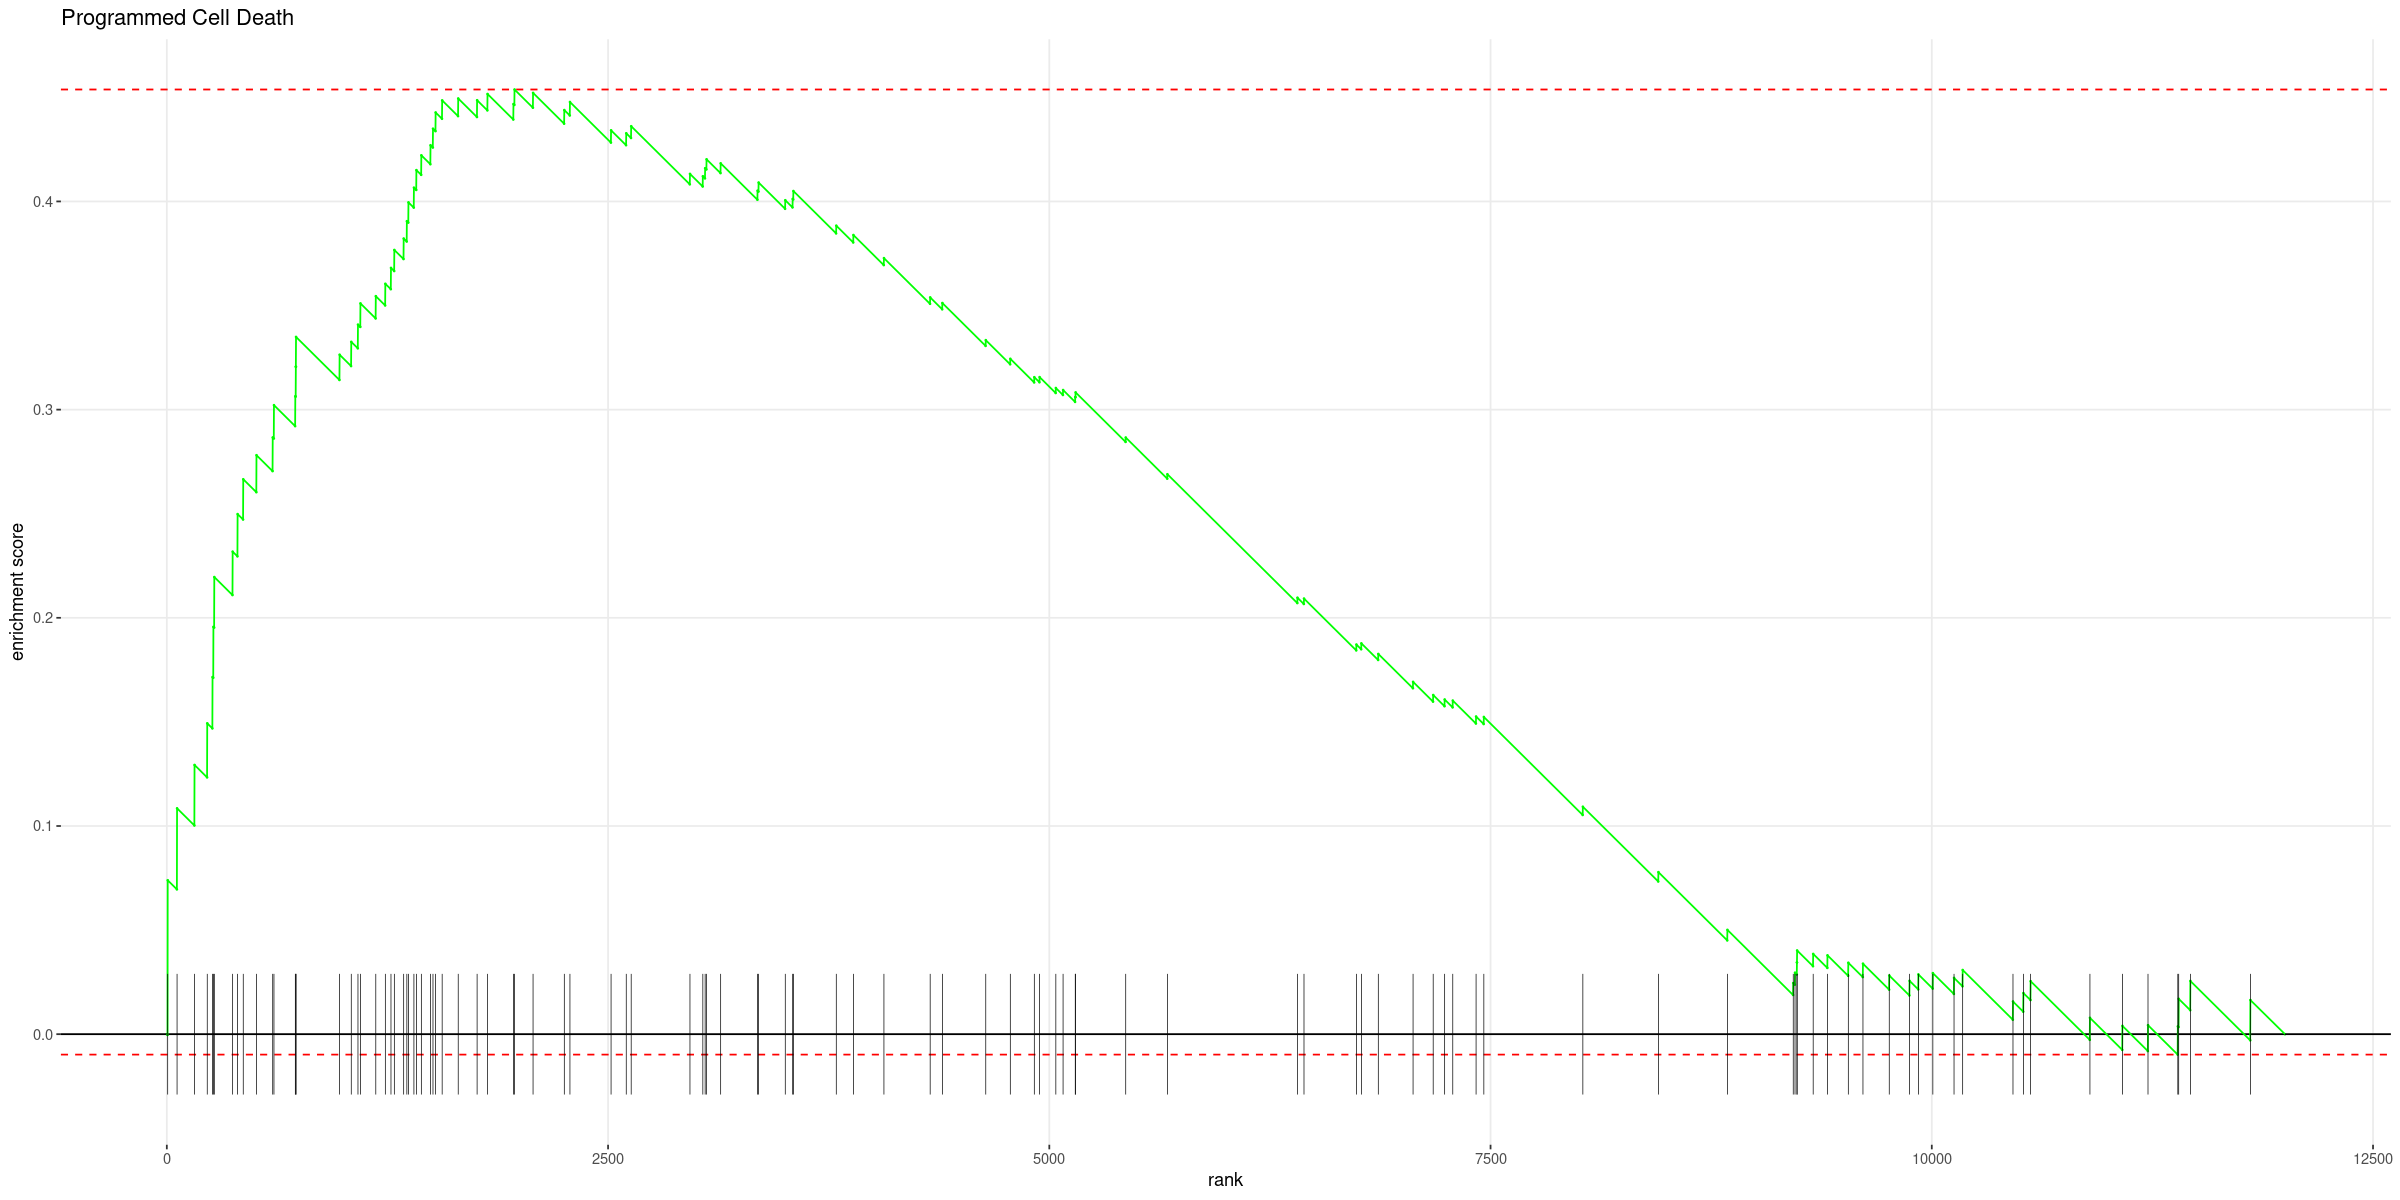

In [92]:
#test fgsea with ex
plotEnrichment(examplePathways[["5991130_Programmed_Cell_Death"]],
               exampleRanks) + labs(title="Programmed Cell Death")

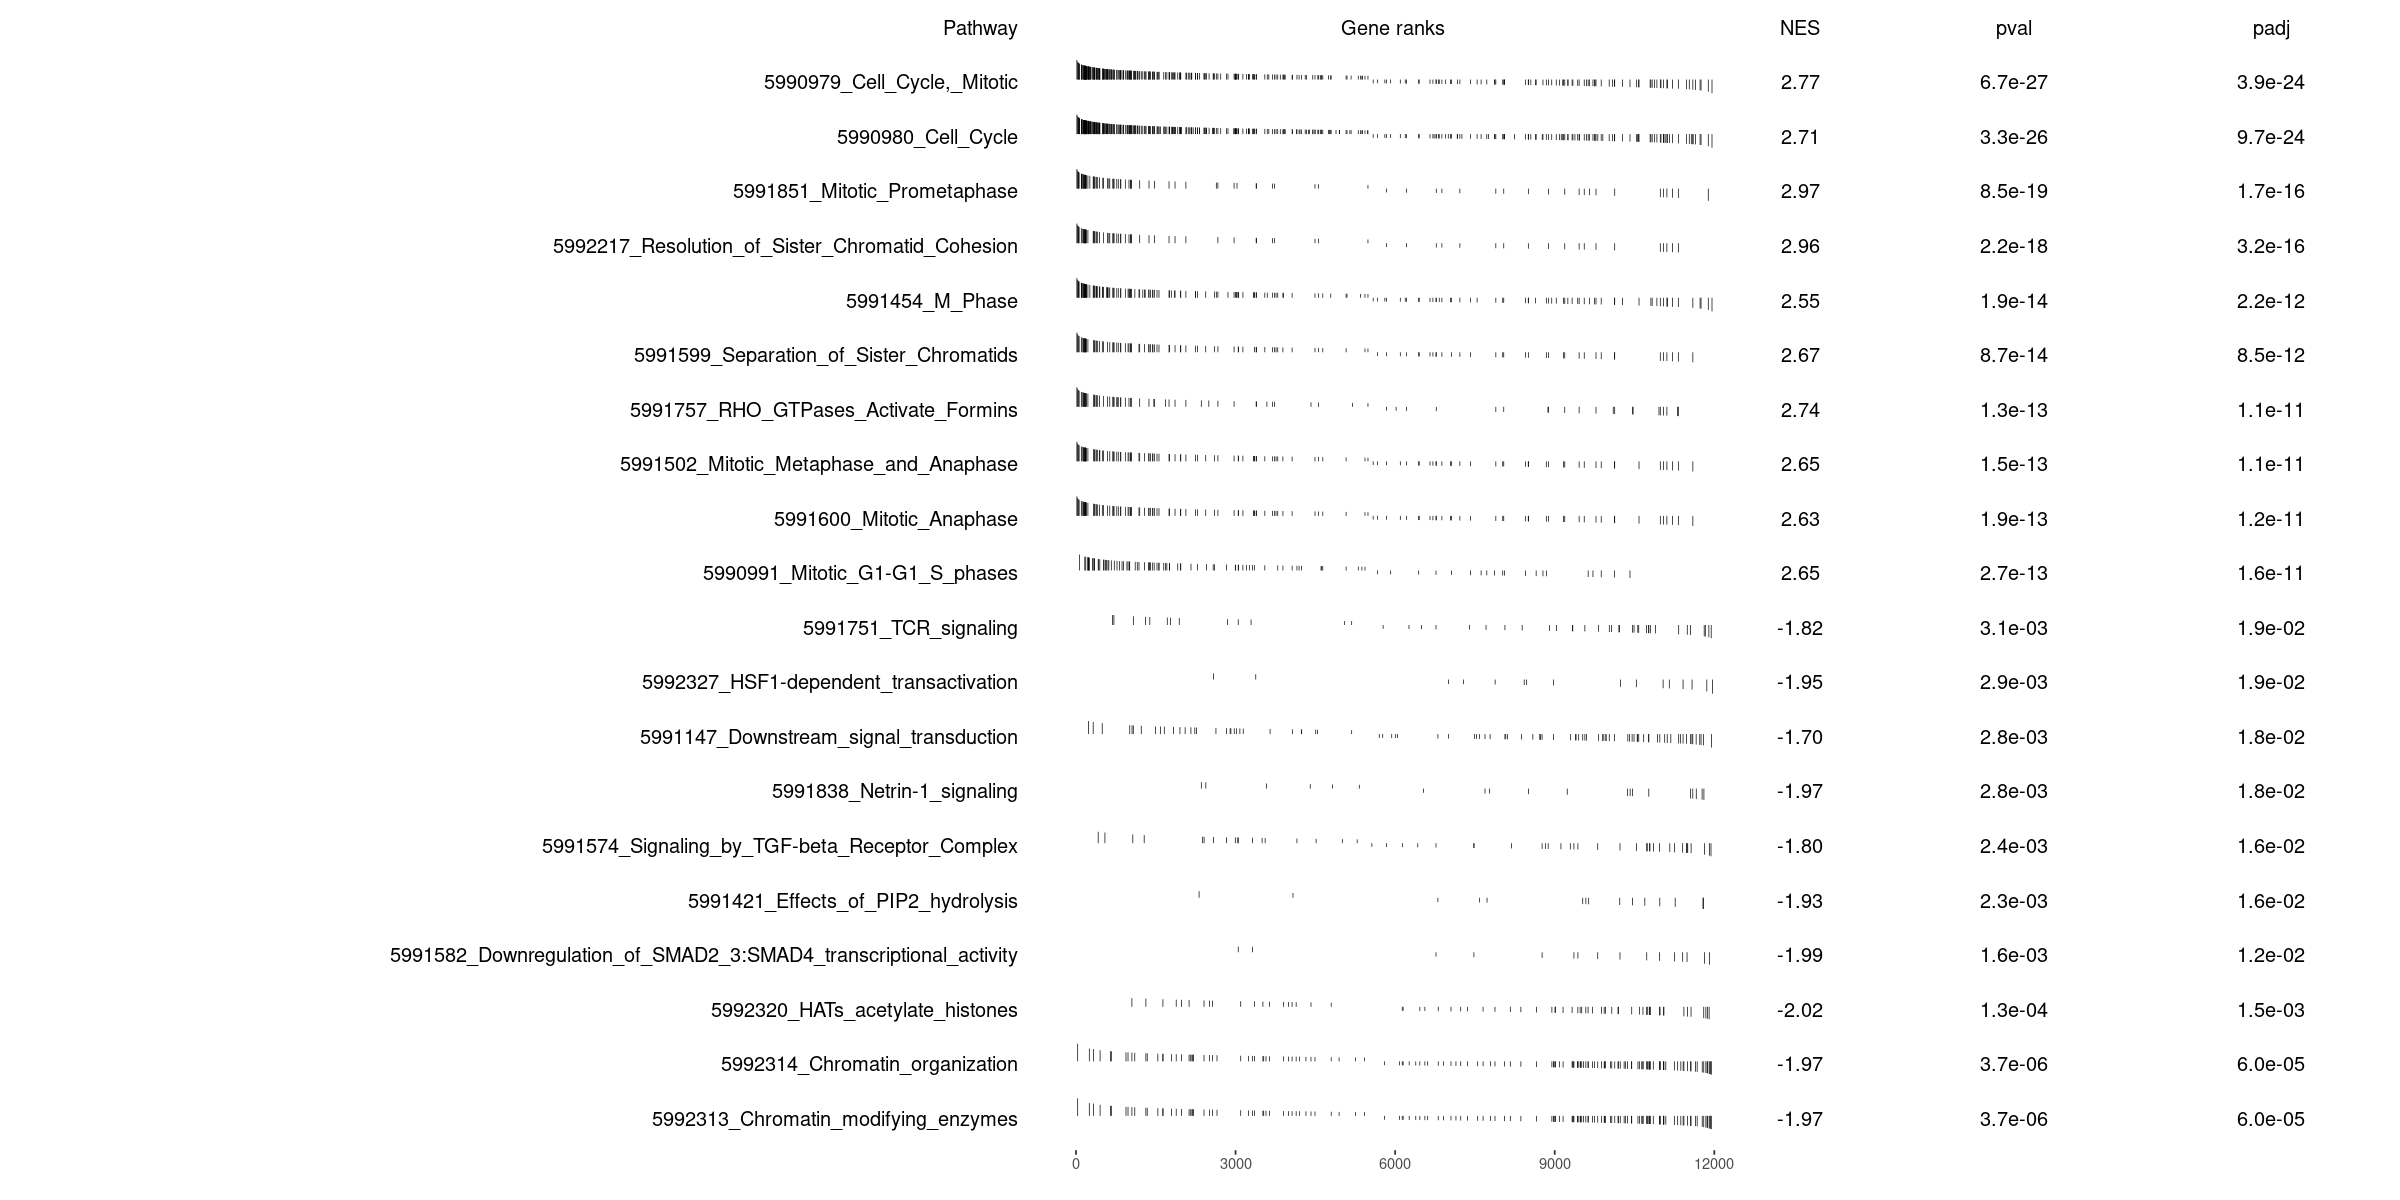

In [93]:
#Table for selected pathways 
topPathwaysUp <- fgseaRes[ES > 0][head(order(pval), n=10), pathway]
topPathwaysDown <- fgseaRes[ES < 0][head(order(pval), n=10), pathway]
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
plotGseaTable(examplePathways[topPathways], exampleRanks, fgseaRes, 
              gseaParam=0.5)

### 3.2  ( cluster 5)

#### PATHWAYS

In [94]:
pathways <- gmtPathways(system.file(
     "extdata", "c2.cp.reactome.v7.5.1.symbols.gmt", package="fgsea"))

In [96]:
head(pathways)

$REACTOME_INTERLEUKIN_6_SIGNALING
 [1] "JAK2"   "TYK2"   "CBL"    "STAT1"  "IL6ST"  "IL6"    "IL6R"   "JAK1"  
 [9] "STAT3"  "PTPN11" "SOCS3" 

$REACTOME_APOPTOSIS
  [1] "BAD"       "CFLAR"     "PSMB1"     "PSMC4"     "BID"       "VIM"      
  [7] "FAS"       "BAK1"      "DAPK2"     "CDH1"      "PSMA4"     "DSG2"     
 [13] "CASP8"     "PRKCQ"     "ROCK1"     "PSME4"     "ARHGAP10"  "TP63"     
 [19] "TP73"      "PKP1"      "BAX"       "PSMC5"     "ADD1"      "DNM1L"    
 [25] "PPP1R13B"  "DYNLL1"    "PSME1"     "CLSPN"     "PSMD5"     "DSP"      
 [31] "PSMD8"     "MAPK1"     "GZMB"      "PSMC6"     "PSMA3"     "PSMC1"    
 [37] "PSMB5"     "ACIN1"     "PSMA6"     "PSME2"     "PSMA7"     "E2F1"     
 [43] "PSMD10"    "XIAP"      "BMX"       "STK24"     "TRADD"     "MAPK3"    
 [49] "PSMD7"     "TJP1"      "BMF"       "GSDMD"     "TNFRSF10A" "AKT2"     
 [55] "BBC3"      "CARD8"     "GSDME"     "PSMA2"     "MAPK8"     "UNC5B"    
 [61] "PSMD3"     "SEPTIN4"   "KPNB1"     "C1QBP"     "PSMD11"    "YWHAE"    
 [67] "BIRC2"     "PSMD9"     "LMNB1"     "UNC5A"     "KPNA1"     "TFDP2"    
 [73] "PSMD14"    "AKT3"      "FASLG"     "TJP2"      "APAF1"     "TNFRSF10B"
 [79] "PPP3CC"    "TNFSF10"   "H1-3"      "H1-1"      "PSMF1"     "PSMB2"    
 [85] "TRAF2"     "TICAM1"    "SEM1"      "YWHAH"     "PSMA1"     "PSME3"    
 [91] "CASP9"     "YWHAQ"     "STK26"     "DSG3"      "DSG1"      "APC"      
 [97] "DBNL"      "NMT1"      "TLR4"      "PSMB7"     "RIPK1"     "UACA"     
[103] "CASP6"     "TP53"      "PMAIP1"    "AKT1"      "PSMB6"     "PSMA5"    
[109] "TP53BP2"   "RPS27A"    "CDKN2A"    "GSN"       "GAS2"      "APIP"     
[115] "UBC"       "BCL2L11"   "LY96"      "PSMA8"     "APPL1"     "PSMD4"    
[121] "PSMB4"     "DFFA"      "LMNA"      "PSMC2"     "OMA1"      "PSMD6"    
[127] "PRKCD"     "HMGB2"     "CASP3"     "YWHAZ"     "CASP7"     "PSMC3"    
[133] "YWHAB"     "DAPK3"     "CTNNB1"    "FADD"      "H1-4"      "FNTA"     
[139] "STAT3"     "PTK2"      "DFFB"      "AVEN"      "YWHAG"     "UBB"      
[145] "CD14"      "BCL2L1"    "BCL2"      "CYCS"      "PSMD1"     "PSMD2"    
[151] "SFN"       "PLEC"      "MAGED1"    "PAK2"      "SATB1"     "DIABLO"   
[157] "H1-5"      "PSMD13"    "BCAP31"    "MAPT"      "DCC"       "H1-2"     
[163] "H1-0"      "HMGB1"     "DAPK1"     "PSMD12"    "SPTAN1"    "OCLN"     
[169] "TFDP1"     "OPA1"      "PSMB8"     "PSMB10"    "PPP3R1"    "UBA52"    
[175] "PSMB11"    "PSMB9"     "TICAM2"    "DYNLL2"    "PSMB3"    

$REACTOME_HEMOSTASIS
  [1] "FGR"       "CD99"      "TFPI"      "KDM1A"     "PRKAR2B"   "ITGAL"    
  [7] "ITGA3"     "LAMP2"     "ITGA2B"    "TBXA2R"    "NOS2"      "SELE"     
 [13] "CD9"       "FYN"       "PLAUR"     "EHD3"      "IGF1"      "CD74"     
 [19] "HGF"       "SLC7A9"    "EHD2"      "CD44"      "PRKCH"     "VCL"      
 [25] "RAB27B"    "LCP2"      "HSPA5"     "BCAR1"     "PIK3CB"    "KIF1B"    
 [31] "ITIH4"     "F7"        "ATP2B4"    "DGKG"      "GNA15"     "GUCY1B1"  
 [37] "GPC1"      "HMG20B"    "GNAI3"     "DGKA"      "PRKCQ"     "PPP2R5A"  
 [43] "CD84"      "KIF26A"    "RHOA"      "PRKCZ"     "ATP2B3"    "KIF2A"    
 [49] "RASGRP2"   "PPP2R5B"   "TRPC7"     "ATP1B3"    "GNB5"      "CDC42"    
 [55] "ATP2B1"    "WDR1"      "PRKACA"    "SPP2"      "ACTN1"     "IRAG1"    
 [61] "ATP2A3"    "MGLL"      "SRI"       "ACTB"      "TUBA3D"    "KIFAP3"   
 [67] "STXBP2"    "DGKD"      "APBB1IP"   "ACTN2"     "CAPZB"     "PPP2R5C"  
 [73] "GNB1"      "RAPGEF3"   "CEACAM1"   "KIF22"     "CARMIL1"   "P2RX5"    
 [79] "APLP2"     "APOB"      "KIF3C"     "CEACAM6"   "GNAS"      "GP6"      
 [85] "GNA11"     "DOCK9"     "DOCK3"     "KIF9"      "F11"       "SIRPG"    
 [91] "P2RX7"     "KIF16B"    "NOS1"      "RCOR1"     "THPO"      "GLG1"     
 [97] "KIF4A"     "ITGA6"     "RAPGEF4"   "TF"        "APOH"      "ANGPT2"   
[103] "SLC7A8"    "TGFB2"     "CBX5"      "BRPF3"     "ITPR3"     "JAK2"     
[109] "ABL1"      "SERPIND1"  "P2RX6"     "PPIL2"     "MAPK1"     "PICK1"    
[115

In [97]:
str(head(pathways))

List of 6
 $ REACTOME_INTERLEUKIN_6_SIGNALING                                                           : chr [1:11] "JAK2" "TYK2" "CBL" "STAT1" ...
 $ REACTOME_APOPTOSIS                                                                         : chr [1:179] "BAD" "CFLAR" "PSMB1" "PSMC4" ...
 $ REACTOME_HEMOSTASIS                                                                        : chr [1:678] "FGR" "CD99" "TFPI" "KDM1A" ...
 $ REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS                                                   : chr [1:55] "BAD" "BID" "BAK1" "CASP8" ...
 $ REACTOME_MAPK3_ERK1_ACTIVATION                                                             : chr [1:10] "JAK2" "MAPK3" "TYK2" "IL6ST" ...
 $ REACTOME_TRANSLESION_SYNTHESIS_BY_Y_FAMILY_DNA_POLYMERASES_BYPASSES_LESIONS_ON_DNA_TEMPLATE: chr [1:39] "REV3L" "SPRTN" "RFC1" "RFC2" ...


#### RANKS

In [98]:
# create a dataframe for the cluster 5 

df_c5 <- data.frame(rna$Description, cluster_table$"Mophological.cluster.5")
df_c5

rna.Description cluster_table.Mophological.cluster.5
1     WASH7P           -8.3409227                         
2     RP11-34P13.18    -6.3167746                         
3     MTND1P23         -0.1132019                         
4     MTND2P28         -0.9568846                         
5     MTCO1P12         20.7974072                         
6     MTCO2P12          6.9213112                         
7     MTATP6P1          2.7230316                         
8     MTCO3P12         21.5523133                         
9     RP11-206L10.2    -4.1264983                         
10    LINC01128        -0.7130354                         
11    LINC00115        -6.0779058                         
12    SAMD11           -6.3882789                         
13    NOC2L            -0.5875307                         
14    KLHL17           -1.4104283                         
15    RP11-54O7.17     -6.8468915                         
16    HES4             -6.2468257                         
17    ISG15           -11.1386795                         
18    AGRN             -0.3187510                         
19    C1orf159         -4.0084392                         
20    RP11-465B22.8    -1.9868630                         
21    TNFRSF4          -6.2974080                         
22    SDF4              4.3602174                         
23    B3GALT6           7.6865015                         
24    UBE2J2            3.2934923                         
25    SCNN1D           -9.6883363                         
26    ACAP3            -3.5156474                         
27    PUSL1             3.7568935                         
28    INTS11           -3.2003776                         
29    RP5-890O3.9      -3.3106278                         
30    CPTP              1.8134842                         
⋮     ⋮               ⋮                                   
14021 ZFY              3.8581495                          
14022 TBL1Y           -0.1748875                          
14023 RP11-115H13.1    2.7179426                          
14024 PRKY            -2.0629193                          
14025 TTTY15          -0.8307926                          
14026 USP9Y           -0.2347646                          
14027 DDX3Y           -2.5481925                          
14028 UTY             -0.2028788                          
14029 NLGN4Y           5.0279668                          
14030 TTTY14          -2.0908938                          
14031 TXLNGY          -0.1093679                          
14032 RP11-424G14.1   -0.4828152                          
14033 KDM5D            1.8485945                          
14034 EIF1AY           3.7151917                          
14035 MT-RNR1         -0.3529624                          
14036 MT-RNR2          0.2258187                          
14037 MT-ND1           6.0335841                          
14038 MT-ND2          -1.3457928                          
14039 MT-CO1          17.4709757                          
14040 MT-TS1          14.0931868                          
14041 MT-CO2           4.8970609                          
14042 MT-ATP8          2.5649642                          
14043 MT-ATP6          3.3526503                          
14044 MT-CO3          -0.2887168                          
14045 MT-ND3          -0.5912536                          
14046 MT-ND4L          3.5558518                          
14047 MT-ND4           3.7950456                          
14048 MT-ND5          18.0376063                          
14049 MT-ND6          31.1216834                          
14050 MT-CYB           2.3321041

In [99]:
# group the dataframe by the gene symbols
# If the symbol has multiple log2FoldChange value, attribute the mean of the value
# Here we see that the number of row of df_c5 and df_grouped_c5 is the same.
# That means that each gene symbol was unique. 

df_grouped_c5 <- df_c5 %>% group_by(rna.Description) %>% summarise(cluster_table.Mophological.cluster.5=mean(cluster_table.Mophological.cluster.5))
df_grouped_c5

rna.Description     cluster_table.Mophological.cluster.5
1     A1BG                 -1.0944973                         
2     A2M                  -2.8476293                         
3     A4GALT               -4.9805065                         
4     AAAS                 -2.9768574                         
5     AACS                  5.5259322                         
6     AADAT                -4.8890005                         
7     AAED1                 1.0842379                         
8     AAGAB                 4.6081887                         
9     AAK1                 -1.2603838                         
10    AAMDC                 1.7157502                         
11    AAMP                  2.3881400                         
12    AAR2                  6.7142996                         
13    AARS                 11.9799888                         
14    AARS2                -1.7952898                         
15    AARSD1                1.8543008                         
16    AASDH                 0.4478107                         
17    AASDHPPT              1.8004978                         
18    AASS                  0.1914655                         
19    AATF                  3.2920233                         
20    AATK                  0.3133155                         
21    ABAT                 -6.1654398                         
22    ABC13-47488600E17.1   8.2174844                         
23    ABC7-42389800N19.1   -6.3378363                         
24    ABCA1                -0.1153255                         
25    ABCA10              -19.1038825                         
26    ABCA11P              -4.3771773                         
27    ABCA13                5.5642613                         
28    ABCA2                -2.4827709                         
29    ABCA3                 4.6118958                         
30    ABCA5                -4.3186977                         
⋮     ⋮                   ⋮                                   
14021 ZSCAN2               2.95092425                         
14022 ZSCAN20             -0.77641992                         
14023 ZSCAN21             -0.20230412                         
14024 ZSCAN22              2.33671422                         
14025 ZSCAN25              2.83619813                         
14026 ZSCAN26             -4.71190901                         
14027 ZSCAN29              0.27440615                         
14028 ZSCAN30             -1.07798644                         
14029 ZSCAN31             16.29350236                         
14030 ZSCAN5A              4.01280572                         
14031 ZSCAN9              -1.93049009                         
14032 ZSWIM1               3.12780504                         
14033 ZSWIM3               4.48067964                         
14034 ZSWIM4               0.67765912                         
14035 ZSWIM5               5.37262647                         
14036 ZSWIM6               0.01576408                         
14037 ZSWIM7              -0.77124942                         
14038 ZSWIM8              -0.74428538                         
14039 ZUFSP               -1.12577114                         
14040 ZW10                 0.04008272                         
14041 ZWILCH              -2.36013925                         
14042 ZWINT               -6.64162280                         
14043 ZXDA                 2.25145774                         
14044 ZXDB                 4.00317476                         
14045 ZXDC                 1.28067557                         
14046 ZYG11A              -3.89394448                         
14047 ZYG11B               0.79086633                         
14048 ZYX                 -0.99247742                         
14049 ZZEF1                1.38449777                         
14050 ZZZ3                -0.54224696

In [100]:
#create the ranking vector from the cluster 5
#row <- rownames(dataset)


v_c5 <- df_grouped_c5$"cluster_table.Mophological.cluster.5"
names(v_c5) <- df_grouped_c5$rna.Description

str(head(v_c5))


 Named num [1:6] -1.09 -2.85 -4.98 -2.98 5.53 ...
 - attr(*, "names")= chr [1:6] "A1BG" "A2M" "A4GALT" "AAAS" ...


In [101]:
ordered_v_c5 <- sort(v_c5, decreasing = FALSE)
str(head(ordered_v_c5))
head(ordered_v_c5)

 Named num [1:6] -31.7 -30 -30 -30 -30 ...
 - attr(*, "names")= chr [1:6] "STC1" "CHGA" "CYP1A1" "FOSB" ...


STC1      CHGA    CYP1A1      FOSB      HBA1      HBA2 
-31.74974 -30.00000 -30.00000 -30.00000 -30.00000 -30.00000

In [102]:
#ranks are sorted as a numeric vector
class(ordered_v_c5)
head(unname(ordered_v_c5))

[1] "numeric"

[1] -31.74974 -30.00000 -30.00000 -30.00000 -30.00000 -30.00000

#### FGSEA

In [103]:
# fgsea has a default lower bound eps=1e-10 for estimating P-values. 
# If you need to estimate P-value more accurately, you can set the eps argument to zero in the fgsea function.
# https://bioconductor.org/packages/devel/bioc/vignettes/fgsea/inst/doc/fgsea-tutorial.html

fgseaRes <- fgsea(pathways, ordered_v_c5, eps= 0.0, minSize=15, maxSize=500)
#head(fgseaRes)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.2% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


The warning produced indicates that there are few genes that have the same fold change and so are ranked equally. fgsea with arbitrarily order determine which comes first in the ranked list. As long as this number is small it shouldn’t significantly effect the results. If the number is large something is suspicious about the fold change results. (https://bioinformatics-core-shared-training.github.io/RNAseq_May_2020_remote/extended_html/06_Gene_set_testing.html)

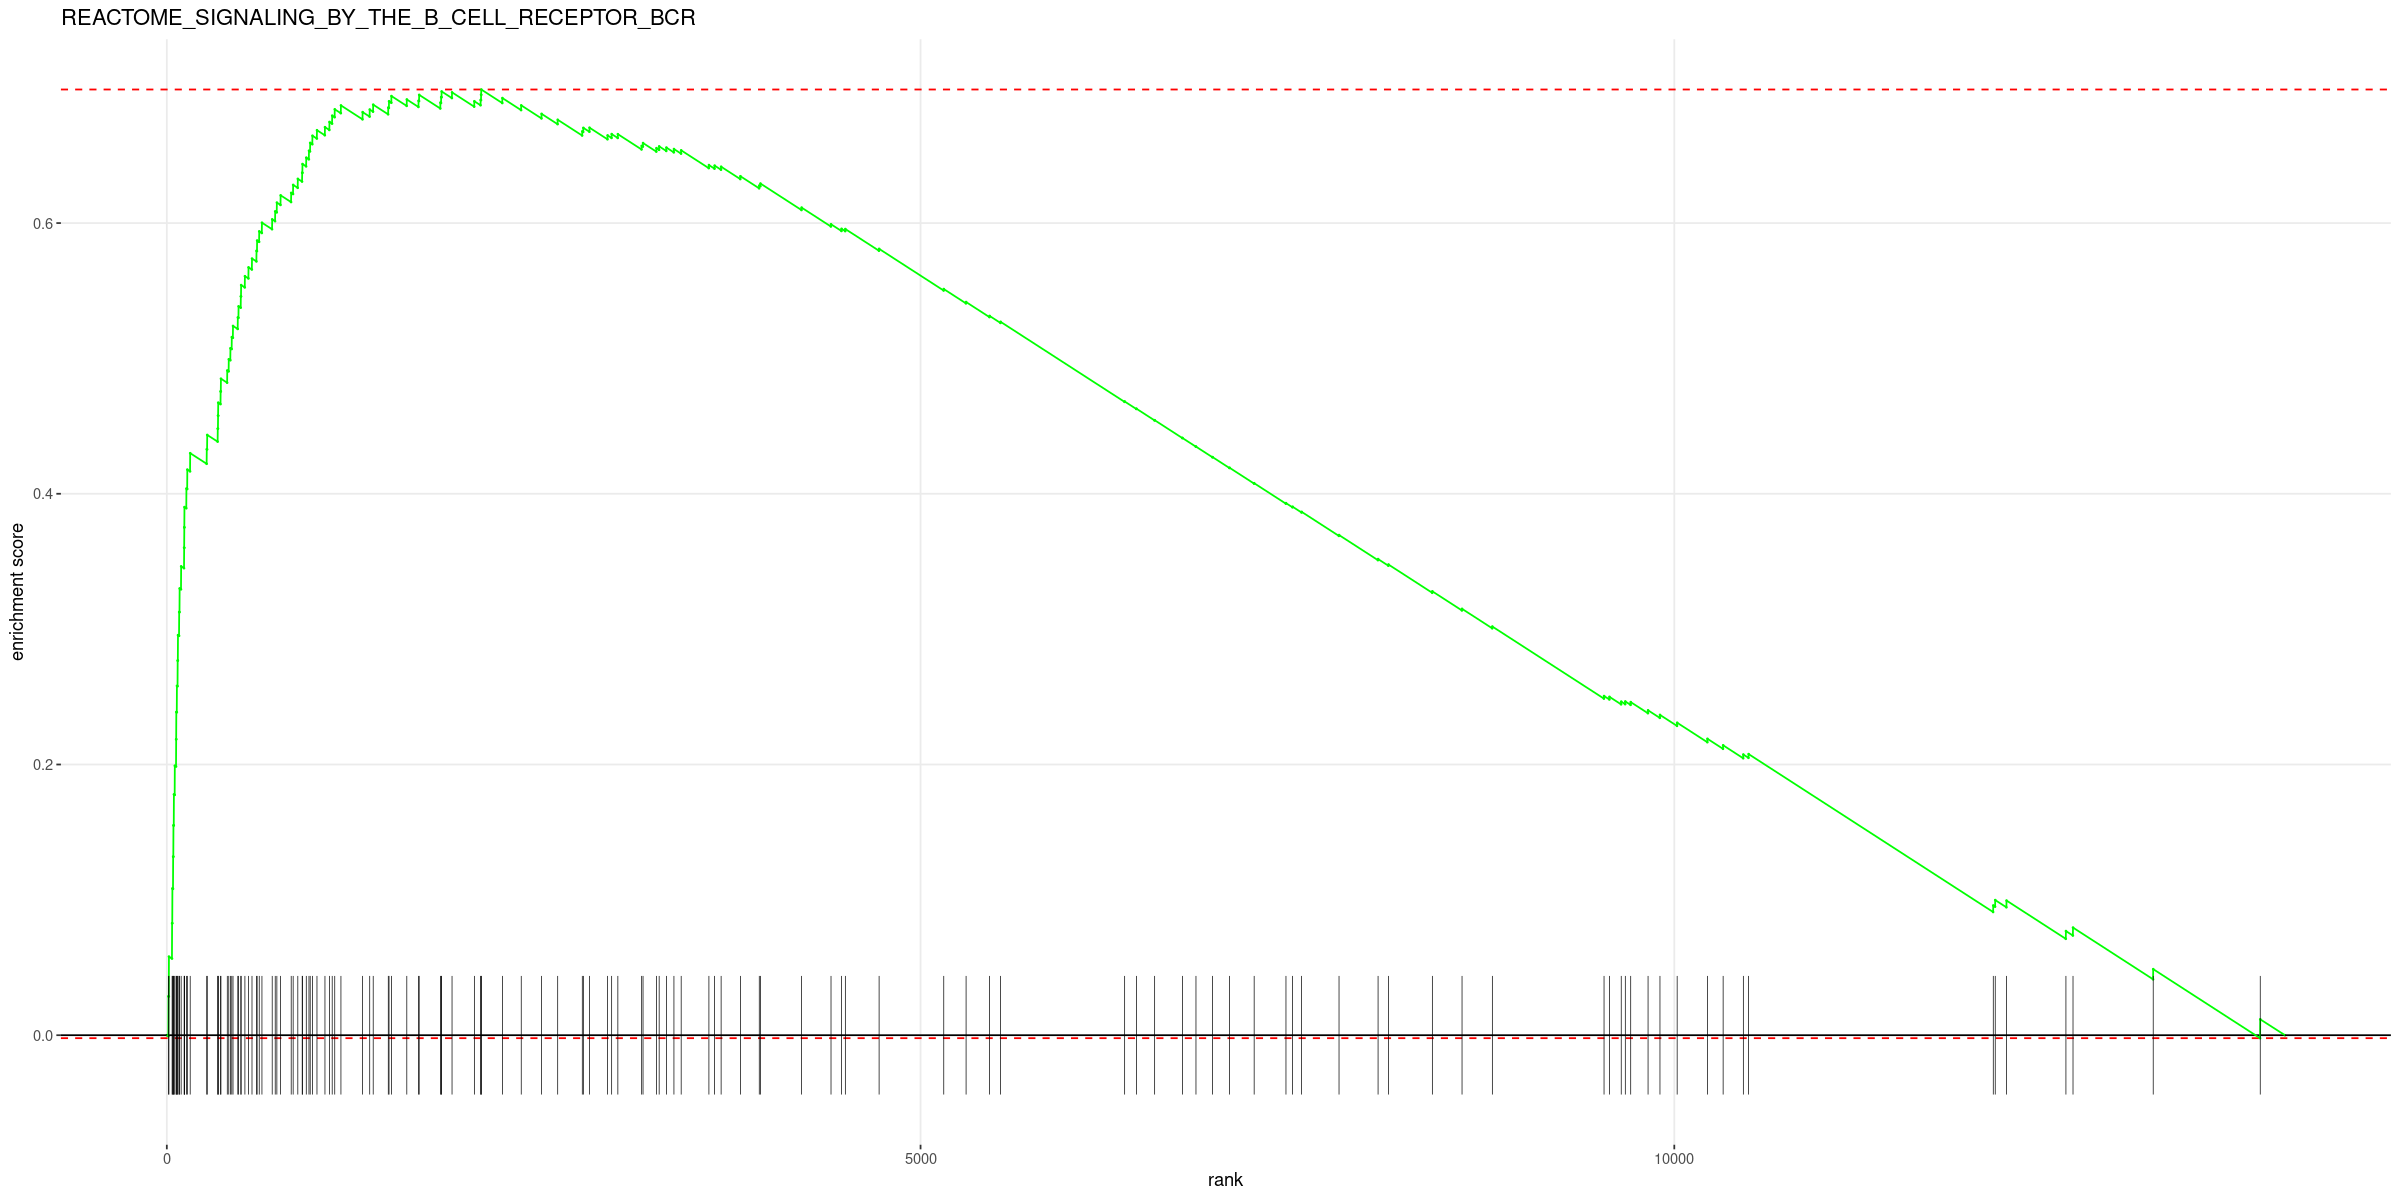

In [105]:
#Enrichment for cluster 5 and first item
plotEnrichment(pathways[["REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR"]],
               ordered_v_c5) + labs(title="REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR")

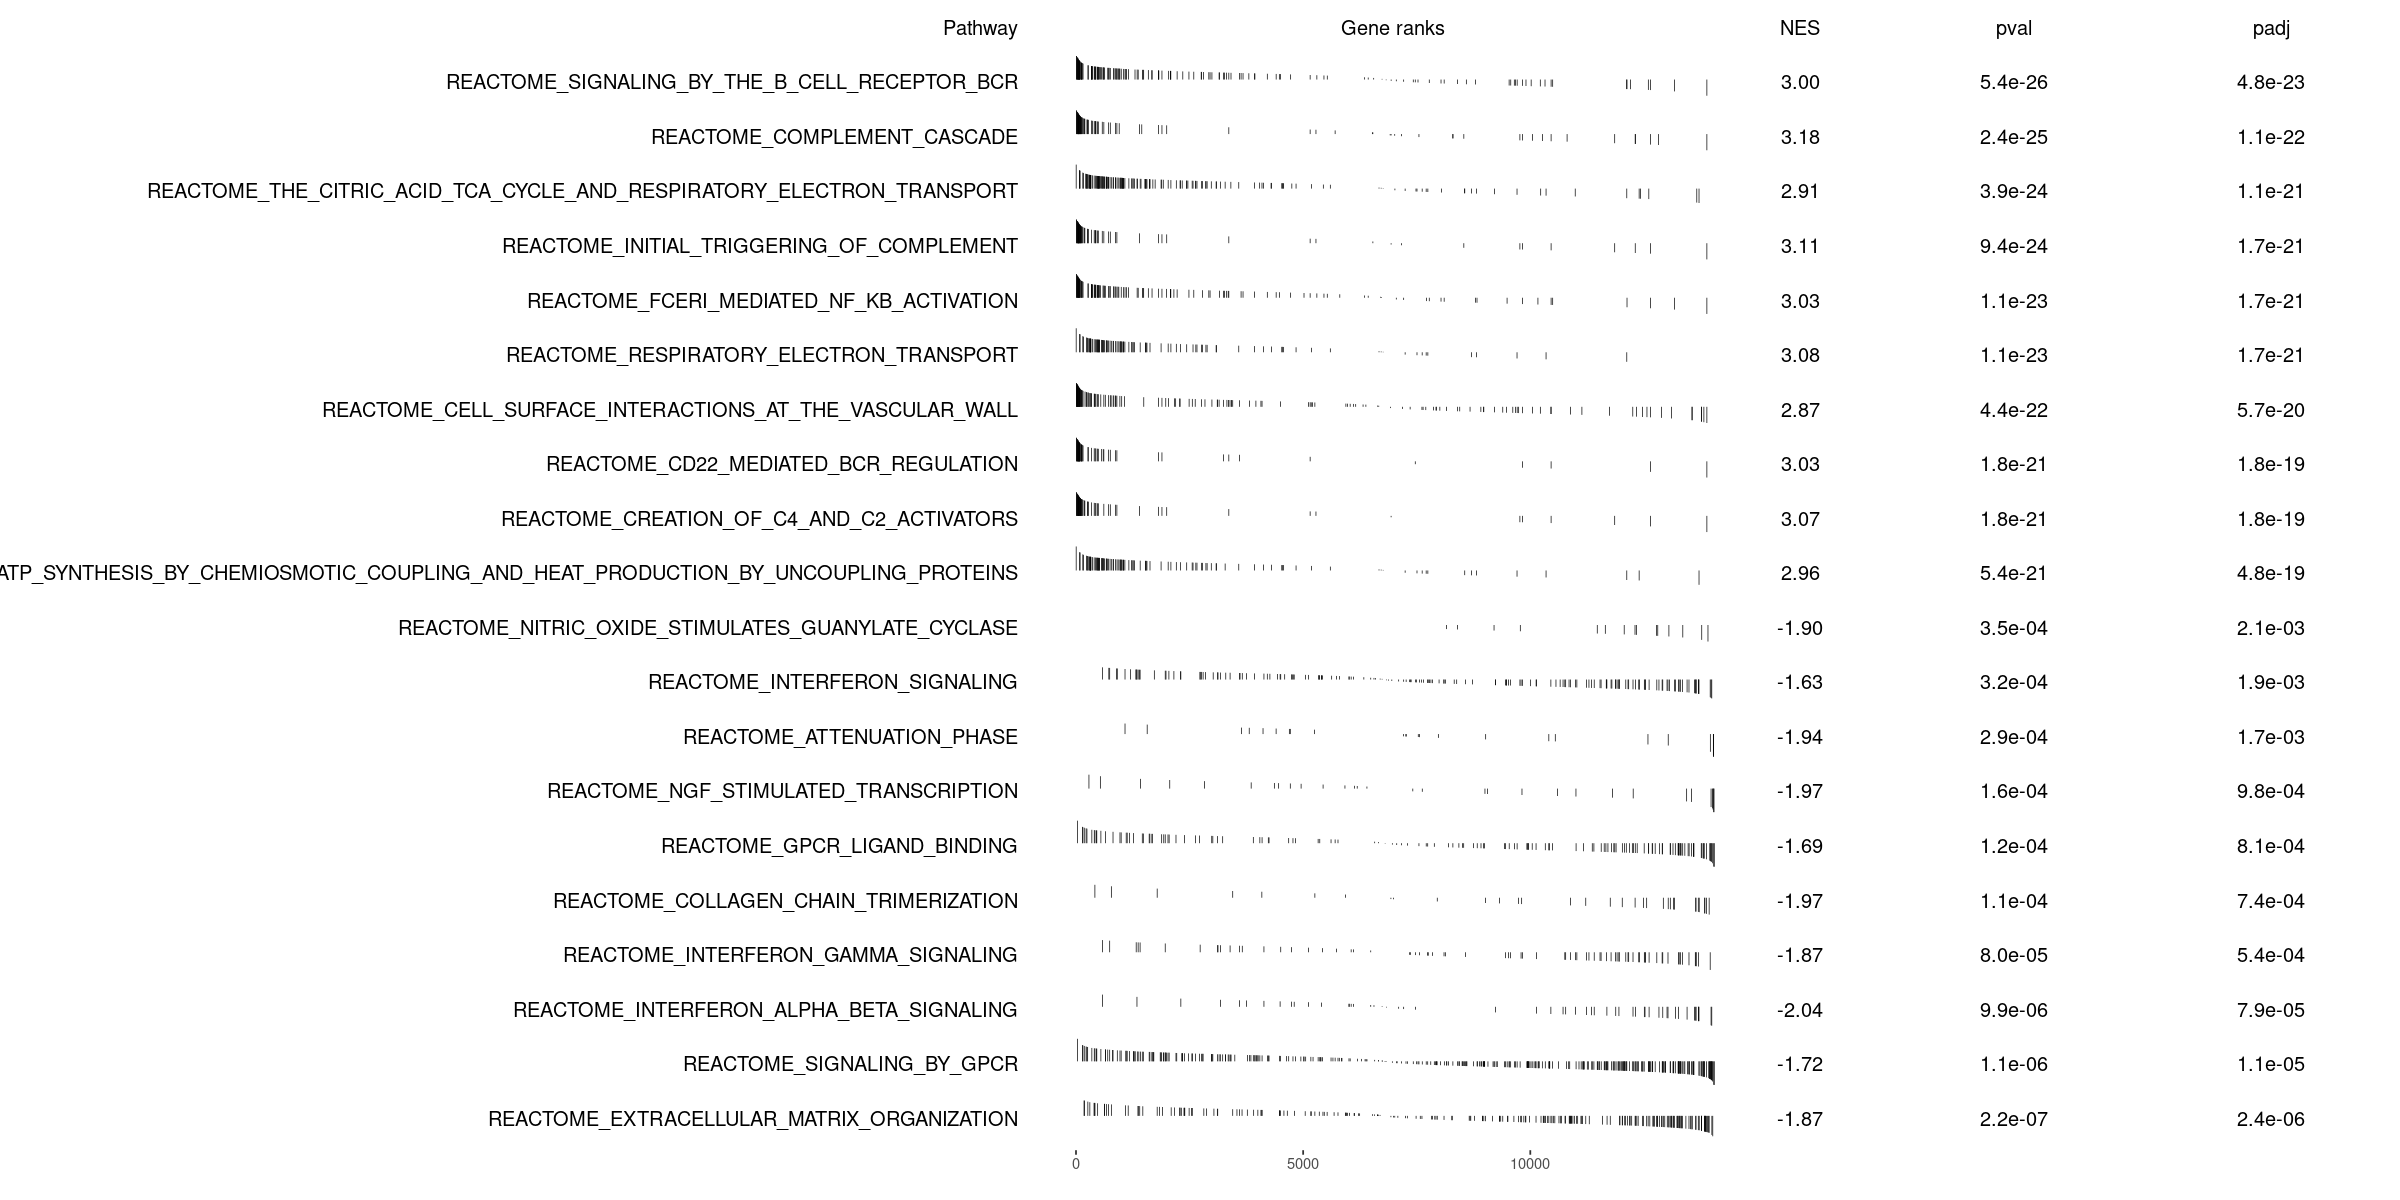

In [106]:
# Plot the top 10 pathways enriched at the top and bottom of the ranked list
# on the tutorial, the ranking is made with the use of the p-value 
# code from the tutorial : 
# https://bioconductor.org/packages/devel/bioc/vignettes/fgsea/inst/doc/fgsea-tutorial.html

topPathwaysUp <- fgseaRes[ES > 0][head(order(pval), n=10), pathway]
topPathwaysDown <- fgseaRes[ES < 0][head(order(pval), n=10), pathway]
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
plotGseaTable(pathways[topPathways], ordered_v_c5, fgseaRes, 
              gseaParam = 0.5)

In [107]:
# Reactome pathways have a median of 23 genes
summary(sapply(pathways, length))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    5.0    11.0    23.0    55.4    57.0  1434.0 

In [108]:
# number of significant pathways at padj < 0.01
sum(fgseaRes[, padj < 0.01])

[1] 187

In [109]:
# the most significant pathway
fgseaRes[order(pval),][1,]

pathway                                       pval         padj        
1 REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR 5.391655e-26 4.809356e-23
  log2err  ES        NES      size
1 1.318889 0.6986737 3.000306 149 
  leadingEdge                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
1 IGHV4-39, IGLV6-57, IGHV1-46, IGLV2-11, IGHV3-11, IGLV3-19, IGHV4-59, IGLV1-47, IGHV1-2 , IGLV1-51, IGKV1-5 , IGKV3-20, IGLV2-8 , IGHM    , IGLV1-44, IGHV3-23, IGHV3-7 , IGLV1-40, CD79A   , IGLV3-25, IGHV3-53, IGHV3-30, IGKV1-33, IGKV2-30, PSMB6   , IGHV2-5 , PSMD14  , PSMA5   , PSMA3   , IGLC2   , PSMB5   , IGHV3-33, PSMC1   , IGKV4-1 , IGKV1-16, PSMB3   , IGLV2-23, PSMD8   , PSMC4   , PSMA6   , CD79B   , PSMB1   , IGHD    , IGHV3-48, PSMD1   , AHCYL1  , IGKV3-15, PSMD7   , IGKV1-12, PSMC2   , PSMA7   , IGKV1-39, BLNK    , IGLV3-21, PSMA2   , PSME3   , CD19    , PPIA    , PSMB7   , PSMC3   , UBB     , VAV1    , PSMB2   , PSMD2   , PRKCB   , PSMB4   , PSMD6   , PSMD11  , PSMD3   , PSMD4   , PSMA4   , SYK     , PSMD9   , IGHV4-34, ORAI1   , ORAI2   , IGLV3-1 , STIM1   , PSMA1   , SEM1    , PSME4

In [110]:
# list of genes that contributed to the enrichment score
fgseaRes[order(pval),][1,]$leadingEdge

[[1]]
 [1] "IGHV4-39" "IGLV6-57" "IGHV1-46" "IGLV2-11" "IGHV3-11" "IGLV3-19"
 [7] "IGHV4-59" "IGLV1-47" "IGHV1-2"  "IGLV1-51" "IGKV1-5"  "IGKV3-20"
[13] "IGLV2-8"  "IGHM"     "IGLV1-44" "IGHV3-23" "IGHV3-7"  "IGLV1-40"
[19] "CD79A"    "IGLV3-25" "IGHV3-53" "IGHV3-30" "IGKV1-33" "IGKV2-30"
[25] "PSMB6"    "IGHV2-5"  "PSMD14"   "PSMA5"    "PSMA3"    "IGLC2"   
[31] "PSMB5"    "IGHV3-33" "PSMC1"    "IGKV4-1"  "IGKV1-16" "PSMB3"   
[37] "IGLV2-23" "PSMD8"    "PSMC4"    "PSMA6"    "CD79B"    "PSMB1"   
[43] "IGHD"     "IGHV3-48" "PSMD1"    "AHCYL1"   "IGKV3-15" "PSMD7"   
[49] "IGKV1-12" "PSMC2"    "PSMA7"    "IGKV1-39" "BLNK"     "IGLV3-21"
[55] "PSMA2"    "PSME3"    "CD19"     "PPIA"     "PSMB7"    "PSMC3"   
[61] "UBB"      "VAV1"     "PSMB2"    "PSMD2"    "PRKCB"    "PSMB4"   
[67] "PSMD6"    "PSMD11"   "PSMD3"    "PSMD4"    "PSMA4"    "SYK"     
[73] "PSMD9"    "IGHV4-34" "ORAI1"    "ORAI2"    "IGLV3-1"  "STIM1"   
[79] "PSMA1"    "SEM1"     "PSME4"

In [111]:
# How many genes are in the leading edge?
length(fgseaRes[order(pval),][1,]$leadingEdge[[1]])

[1] 81

In [112]:
# how many genes are in the pathway?
length(pathways[['REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR']])

[1] 166

### With each morphological cluster

#### Ranks

In [114]:
# create an empty list 
ranks <- list()

#create the ranks for each cluster and append the name to the list 'ranks'

#Ranks cluster 0
rank_cluster0 <- cluster_table_cnd$"Mophological.cluster.0lfc"
names(rank_cluster0) <- rna$Description
rank_cluster0  <- sort(rank_cluster0 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster0")

#Ranks cluster 1
rank_cluster1 <- cluster_table_cnd$"Mophological.cluster.1lfc"
names(rank_cluster1) <- rna$Description
rank_cluster1  <- sort(rank_cluster1 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster1")

#Ranks cluster 2
rank_cluster2 <- cluster_table_cnd$"Mophological.cluster.2lfc"
names(rank_cluster2) <- rna$Description
rank_cluster2  <- sort(rank_cluster2 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster2")

#Ranks cluster 3
rank_cluster3 <- cluster_table_cnd$"Mophological.cluster.3lfc"
names(rank_cluster3) <- rna$Description
rank_cluster3  <- sort(rank_cluster3 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster3")

#Ranks cluster 4
rank_cluster4 <- cluster_table_cnd$"Mophological.cluster.4lfc"
names(rank_cluster4) <- rna$Description
rank_cluster4  <- sort(rank_cluster4 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster4")

#Ranks cluster 5
rank_cluster5 <- cluster_table_cnd$"Mophological.cluster.5lfc"
names(rank_cluster5) <- rna$Description
rank_cluster5  <- sort(rank_cluster5 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster5")

#Ranks cluster 6
rank_cluster6 <- cluster_table_cnd$"Mophological.cluster.6lfc"
names(rank_cluster6) <- rna$Description
rank_cluster6  <- sort(rank_cluster6 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster6")

#Ranks cluster 7
rank_cluster7 <- cluster_table_cnd$"Mophological.cluster.7lfc"
names(rank_cluster7) <- rna$Description
rank_cluster7  <- sort(rank_cluster7 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster7")

#Ranks cluster 8
rank_cluster8 <- cluster_table_cnd$"Mophological.cluster.8lfc"
names(rank_cluster8) <- rna$Description
rank_cluster8  <- sort(rank_cluster8 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster8")

#Ranks cluster 9
rank_cluster9 <- cluster_table_cnd$"Mophological.cluster.9lfc"
names(rank_cluster9) <- rna$Description
rank_cluster9  <- sort(rank_cluster9 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster9")

#Ranks cluster 10
rank_cluster10 <- cluster_table_cnd$"Mophological.cluster.10lfc"
names(rank_cluster10) <- rna$Description
rank_cluster10  <- sort(rank_cluster10 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster10")

#Ranks cluster 11
rank_cluster11 <- cluster_table_cnd$"Mophological.cluster.11lfc"
names(rank_cluster11) <- rna$Description
rank_cluster11  <- sort(rank_cluster11 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster11")

#Ranks cluster 12
rank_cluster12 <- cluster_table_cnd$"Mophological.cluster.12lfc"
names(rank_cluster12) <- rna$Description
rank_cluster12  <- sort(rank_cluster12 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster12")

#Ranks cluster 13
rank_cluster13 <- cluster_table_cnd$"Mophological.cluster.13lfc"
names(rank_cluster13) <- rna$Description
rank_cluster13  <- sort(rank_cluster13 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster13")

#Ranks cluster 14
rank_cluster14 <- cluster_table_cnd$"Mophological.cluster.14lfc"
names(rank_cluster14) <- rna$Description
rank_cluster14  <- sort(rank_cluster14 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster14")

#Ranks cluster 15
rank_cluster15 <- cluster_table_cnd$"Mophological.cluster.15lfc"
names(rank_cluster15) <- rna$Description
rank_cluster15  <- sort(rank_cluster15 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster15")

#Ranks cluster 16
rank_cluster16 <- cluster_table_cnd$"Mophological.cluster.16lfc"
names(rank_cluster16) <- rna$Description
rank_cluster16  <- sort(rank_cluster16 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster16")

#Ranks cluster 17
rank_cluster17 <- cluster_table_cnd$"Mophological.cluster.17lfc"
names(rank_cluster17) <- rna$Description
rank_cluster17  <- sort(rank_cluster17 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster17")

#Ranks cluster 18
rank_cluster18 <- cluster_table_cnd$"Mophological.cluster.18lfc"
names(rank_cluster18) <- rna$Description
rank_cluster18  <- sort(rank_cluster18 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster18")

#Ranks cluster 19
rank_cluster19 <- cluster_table_cnd$"Mophological.cluster.19lfc"
names(rank_cluster19) <- rna$Description
rank_cluster19  <- sort(rank_cluster19 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster19")

#Ranks cluster 20
rank_cluster20 <- cluster_table_cnd$"Mophological.cluster.20lfc"
names(rank_cluster20) <- rna$Description
rank_cluster20  <- sort(rank_cluster20 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster20")

#Ranks cluster 21
rank_cluster21 <- cluster_table_cnd$"Mophological.cluster.21lfc"
names(rank_cluster21) <- rna$Description
rank_cluster21  <- sort(rank_cluster21 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster21")

#Ranks cluster 22
rank_cluster22 <- cluster_table_cnd$"Mophological.cluster.22lfc"
names(rank_cluster22) <- rna$Description
rank_cluster22  <- sort(rank_cluster22 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster22")

#Ranks cluster 23
rank_cluster23 <- cluster_table_cnd$"Mophological.cluster.23lfc"
names(rank_cluster23) <- rna$Description
rank_cluster23  <- sort(rank_cluster23 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster23")

#Ranks cluster 24
rank_cluster24 <- cluster_table_cnd$"Mophological.cluster.24lfc"
names(rank_cluster24) <- rna$Description
rank_cluster24  <- sort(rank_cluster24 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster24")

#Ranks cluster 25
rank_cluster25 <- cluster_table_cnd$"Mophological.cluster.25lfc"
names(rank_cluster25) <- rna$Description
rank_cluster25  <- sort(rank_cluster25 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster25")

#Ranks cluster 26
rank_cluster26 <- cluster_table_cnd$"Mophological.cluster.26lfc"
names(rank_cluster26) <- rna$Description
rank_cluster26  <- sort(rank_cluster26 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster26")

#Ranks cluster 27
rank_cluster27 <- cluster_table_cnd$"Mophological.cluster.27lfc"
names(rank_cluster27) <- rna$Description
rank_cluster27  <- sort(rank_cluster27 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster27")

#Ranks cluster 28
rank_cluster28 <- cluster_table_cnd$"Mophological.cluster.28lfc"
names(rank_cluster28) <- rna$Description
rank_cluster28  <- sort(rank_cluster28 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster28")

#Ranks cluster 29
rank_cluster29 <- cluster_table_cnd$"Mophological.cluster.29lfc"
names(rank_cluster29) <- rna$Description
rank_cluster29  <- sort(rank_cluster29 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster29")

#Ranks cluster 30
rank_cluster30 <- cluster_table_cnd$"Mophological.cluster.30lfc"
names(rank_cluster30) <- rna$Description
rank_cluster30  <- sort(rank_cluster30 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster30")

#Ranks cluster 31
rank_cluster31 <- cluster_table_cnd$"Mophological.cluster.31lfc"
names(rank_cluster31) <- rna$Description
rank_cluster31  <- sort(rank_cluster31 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster31")

#Ranks cluster 32
rank_cluster32 <- cluster_table_cnd$"Mophological.cluster.32lfc"
names(rank_cluster32) <- rna$Description
rank_cluster32  <- sort(rank_cluster32 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster32")

#Ranks cluster 33
rank_cluster33 <- cluster_table_cnd$"Mophological.cluster.33lfc"
names(rank_cluster33) <- rna$Description
rank_cluster33  <- sort(rank_cluster33 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster33")

#Ranks cluster 34
rank_cluster34 <- cluster_table_cnd$"Mophological.cluster.34lfc"
names(rank_cluster34) <- rna$Description
rank_cluster34  <- sort(rank_cluster34 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster34")

#Ranks cluster 35
rank_cluster35 <- cluster_table_cnd$"Mophological.cluster.35lfc"
names(rank_cluster35) <- rna$Description
rank_cluster35  <- sort(rank_cluster35 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster35")

#Ranks cluster 36
rank_cluster36 <- cluster_table_cnd$"Mophological.cluster.36lfc"
names(rank_cluster36) <- rna$Description
rank_cluster36  <- sort(rank_cluster36 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster36")

#Ranks cluster 37
rank_cluster37 <- cluster_table_cnd$"Mophological.cluster.37lfc"
names(rank_cluster37) <- rna$Description
rank_cluster37  <- sort(rank_cluster37 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster37")

#Ranks cluster 38
rank_cluster38 <- cluster_table_cnd$"Mophological.cluster.38lfc"
names(rank_cluster38) <- rna$Description
rank_cluster38  <- sort(rank_cluster38 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster38")

#Ranks cluster 39
rank_cluster39 <- cluster_table_cnd$"Mophological.cluster.39lfc"
names(rank_cluster39) <- rna$Description
rank_cluster39  <- sort(rank_cluster39 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster39")

#Ranks cluster 40
rank_cluster40 <- cluster_table_cnd$"Mophological.cluster.40lfc"
names(rank_cluster40) <- rna$Description
rank_cluster40  <- sort(rank_cluster40 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster40")

#Ranks cluster 41
rank_cluster41 <- cluster_table_cnd$"Mophological.cluster.41lfc"
names(rank_cluster41) <- rna$Description
rank_cluster41  <- sort(rank_cluster41 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster41")

#Ranks cluster 42
rank_cluster42 <- cluster_table_cnd$"Mophological.cluster.42lfc"
names(rank_cluster42) <- rna$Description
rank_cluster42  <- sort(rank_cluster42 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster42")

#Ranks cluster 43
rank_cluster43 <- cluster_table_cnd$"Mophological.cluster.43lfc"
names(rank_cluster43) <- rna$Description
rank_cluster43  <- sort(rank_cluster43 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster43")

#Ranks cluster 44
rank_cluster44 <- cluster_table_cnd$"Mophological.cluster.44lfc"
names(rank_cluster44) <- rna$Description
rank_cluster44  <- sort(rank_cluster44 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster44")

#Ranks cluster 45
rank_cluster45 <- cluster_table_cnd$"Mophological.cluster.45lfc"
names(rank_cluster45) <- rna$Description
rank_cluster45  <- sort(rank_cluster45 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster45")

#Ranks cluster 46
rank_cluster46 <- cluster_table_cnd$"Mophological.cluster.46lfc"
names(rank_cluster46) <- rna$Description
rank_cluster46  <- sort(rank_cluster46 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster46")

#Ranks cluster 47
rank_cluster47 <- cluster_table_cnd$"Mophological.cluster.47lfc"
names(rank_cluster47) <- rna$Description
rank_cluster47  <- sort(rank_cluster47 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster47")

#Ranks cluster 48
rank_cluster48 <- cluster_table_cnd$"Mophological.cluster.48lfc"
names(rank_cluster48) <- rna$Description
rank_cluster48  <- sort(rank_cluster48 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster48")

#Ranks cluster 49
rank_cluster49 <- cluster_table_cnd$"Mophological.cluster.49lfc"
names(rank_cluster49) <- rna$Description
rank_cluster49  <- sort(rank_cluster49 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster49")

#Ranks cluster 50
rank_cluster50 <- cluster_table_cnd$"Mophological.cluster.50lfc"
names(rank_cluster50) <- rna$Description
rank_cluster50  <- sort(rank_cluster50 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster50")

#Ranks cluster 51
rank_cluster51 <- cluster_table_cnd$"Mophological.cluster.51lfc"
names(rank_cluster51) <- rna$Description
rank_cluster51  <- sort(rank_cluster51 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster51")

#Ranks cluster 52
rank_cluster52 <- cluster_table_cnd$"Mophological.cluster.52lfc"
names(rank_cluster52) <- rna$Description
rank_cluster52  <- sort(rank_cluster52 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster52")

#Ranks cluster 53
rank_cluster53 <- cluster_table_cnd$"Mophological.cluster.53lfc"
names(rank_cluster53) <- rna$Description
rank_cluster53  <- sort(rank_cluster53 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster53")

#Ranks cluster 54
rank_cluster54 <- cluster_table_cnd$"Mophological.cluster.54lfc"
names(rank_cluster54) <- rna$Description
rank_cluster54  <- sort(rank_cluster54 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster54")

#Ranks cluster 55
rank_cluster55 <- cluster_table_cnd$"Mophological.cluster.55lfc"
names(rank_cluster55) <- rna$Description
rank_cluster55  <- sort(rank_cluster55 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster55")

#Ranks cluster 56
rank_cluster56 <- cluster_table_cnd$"Mophological.cluster.56lfc"
names(rank_cluster56) <- rna$Description
rank_cluster56  <- sort(rank_cluster56 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster56")

#Ranks cluster 57
rank_cluster57 <- cluster_table_cnd$"Mophological.cluster.57lfc"
names(rank_cluster57) <- rna$Description
rank_cluster57  <- sort(rank_cluster57 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster57")

#Ranks cluster 58
rank_cluster58 <- cluster_table_cnd$"Mophological.cluster.58lfc"
names(rank_cluster58) <- rna$Description
rank_cluster58  <- sort(rank_cluster58 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster58")

#Ranks cluster 59
rank_cluster59 <- cluster_table_cnd$"Mophological.cluster.59lfc"
names(rank_cluster59) <- rna$Description
rank_cluster59  <- sort(rank_cluster59 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster59")

#Ranks cluster 60
rank_cluster60 <- cluster_table_cnd$"Mophological.cluster.60lfc"
names(rank_cluster60) <- rna$Description
rank_cluster60  <- sort(rank_cluster60 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster60")

#Ranks cluster 61
rank_cluster61 <- cluster_table_cnd$"Mophological.cluster.61lfc"
names(rank_cluster61) <- rna$Description
rank_cluster61  <- sort(rank_cluster61 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster61")

#Ranks cluster 62
rank_cluster62 <- cluster_table_cnd$"Mophological.cluster.62lfc"
names(rank_cluster62) <- rna$Description
rank_cluster62  <- sort(rank_cluster62 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster62")

#Ranks cluster 63
rank_cluster63 <- cluster_table_cnd$"Mophological.cluster.63lfc"
names(rank_cluster63) <- rna$Description
rank_cluster63  <- sort(rank_cluster63 , decreasing = FALSE)
ranks <- append(ranks, "rank_cluster63")

#### PATHWAYS

In [115]:
pathways <- gmtPathways(system.file(
     "extdata", "c2.cp.reactome.v7.5.1.symbols.gmt", package="fgsea"))

#### MATRICE RESULTATS

In [116]:
#Pour chaque cluster, il y aura 4 colonnes : pathway, padj, NES, leadingEdge
#create the columns for the dataframe 
col_list <- list()


for (y in ranks) {
    path <- paste0(y,"pathways")
    padj <- paste0(y,"padj")
    NES <- paste0(y,"NES")
    leadingEdge <- paste0(y,"leadingEdge")
    col_list <- append(col_list, path)
    col_list <- append(col_list, padj)
    col_list <- append(col_list, NES)
    col_list <- append(col_list, leadingEdge)
}

In [117]:
#fgsea_table dataframe

lpth <- length(pathways)
row <- c(1:lpth)

fgsea_table <- data.frame(matrix(ncol = length(col_list), nrow = length(row)))
colnames(fgsea_table) <- col_list
rownames(fgsea_table) <- row
fgsea_table


rank_cluster0pathways rank_cluster0padj rank_cluster0NES
1    NA                    NA                NA              
2    NA                    NA                NA              
3    NA                    NA                NA              
4    NA                    NA                NA              
5    NA                    NA                NA              
6    NA                    NA                NA              
7    NA                    NA                NA              
8    NA                    NA                NA              
9    NA                    NA                NA              
10   NA                    NA                NA              
11   NA                    NA                NA              
12   NA                    NA                NA              
13   NA                    NA                NA              
14   NA                    NA                NA              
15   NA                    NA                NA              
16   NA                    NA                NA              
17   NA                    NA                NA              
18   NA                    NA                NA              
19   NA                    NA                NA              
20   NA                    NA                NA              
21   NA                    NA                NA              
22   NA                    NA                NA              
23   NA                    NA                NA              
24   NA                    NA                NA              
25   NA                    NA                NA              
26   NA                    NA                NA              
27   NA                    NA                NA              
28   NA                    NA                NA              
29   NA                    NA                NA              
30   NA                    NA                NA              
⋮    ⋮                     ⋮                 ⋮               
1586 NA                    NA                NA              
1587 NA                    NA                NA              
1588 NA                    NA                NA              
1589 NA                    NA                NA              
1590 NA                    NA                NA              
1591 NA                    NA                NA              
1592 NA                    NA                NA              
1593 NA                    NA                NA              
1594 NA                    NA                NA              
1595 NA                    NA                NA              
1596 NA                    NA                NA              
1597 NA                    NA                NA              
1598 NA                    NA                NA              
1599 NA                    NA                NA              
1600 NA                    NA                NA              
1601 NA                    NA                NA              
1602 NA                    NA                NA              
1603 NA                    NA                NA              
1604 NA                    NA                NA              
1605 NA                    NA                NA              
1606 NA                    NA                NA              
1607 NA                    NA                NA              
1608 NA                    NA                NA              
1609 NA                    NA                NA              
1610 NA                    NA                NA              
1611 NA                    NA                NA              
1612 NA                    NA                NA              
1613 NA                    NA                NA              
1614 NA                    NA                NA              
1615 NA                    NA                NA              
     rank_cluster0leadingEdge rank_cluster1pathways rank_cluster1padj
1    NA                       NA                    NA               
2    NA              

In [118]:
#dataframe for the number of up and down regulated pathways 
col <- ranks
row <- c("number_significant_down_regulated_pathways", "number_significant_upregulated_pathways")

significant_1_rct <- data.frame(matrix(ncol = length(col), nrow = length(row)))
colnames(significant_1_rct ) <- col
rownames(significant_1_rct ) <- row

#second dataframe 
row_2 <- c("Most significant up-regulated pathway 1", "Most significant up-regulated pathway 2", "Most significant up-regulated pathway 3", "Most significant up-regulated pathway 4", "Most significant up-regulated pathway 5", "Most significant up-regulated pathway 6", "Most significant up-regulated pathway 7", "Most significant up-regulated pathway 8", "Most significant up-regulated pathway 9", "Most significant up-regulated pathway 10")
significant_2_rct <- data.frame(matrix(ncol = length(col), nrow = length(row_2)))
colnames(significant_2_rct ) <- col
rownames(significant_2_rct ) <- row_2

significant_1_rct

rank_cluster0 rank_cluster1
number_significant_down_regulated_pathways NA            NA           
number_significant_upregulated_pathways    NA            NA           
                                           rank_cluster2 rank_cluster3
number_significant_down_regulated_pathways NA            NA           
number_significant_upregulated_pathways    NA            NA           
                                           rank_cluster4 rank_cluster5
number_significant_down_regulated_pathways NA            NA           
number_significant_upregulated_pathways    NA            NA           
                                           rank_cluster6 rank_cluster7
number_significant_down_regulated_pathways NA            NA           
number_significant_upregulated_pathways    NA            NA           
                                           rank_cluster8 rank_cluster9 ⋯
number_significant_down_regulated_pathways NA            NA            ⋯
number_significant_upregulated_pathways    NA            NA            ⋯
                                           rank_cluster54 rank_cluster55
number_significant_down_regulated_pathways NA             NA            
number_significant_upregulated_pathways    NA             NA            
                                           rank_cluster56 rank_cluster57
number_significant_down_regulated_pathways NA             NA            
number_significant_upregulated_pathways    NA             NA            
                                           rank_cluster58 rank_cluster59
number_significant_down_regulated_pathways NA             NA            
number_significant_upregulated_pathways    NA             NA            
                                           rank_cluster60 rank_cluster61
number_significant_down_regulated_pathways NA             NA            
number_significant_upregulated_pathways    NA             NA            
                                           rank_cluster62 rank_cluster63
number_significant_down_regulated_pathways NA             NA            
number_significant_upregulated_pathways    NA             NA

In [119]:
# fill the columns 

fil_pathways <- function(condition){
    cond <- paste0(condition,"pathways")
    pathway_col <- c(fgseaRes$pathway,rep(NA, 1615 - length(fgseaRes$pathway)))
    fgsea_table[cond] <<- pathway_col
}

fil_padj <- function(condition){
    cond <- paste0(condition,"padj")
    padj_col <- c(fgseaRes$padj,rep(NA, 1615 - length(fgseaRes$padj)))
    fgsea_table[cond] <<- padj_col
}

fil_NES <- function(condition){
    cond <- paste0(condition,"NES")
    NES_col <- c(fgseaRes$NES,rep(NA, 1615 - length(fgseaRes$NES)))
    fgsea_table[cond] <<- NES_col
}

fil_leadingEdge <- function(condition){
    cond <- paste0(condition,"leadingEdge")
    leadingEdge_col <- fgseaRes$leadingEdge
    empty <- rep(NA, 1615 - length(fgseaRes$leadingEdge))
    leadingEdge_col <- append(leadingEdge_col, empty)
    fgsea_table[cond] <<- list(leadingEdge_col)
}


fil_significant_1_rct <- function(condition){
    cond <- paste0(condition)
    cluster_col <- c(length(rownames(fgseaResSig_down)), length(rownames(fgseaResSig_up)))
    significant_1_rct[cond] <<- cluster_col
}


fil_significant_2_rct <- function(condition){
    cond <- paste0(condition)
    fgseaResSig_up_order <- fgseaResSig_up[order(fgseaResSig_up$padj),]
    fgseaResSig_up_order <- fgseaResSig_up[order(fgseaResSig_up$padj),]
    significant_2_rct[cond] <<- c(head(fgseaResSig_up_order$pathway, n=10),rep(NA, 10 - length(head(fgseaResSig_up_order$pathway, n=10))))
}


In [120]:


for (j in ranks) {
    fgseaRes <- fgsea(pathways = pathways, stats = get(j), eps= 0.0, minSize=15, maxSize=500)
    fgseaResSig <- subset(fgseaRes, padj < 0.05)
    fgseaResSig_up <- subset(fgseaResSig, ES > 0)
    fgseaResSig_down <- subset(fgseaResSig, ES < 0)
    fil_significant_1_rct(j)
    fil_significant_2_rct(j)
    fil_pathways(j)
    fil_padj(j)
    fil_NES(j)
    fil_leadingEdge(j)
}


Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (2.57% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.62% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.42% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.36% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(p

Warning message in fgseaMultilevel(...):
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.46% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.98% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.44% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.85

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.15% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (1.47% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (2.14% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.59% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(p

In [122]:
significant_1_rct_t <- t(significant_1_rct)
significant_2_rct_t <- t(significant_2_rct)
significant_1_rct_t
significant_2_rct_t

number_significant_down_regulated_pathways
rank_cluster0  210                                       
rank_cluster1  189                                       
rank_cluster2   31                                       
rank_cluster3  135                                       
rank_cluster4   72                                       
rank_cluster5   29                                       
rank_cluster6   54                                       
rank_cluster7   52                                       
rank_cluster8   78                                       
rank_cluster9   98                                       
rank_cluster10 142                                       
rank_cluster11  67                                       
rank_cluster12  55                                       
rank_cluster13  72                                       
rank_cluster14  29                                       
rank_cluster15 166                                       
rank_cluster16  25                                       
rank_cluster17  74                                       
rank_cluster18  14                                       
rank_cluster19 110                                       
rank_cluster20 142                                       
rank_cluster21  68                                       
rank_cluster22  49                                       
rank_cluster23  57                                       
rank_cluster24  31                                       
rank_cluster25 127                                       
rank_cluster26  57                                       
rank_cluster27  48                                       
rank_cluster28  36                                       
rank_cluster29  83                                       
⋮              ⋮                                         
rank_cluster34  67                                       
rank_cluster35  33                                       
rank_cluster36  21                                       
rank_cluster37  61                                       
rank_cluster38  29                                       
rank_cluster39 111                                       
rank_cluster40  32                                       
rank_cluster41  66                                       
rank_cluster42  10                                       
rank_cluster43  67                                       
rank_cluster44  44                                       
rank_cluster45  34                                       
rank_cluster46 174                                       
rank_cluster47  85                                       
rank_cluster48  77                                       
rank_cluster49  67                                       
rank_cluster50  16                                       
rank_cluster51  65                                       
rank_cluster52  26                                       
rank_cluster53  64                                       
rank_cluster54  49                                       
rank_cluster55 203                                       
rank_cluster56  66                                       
rank_cluster57  63                                       
rank_cluster58  29                                       
rank_cluster59  49                                       
rank_cluster60  46                                       
rank_cluster61  62                                       
rank_cluster62  71                                       
rank_cluster63 124                                       
               number_significant_upregulated_pathways
rank_cluster0   10                                    
rank_cluster1   26                                    
rank_cluster2    7                                    
rank_cluster3   39                                    
rank_cluster4   57                                    
rank_cluster5  200                                    
rank_cluster6   27                

Most significant up-regulated pathway 1                                                  
rank_cluster0  REACTOME_ATTENUATION_PHASE                                                               
rank_cluster1  REACTOME_MUSCLE_CONTRACTION                                                              
rank_cluster2  REACTOME_INTERLEUKIN_6_FAMILY_SIGNALING                                                  
rank_cluster3  REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION                                               
rank_cluster4  REACTOME_FCGAMMA_RECEPTOR_FCGR_DEPENDENT_PHAGOCYTOSIS                                    
rank_cluster5  REACTOME_RESPIRATORY_ELECTRON_TRANSPORT                                                  
rank_cluster6  REACTOME_RESPIRATORY_ELECTRON_TRANSPORT                                                  
rank_cluster7  REACTOME_TRANSPORT_TO_THE_GOLGI_AND_SUBSEQUENT_MODIFICATION                              
rank_cluster8  REACTOME_MOLECULES_ASSOCIATED_WITH_ELASTIC_FIBRES                                        
rank_cluster9  REACTOME_EUKARYOTIC_TRANSLATION_INITIATION                                               
rank_cluster10 REACTOME_MUSCLE_CONTRACTION                                                              
rank_cluster11 REACTOME_FORMATION_OF_THE_CORNIFIED_ENVELOPE                                             
rank_cluster12 REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL        
rank_cluster13 REACTOME_DISEASES_ASSOCIATED_WITH_O_GLYCOSYLATION_OF_PROTEINS                            
rank_cluster14 REACTOME_SMOOTH_MUSCLE_CONTRACTION                                                       
rank_cluster15 REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION                                               
rank_cluster16 REACTOME_CD22_MEDIATED_BCR_REGULATION                                                    
rank_cluster17 REACTOME_RESPIRATORY_ELECTRON_TRANSPORT                                                  
rank_cluster18 REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL        
rank_cluster19 REACTOME_LAMININ_INTERACTIONS                                                            
rank_cluster20 REACTOME_PARASITE_INFECTION                                                              
rank_cluster21 REACTOME_TRANSLATION                                                                     
rank_cluster22 REACTOME_DEGRADATION_OF_THE_EXTRACELLULAR_MATRIX                                         
rank_cluster23 REACTOME_RESPIRATORY_ELECTRON_TRANSPORT                                                  
rank_cluster24 REACTOME_CREATION_OF_C4_AND_C2_ACTIVATORS                                                
rank_cluster25 REACTOME_MUSCLE_CONTRACTION                                                              
rank_cluster26 REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION                                               
rank_cluster27 REACTOME_THE_CITRIC_ACID_TCA_CYCLE_AND_RESPIRATORY_ELECTRON_TRANSPORT                    
rank_cluster28 REACTOME_CREATION_OF_C4_AND_C2_ACTIVATORS                                                
rank_cluster29 REACTOME_MITOCHONDRIAL_TRANSLATION                                                       
⋮              ⋮                                                                                        
rank_cluster34 REACTOME_RESPIRATORY_ELECTRON_TRANSPORT                                                  
rank_cluster35 REACTOME_CD22_MEDIATED_BCR_REGULATION                                                    
rank_cluster36 REACTOME_FCERI_MEDIATED_NF_KB_ACTIVATION                                                 
rank_cluster37 REACTOME_O_LINKED_GLYCOSYLATION                                                          
rank_cluster38 REACTOME_CD22_MEDIATED_BCR_REGULATION                                                    
rank_cluster39 REACTOME_EUKARYOTIC_TRANSLATION_ELONGATION                                               
rank_cluster40 REACTOME_A

In [123]:
#removing the rows that contains only NA values 
fgsea_table_reduced <- fgsea_table[rowSums(is.na(fgsea_table)) != ncol(fgsea_table), ]
fgsea_table_reduced

rank_cluster0pathways                                                                                         
1   REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT                                                               
2   REACTOME_ABC_TRANSPORTER_DISORDERS                                                                            
3   REACTOME_ABERRANT_REGULATION_OF_MITOTIC_EXIT_IN_CANCER_DUE_TO_RB1_DEFECTS                                     
4   REACTOME_ABORTIVE_ELONGATION_OF_HIV_1_TRANSCRIPT_IN_THE_ABSENCE_OF_TAT                                        
5   REACTOME_ACTIVATED_NOTCH1_TRANSMITS_SIGNAL_TO_THE_NUCLEUS                                                     
6   REACTOME_ACTIVATED_TAK1_MEDIATES_P38_MAPK_ACTIVATION                                                          
7   REACTOME_ACTIVATION_OF_AMPK_DOWNSTREAM_OF_NMDARS                                                              
8   REACTOME_ACTIVATION_OF_ANTERIOR_HOX_GENES_IN_HINDBRAIN_DEVELOPMENT_DURING_EARLY_EMBRYOGENESIS                 
9   REACTOME_ACTIVATION_OF_ATR_IN_RESPONSE_TO_REPLICATION_STRESS                                                  
10  REACTOME_ACTIVATION_OF_BH3_ONLY_PROTEINS                                                                      
11  REACTOME_ACTIVATION_OF_GENE_EXPRESSION_BY_SREBF_SREBP                                                         
12  REACTOME_ACTIVATION_OF_IRF3_IRF7_MEDIATED_BY_TBK1_IKK_EPSILON                                                 
13  REACTOME_ACTIVATION_OF_KAINATE_RECEPTORS_UPON_GLUTAMATE_BINDING                                               
14  REACTOME_ACTIVATION_OF_NMDA_RECEPTORS_AND_POSTSYNAPTIC_EVENTS                                                 
15  REACTOME_ACTIVATION_OF_SMO                                                                                    
16  REACTOME_ACTIVATION_OF_THE_MRNA_UPON_BINDING_OF_THE_CAP_BINDING_COMPLEX_AND_EIFS_AND_SUBSEQUENT_BINDING_TO_43S
17  REACTOME_ACTIVATION_OF_THE_PRE_REPLICATIVE_COMPLEX                                                            
18  REACTOME_ACYL_CHAIN_REMODELLING_OF_PC                                                                         
19  REACTOME_ACYL_CHAIN_REMODELLING_OF_PE                                                                         
20  REACTOME_ADHERENS_JUNCTIONS_INTERACTIONS                                                                      
21  REACTOME_ADORA2B_MEDIATED_ANTI_INFLAMMATORY_CYTOKINES_PRODUCTION                                              
22  REACTOME_ADP_SIGNALLING_THROUGH_P2Y_PURINOCEPTOR_1                                                            
23  REACTOME_ADRENALINE_NORADRENALINE_INHIBITS_INSULIN_SECRETION                                                  
24  REACTOME_AGGREPHAGY                                                                                           
25  REACTOME_AMINO_ACIDS_REGULATE_MTORC1                                                                          
26  REACTOME_AMINO_ACID_TRANSPORT_ACROSS_THE_PLASMA_MEMBRANE                                                      
27  REACTOME_AMYLOID_FIBER_FORMATION                                                                              
28  REACTOME_ANCHORING_OF_THE_BASAL_BODY_TO_THE_PLASMA_MEMBRANE                                                   
29  REACTOME_ANTIGEN_ACTIVATES_B_CELL_RECEPTOR_BCR_LEADING_TO_GENERATION_OF_SECOND_MESSENGERS                     
30  REACTOME_ANTIGEN_PRESENTATION_FOLDING_ASSEMBLY_AND_PEPTIDE_LOADING_OF_CLASS_I_MHC                             
⋮   ⋮                                                                                                             
863 REACTOME_TRANSLESION_SYNTHESIS_BY_Y_FAMILY_DNA_POLYMERASES_BYPASSES_LESIONS_ON_DNA_TEMPLATE                   
864 REACTOME_TRANSLOCATION_OF_SLC2A4_GLUT4_TO_THE_PLASMA_MEMBRANE                                                 
865 REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES                                            